In [2]:
%matplotlib inline

import sys
import os
import shutil
import time
import traceback
from pathlib import Path
import h5py
import json
import pickle
from types import SimpleNamespace
from importlib import reload

from scipy import signal, stats, spatial, ndimage
from scipy.interpolate import interp1d
from sklearn import linear_model as lm
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')

## added TreeMazeanalyses folder using the following command
## conda develop /home/alexgonzalez/Documents/TreeMazeAnalyses2
import TreeMazeAnalyses2.Utils.robust_stats as rs
import TreeMazeAnalyses2.Utils.filter_functions as filter_funcs 
import TreeMazeAnalyses2.Pre_Processing.pre_process_functions as pp_funcs

from TreeMazeAnalyses2.Analyses.subject_info import SubjectInfo, SubjectSessionInfo
from TreeMazeAnalyses2.Analyses import spatial_functions as spatial_funcs
import TreeMazeAnalyses2.Analyses.open_field_functions as of_funcs

from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)

from ipywidgets import interact, fixed
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Load behavior data from sheet

In [2]:
from pathlib import Path
import pandas as pd


gd_results_path = Path("/home/alexgonzalez/google-drive/TreeMazeProject/Results_Summary/")
gd_fig_path = Path("/home/alexgonzalez/google-drive/TreeMazeProject/Figures/")

units_table_fn = "all_units_table.csv"
metric_scores_fn = 'of_metric_scores_summary_table.csv'
model_scores_fn = 'of_model_scores_summary_table_agg.csv'

behavior_gd =  Path("/home/alexgonzalez/google-drive/TreeMazeProject/Behavior/")
manual_sheet = "MazePerformance.xlsx"

subjects = ['Li', 'Ne', 'Cl', 'Al', 'Ca', 'Mi']

behav_df = pd.read_excel(behavior_gd/manual_sheet, engine='openpyxl', index_col=0, sheet_name=None) 
models_df = pd.read_csv(gd_results_path/model_scores_fn,index_col=0)
units_df = pd.read_csv(gd_results_path/units_table_fn, index_col=0)
units_df['date'] = pd.to_datetime(units_df.date, format="%m%d%y")


In [323]:
behav_df['Li'].head()

Date Experiment  Num Trials  Num Correct Trials  Num Switches  \
Session#                                                                       
1        2018-02-20        T3g          80                  41            28   
2        2018-02-21        T3g         125                  60            56   
3        2018-02-22        T3g         136                  76            53   
4        2018-02-23        T3g         149                  92            55   
5        2018-02-24        T3g          35                  22            12   

          Num Correct Switches Note Checked  
Session#                                     
1                            8  NaN       x  
2                           13  NaN       x  
3                           22  NaN       x  
4                           24  NaN       x  
5                            8  NaN       x

In [354]:
behav_df.keys()

dict_keys(['Li', 'Ne', 'Si', 'S', 'Al', 'Cl', 'K', 'Ca', 'Sc', 'LE', 'Mi', 'RA', 'VI', 'PA'])

In [324]:
units_df.head()

subject_cl_id subject        session task       date  subsession  tt  \
0              0      Li  Li_T3g_052818  T3g 2018-05-28           0   2   
1              1      Li  Li_T3g_052818  T3g 2018-05-28           0   2   
2              2      Li   Li_OF_052818   OF 2018-05-28           0   7   
3              3      Li   Li_OF_052818   OF 2018-05-28           0   8   
4              4      Li   Li_OF_052818   OF 2018-05-28           0   8   

   depth                unique_cl_name  session_cl_id  ...  \
0  16.50  Li_T3g_052818-tt2_d16.5_cl11             11  ...   
1  16.50  Li_T3g_052818-tt2_d16.5_cl14             14  ...   
2  17.25   Li_OF_052818-tt7_d17.25_cl8              8  ...   
3  16.25   Li_OF_052818-tt8_d16.25_cl4              4  ...   
4  16.25  Li_OF_052818-tt8_d16.25_cl18             18  ...   

  subject_cl_match_lib_id    snr     fr  isi_viol_rate  cl_id  \
0                     NaN    NaN   2.84           0.20      0   
1                     NaN    NaN   2.69           0.05      1   
2                    39.0   5.09  13.56           1.13      2   
3                    44.0  10.08   2.95           0.44      3   
4                    52.0   6.60  33.03           0.54      4   

   cl_match_con_id  cl_match_lib_id  task2  match_lib_multi_task_id  \
0              NaN              NaN     T3                       -1   
1              NaN              NaN     T3                       -1   
2             43.0             39.0     OF                       -1   
3             48.0             44.0     OF                       -1   
4             50.0             52.0     OF                       -1   

   match_con_multi_task_id  
0                       -1  
1                       -1  
2                       -1  
3                       -1  
4                       -1  

[5 rows x 24 columns]

In [81]:
experiments = ['T3g']

subjects_all_behav = pd.DataFrame()
subjects_recording_behav = pd.DataFrame()


for subject in subjects:
    subject_behav = behav_df[subject]
    subject_behav['subject'] = subject
    subject_behav = subject_behav.sort_values('Date')
    subject_behav = subject_behav.dropna(subset=["Num Trials"])
    subject_behav['session_num'] = range(subject_behav.shape[0])
    
    
    subject_unit_dates = units_df.loc[ (units_df.subject==subject), 'date' ].unique()
    subject_behav['valid_units'] = False
    subject_behav.loc[subject_behav.Date.isin(subject_unit_dates),'valid_units'] = True
    
    subjects_all_behav = pd.concat((subjects_all_behav, subject_behav), ignore_index=True)
    

subjects_all_behav['pct_corr'] = subjects_all_behav['Num Correct Trials'] / subjects_all_behav['Num Trials']
subjects_all_behav['pct_sw_corr'] = subjects_all_behav['Num Correct Switches'] / subjects_all_behav['Num Switches']

subjects_all_behav = subjects_all_behav.rename( columns={"Num Trials":"num_trials", "Num Correct Trials": "num_corr_trials",
                                                         "Num Switches":"num_sw", "Num Correct Switches": "num_corr_sw"} )

In [172]:
units_df.groupby(['subject', 'unit_type']).count()

subject_cl_id  session  task  date  subsession    tt  \
subject unit_type                                                         
Al      cell                  31       31    31    31          31    31   
        mua                  143      143   143   143         143   143   
Ca      cell                  34       34    34    34          34    34   
        mua                  127      127   127   127         127   127   
Cl      cell                 626      626   626   626         626   626   
        mua                 1380     1380  1380  1380        1380  1380   
Li      cell                 456      456   456   456         456   456   
        mua                  872      872   872   872         872   872   
Mi      cell                  14       14    14    14          14    14   
        mua                   64       64    64    64          64    64   
Ne      cell                 163      163   163   163         163   163   
        mua                  554      554   554   554         554   554   

                   depth  unique_cl_name  session_cl_id  n_matches_con  ...  \
subject unit_type                                                       ...   
Al      cell          31              31             31             31  ...   
        mua          143             143            143              0  ...   
Ca      cell          34              34             34             34  ...   
        mua          127             127            127              0  ...   
Cl      cell         626             626            626            626  ...   
        mua         1380            1380           1380              0  ...   
Li      cell         456             456            456            456  ...   
        mua          872             872            872              0  ...   
Mi      cell          14              14             14             14  ...   
        mua           64              64             64              0  ...   
Ne      cell         163             163            163            163  ...   
        mua          554             554            554              0  ...   

                   subject_cl_match_lib_id   snr    fr  isi_viol_rate  cl_id  \
subject unit_type                                                              
Al      cell                            31    31    31             31     31   
        mua                              0   143   143            143    143   
Ca      cell                            34    34    34             34     34   
        mua                              0   127   127            127    127   
Cl      cell                           626   626   626            626    626   
        mua                              0  1380  1380           1380   1380   
Li      cell                           456   165   456            456    456   
        mua                              0   260   872            872    872   
Mi      cell                            14    14    14             14     14   
        mua                              0    64    64             64     64   
Ne      cell                           163   163   163            163    163   
        mua                              0   554   554            554    554   

                   cl_match_con_id  cl_match_lib_id  task2  \
subject unit_type                                            
Al      cell                    31               31     31   
        mua                      0                0    143   
Ca      cell                    34               34     34   
        mua                      0                0    127   
Cl      cell                   626              626    626   
        mua                      0                0   1380   
Li      cell                   456              456    456   
        mua                      0                0    872   
Mi      cell                    14               14     14   
        mua                      0                0     64

In [4]:
import seaborn as sns

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 7.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 23.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 15.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 14.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWa

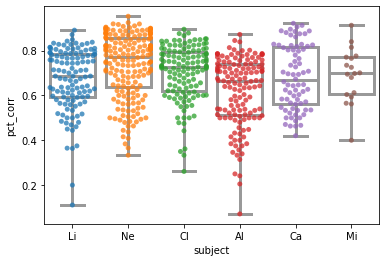

In [82]:
sns.swarmplot(x='subject', y='pct_corr', data=subjects_all_behav, alpha=0.75)
sns.boxplot(x='subject', y='pct_corr', data=subjects_all_behav, color='white', linewidth=3, whis=100)

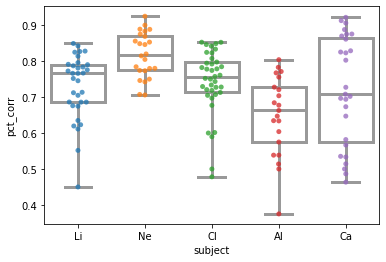

In [83]:
subset = subjects_all_behav[subjects_all_behav.valid_units & subjects_all_behav.Experiment.isin(experiments)]
subset = subset.loc[subset.pct_corr>=0]

sns.swarmplot(x='subject', y='pct_corr', data=subset, alpha=0.75)
sns.boxplot(x='subject', y='pct_corr', data=subset, color='white', linewidth=3, whis=100)

In [84]:
subset.groupby('subject').mean()[['pct_corr', 'pct_sw_corr']]

pct_corr  pct_sw_corr
subject                       
Al       0.648447     0.699494
Ca       0.719210     0.746340
Cl       0.742125     0.812598
Li       0.729918     0.575061
Ne       0.817300     0.736365

In [85]:
subset.mean()[['pct_corr', 'pct_sw_corr', 'num_trials', 'num_sw']]

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


pct_corr         0.733841
pct_sw_corr      0.715868
num_trials     138.083916
num_sw          67.622378
dtype: float64

In [107]:
expt = ['T3h', 'T3g', 'T3j', 'T3i']
pct_criteria = 0.70
n_trial_criteria = 80
behav_by_subject = subjects_all_behav.groupby('subject') 
n_sessions_criterion = []

learning_curves = pd.DataFrame()

#pct_corr_to_crit = 
for subject in subjects:
    try:
        subject_behav = behav_by_subject.get_group(subject)
        

        iB = subject_behav.loc[(subject_behav.Experiment.isin(expt))].index[0]
        iE =  subject_behav.loc[(subject_behav.pct_corr>=pct_criteria) & (subject_behav.num_trials>n_trial_criteria) & 
                                (subject_behav.Experiment.isin(expt))].index[0]
        n_sessions_criterion.append(iE-iB)
        
        learning_curves = pd.concat((learning_curves, subjects_all_behav.iloc[iB:iE]))
        
    except:
        pass
n_sessions_criterion

[21, 6, 16, 45, 20, 7]

In [104]:
subject='Ne'
subject_behav = behav_by_subject.get_group(subject)
iB = subject_behav.loc[(subject_behav.Experiment.isin(expt))].index[0]
iE =  subject_behav.loc[(subject_behav.pct_corr>=pct_criteria) & (subject_behav.num_trials>n_trial_criteria) & (subject_behav.Experiment.isin(expt))].index[0]
#n_sessions_criterion.append(first_exp_session_to_criterion-f

In [106]:
subjects_all_behav.iloc[iB:iE]

Date Experiment  num_trials  num_corr_trials  num_sw  num_corr_sw  \
118 2018-02-20        T3g       160.0             79.0    64.0         22.0   
119 2018-02-21        T3g       160.0             90.0    65.0         13.0   
120 2018-02-22        T3g        71.0             38.0    26.0          1.0   
121 2018-02-22        T3g        44.0             18.0     0.0          0.0   
122 2018-02-23        T3g        39.0             21.0    15.0          3.0   
123 2018-02-23        T3g        30.0             22.0     4.0          0.0   

                                                  Note Checked subject  \
118                                                NaN       x      Ne   
119                                                NaN       x      Ne   
120  these trial values are what is shown for the o...       x      Ne   
121                                                NaN       x      Ne   
122                      Data not shown on other sheet       x      Ne   
123                      Data not shown on other sheet       x      Ne   

     session_num  valid_units  Num Valid Switches  \
118            0        False                 NaN   
119            1        False                 NaN   
120            2        False                 NaN   
121            3        False                 NaN   
122            4        False                 NaN   
123            5        False                 NaN   

     Num Corr After Valid Switch Met Criteria  pct_corr  pct_sw_corr  
118                          NaN          NaN  0.493750     0.343750  
119                          NaN          NaN  0.562500     0.200000  
120                          NaN          NaN  0.535211     0.038462  
121                          NaN          NaN  0.409091          NaN  
122                          NaN          NaN  0.538462     0.200000  
123                          NaN          NaN  0.733333     0.000000

In [89]:
np.mean(n_sessions_criterion)

19.166666666666668

In [145]:
import scipy.optimize
exp_func = lambda b, x: (b[0]*np.exp(b[1]*x)+b[2])
norm_func = lambda b, x, y: np.sum((y- (b[0]*np.exp(b[1]*x)+b[2]) )**2)

n_points = learning_curves.shape[0]
x = learning_curves.session_num + np.random.normal(0, 0.1, n_points)
y = learning_curves.pct_corr
y2 = learning_curves.num_trials

b0 = [0.1, -0.2, 1]
b = scipy.optimize.fmin(norm_func, b0, args=(x,y))

b0_2 = [1, -1, 70]
b2 = scipy.optimize.fmin(norm_func, b0_2, args=(x,y2))


Optimization terminated successfully.
         Current function value: 1.855922
         Iterations: 141
         Function evaluations: 251
Optimization terminated successfully.
         Current function value: 141009.328026
         Iterations: 237
         Function evaluations: 410


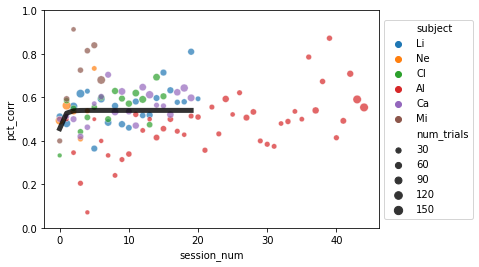

In [153]:
ax = sns.scatterplot(x='session_num', y='pct_corr', hue='subject', size='num_trials', data=learning_curves, alpha=0.7)
ax.set_ylim([0,1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

x = np.arange(0, 20)
ax.plot(x, exp_func(b,x), linewidth=5, color='k', alpha=0.8)

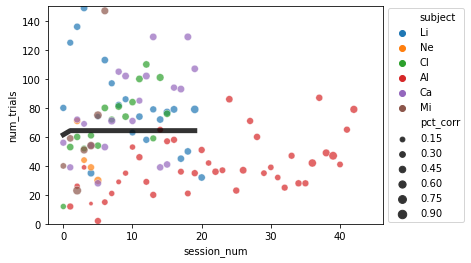

In [148]:
ax = sns.scatterplot(x='session_num', y='num_trials', hue='subject', size='pct_corr' ,data=learning_curves, alpha=0.7)
ax.set_ylim([0,150])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

x = np.arange(0, 20)
ax.plot(x, exp_func(b2,x), linewidth=5, color='k', alpha=0.8)

Optimization terminated successfully.
         Current function value: 1.645741
         Iterations: 232
         Function evaluations: 402


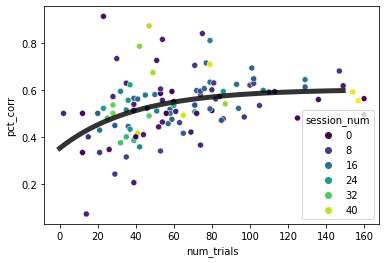

In [164]:
y = learning_curves.pct_corr
x = learning_curves.num_trials+ np.random.normal(0, 0.1, n_points)

b0 = [0.1, -0.2, 1]
b = scipy.optimize.fmin(norm_func, b0, args=(x,y))

ax = sns.scatterplot(x='num_trials',y='pct_corr', hue='session_num', data=learning_curves,palette='viridis')

x = np.arange(0, 150)
ax.plot(x, exp_func(b,x), linewidth=5, color='k', alpha=0.8)

In [131]:
exp_func(b,x)

array([-0.07798865, -1.57675068,  0.54041673])

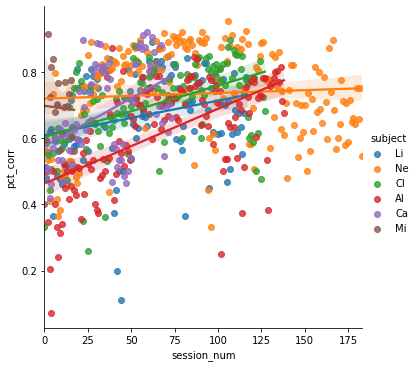

In [94]:
sns.lmplot(x='session_num', y='pct_corr', hue='subject',data=subjects_all_behav)


In [53]:
import numpy as np
np.median(n_sessions_criterion)

20.5

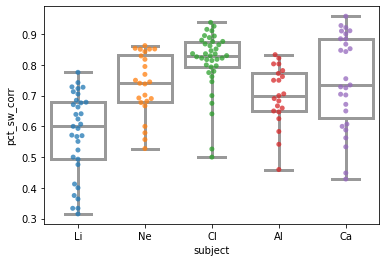

In [13]:
sns.swarmplot(x='subject', y='pct_sw_corr', data=subset, alpha=0.75)
sns.boxplot(x='subject', y='pct_sw_corr', data=subset, color='white', linewidth=3, whis=100)

In [31]:
from statsmodels.formula.api import mixedlm, ols
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm

In [26]:
md = mixedlm('pct_corr ~ session_num + num_trials', subset, groups=subset['subject']).fit()
md.summary()

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: pct_corr
No. Observations: 143     Method:             REML    
No. Groups:       5       Scale:              0.0050  
Min. group size:  21      Log-Likelihood:     152.2006
Max. group size:  38      Converged:          Yes     
Mean group size:  28.6                                
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.524    0.043 12.208 0.000  0.440  0.608
session_num  0.001    0.000  1.544 0.122 -0.000  0.001
num_trials   0.001    0.000 12.702 0.000  0.001  0.001
Group Var    0.003    0.028                           
======================================================

"""

In [28]:
md = ols('pct_corr ~ subject + num_trials', subset).fit()
md.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pct_corr   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     45.28
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           2.07e-27
Time:                        00:44:41   Log-Likelihood:                 178.38
No. Observations:                 143   AIC:                            -344.8
Df Residuals:                     137   BIC:                            -327.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5103      0.019     26.944      0.000       0.473       0.548
subject[T.Ca]     0.0362      0.021      1.737      0.085      -0.005       0.077
subject[T.Cl]     0.0872      0.019      4.517      0.000       0.049       0.125
subject[T.Li]     0.0588      0.020      2.956      0.004       0.019       0.098
subject[T.Ne]     0.1477      0.021      6.941      0.000       0.106       0.190
num_trials        0.0011   8.85e-05     12.694      0.000       0.001       0.001
==============================================================================
Omnibus:                        2.906   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.234   Jarque-Bera (JB):                2.767
Skew:                          -0.340   Prob(JB):                        0.251
Kurtosis:                       2.956   Cond. No.                         950.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
sm.stats.anova_lm(md)

df    sum_sq   mean_sq           F        PR(>F)
subject       4.0  0.329200  0.082300   16.321841  5.892002e-11
num_trials    1.0  0.812459  0.812459  161.127699  6.801190e-25
Residual    137.0  0.690799  0.005042         NaN           NaN

## 6/30/21: Check structure of aggregate coefficients

In [35]:
summary_data_path_local = Path("/mnt/Data_HD2T/SummaryData/")
models_scores_agg_fn = 'of_model_scores_summary_table_agg.csv'

model_scores = pd.read_csv(summary_data_path_local/models_scores_agg_fn, index_col=0)

In [96]:
agg_coefs = model_scores[ (model_scores.metric.isin([m+'_coef' for m in ['agg_all', 'agg_sdp', 'agg_sdbg']])) & (model_scores.split=='train')]
agg_coefs_sdp = agg_coefs[agg_coefs.metric=='agg_sdp_coef']

r2_sdp = model_scores[ (model_scores.metric=='r2') & (model_scores.split=='train') &(model_scores.model=='agg_sdp')]

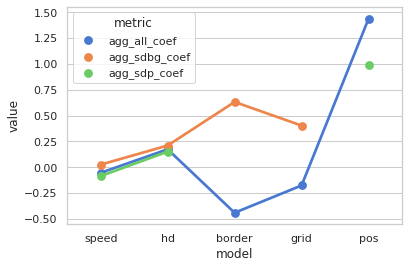

In [116]:
sns.pointplot(x='model', y='value', hue='metric', data=agg_coefs)

In [62]:
agg_coefs_sdp.head(2)

unit_id subject       session  session_unit_id unit_type  session_pct_cov  \
5         0      Li  Li_OF_052818                0      cell             0.96   
19        1      Li  Li_OF_052818                1      cell             0.96   

    session_valid  tt  tt_cl  model  split        metric     value  \
5            True   7      8  speed  train  agg_sdp_coef  0.222397   
19           True   8      4  speed  train  agg_sdp_coef -0.709691   

                        cl_name  
5   Li_OF_052818-tt7_d17.25_cl8  
19  Li_OF_052818-tt8_d16.25_cl4

In [102]:
Dr2 = r2_sdp[['unit_id', 'unit_type', 'subject', 'value']]
Dr2 = Dr2.set_index('unit_id')

In [183]:
D_sdp = agg_coefs_sdp.pivot(index=['unit_id', 'unit_type', 'subject'], columns='model', values='value')
D_sdp.head()

model                            hd       pos     speed
unit_id unit_type subject                              
0       cell      Li      -0.476825  1.223207  0.222397
1       cell      Li       0.512117  1.219179 -0.709691
2       cell      Li      -0.031437  1.174097 -0.149871
3       mua       Li       0.553885  1.286371 -0.802521
4       mua       Li       0.370295  1.186306 -0.522767

In [184]:
D2 = D_sdp.reset_index()
D2 = D2.set_index('unit_id')
D2.head()
unit_type = D2.pop('unit_type')
subject = D2.pop('subject')

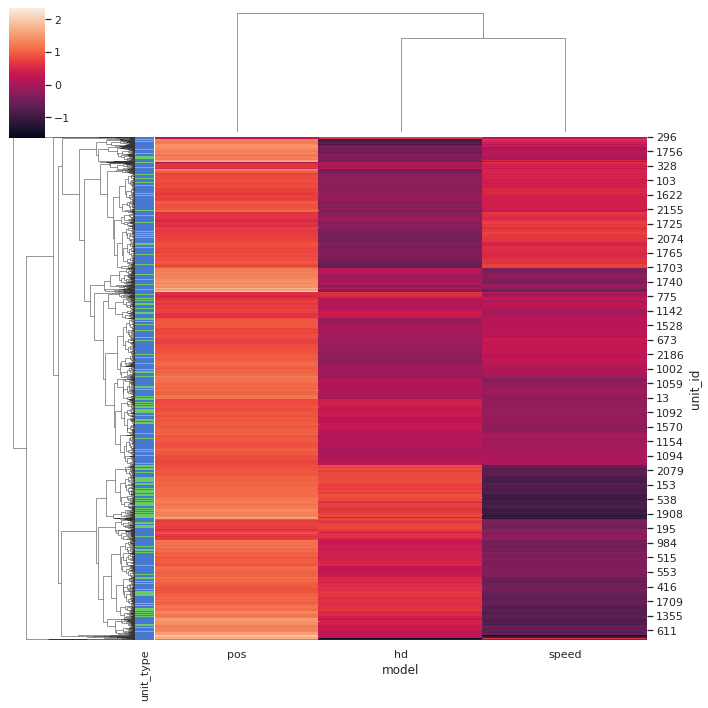

In [185]:
cols = dict(zip(unit_type.unique(), 'gb'))
row_cols = unit_type.map(cols)
sns.clustermap(D2, row_colors=row_cols)

In [186]:
import sklearn as sk
kmeans = sk.cluster.k_means(D2, n_clusters=2)

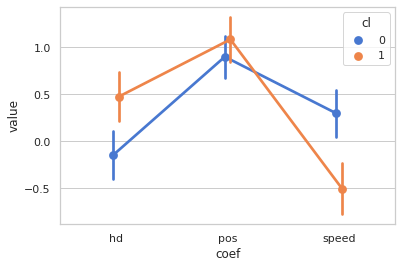

In [211]:
D_sdp = agg_coefs_sdp.pivot(index=['unit_id', 'unit_type', 'subject'], columns='model', values='value')
D_sdp.reset_index(inplace=True)
D_sdp['cl'] = kmeans[1]
D_sdp2 = D_sdp.melt(id_vars=['unit_id', 'unit_type', 'cl'],value_vars=['hd','pos', 'speed'], var_name='coef')


sns.pointplot(data=D_sdp2,x='coef', y='value', hue='cl', ci='sd', dodge=True)
# df=pd.DataFrame(kmeans[0], index=['cl1', 'cl2'], columns=['hd', 'pos', 'speed'])
# sns.pointplot(df.melt(var_name='coef', ignore_index=False).reset_index(), x='coef', y='value',hue='index')

In [94]:
from umap import UMAP
#method_kwargs = {'n_components': 3, 'n_neighbors': 20, 'min_dist': 0.00} # work well for cells only
method_kwargs = {'n_components': 2, 'n_neighbors': 30, 'min_dist': 0}
np.random.seed(0)
models_umap = UMAP(**method_kwargs).fit_transform(D2)

#method_kwargs = {'n_components': 2, 'n_neighbors': 30, 'min_dist': 0}
#models_umap_umap =  UMAP(**method_kwargs).fit_transform(models_umap)

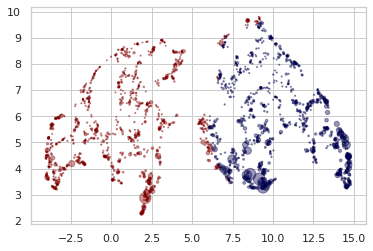

In [152]:
plt.scatter(models_umap[:,0], models_umap[:,1], c=kmeans[1]-1, s=(Dr2.value+1)**10, cmap='seismic', alpha=0.4)

#### conclusion from sdp:
coefficients cluster based on high hd / high pos and high speed/high pos coding. 

### Checking sdbg

In [266]:
r2_sdbg = model_scores[ (model_scores.metric=='r2') & (model_scores.split=='train') &(model_scores.model=='agg_sdbg')]
Dr2 = r2_sdp[['unit_id', 'unit_type', 'subject', 'value']]
Dr2 = Dr2.set_index('unit_id')
Dr2 = Dr2.dropna()

agg_coefs_sdbg =   agg_coefs[agg_coefs.metric=='agg_sdbg_coef']
D = agg_coefs_sdbg.pivot(index=['unit_id', 'unit_type', 'subject'], columns='model', values='value')
D = D.dropna()
D =  D.reset_index()
D = D.set_index('unit_id')
D['r2'] = Dr2.loc[D.index, 'value']
D.head()

model   unit_type subject    border      grid        hd     speed        r2
unit_id                                                                    
1            cell      Li  0.527303  0.567424  0.569914 -0.529386  0.063751
3             mua      Li  0.782187  0.561907  0.635657 -0.501899  0.063063
6             mua      Li  0.988511  0.639958 -0.067147 -0.085460  0.116026
7             mua      Li  0.937057  0.195527  0.163318 -0.174799  0.065480
14           cell      Li  0.328730  0.343219  0.740953 -0.190673  0.038587

In [267]:
D2 =D.copy()
unit_type = D2.pop('unit_type')
subject = D2.pop('subject')
r2 = D2.pop('r2')
D2.head()

model      border      grid        hd     speed
unit_id                                        
1        0.527303  0.567424  0.569914 -0.529386
3        0.782187  0.561907  0.635657 -0.501899
6        0.988511  0.639958 -0.067147 -0.085460
7        0.937057  0.195527  0.163318 -0.174799
14       0.328730  0.343219  0.740953 -0.190673

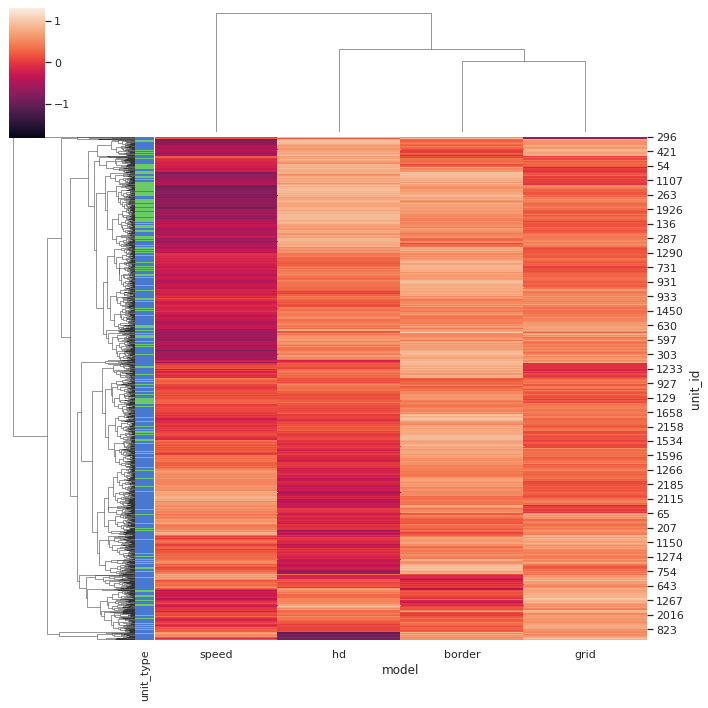

In [269]:
cols = dict(zip(unit_type.unique(), 'gb'))
row_cols = unit_type.map(cols)
sns.clustermap(D2, row_colors=row_cols)

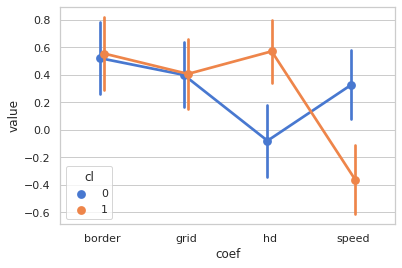

In [276]:
kmeans = sk.cluster.k_means(D2, n_clusters=2)

D['cl'] = kmeans[1]
D3 = D.melt(id_vars=['unit_type', 'cl'],value_vars=['border', 'grid', 'hd', 'speed'], var_name='coef', ignore_index=False)

#D3=D3.set_index('unit_id')

sns.pointplot(data=D3,x='coef', y='value', hue='cl', ci='sd', dodge=True)

In [280]:
D3.loc[1]

unit_type  cl    coef     value
unit_id                                
1            cell   1  border  0.527303
1            cell   1    grid  0.567424
1            cell   1      hd  0.569914
1            cell   1   speed -0.529386

In [283]:
1/320*2

0.00625

In [219]:
method_kwargs = {'n_components': 2, 'n_neighbors': 30, 'min_dist': 0}
np.random.seed(0)
models_umap = UMAP(**method_kwargs).fit_transform(D2.dropna())

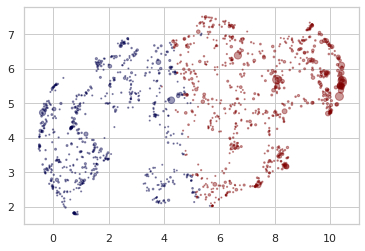

In [281]:
plt.scatter(models_umap[:,0], models_umap[:,1], c=kmeans[1], s=(D['r2']+1)**10, cmap='seismic', alpha=0.4)

In [226]:
models_umap.shape, Dr2.shape

((1389, 2), (2219, 3))

## 6/28/21: Check aggregate models update to API

In [8]:
from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)
session = 'Li_OF_062718'
subject = session.split('_')[0]
#subject_info = si.SubjectInfo(subject, overwrite=True)
session_info = si.SubjectSessionInfo(subject, session)

In [4]:
session_info.get_encoding_models_scores(overwrite=True)

Getting Encoding Models
speed model completed. 4.97secs
hd model completed. 4.35secs
ha model completed. 4.60secs
border model completed. 2.59secs
grid model completed. 13.01secs
pos model completed. 17.05secs
aggregate all model completed. 4.85secs
aggregate sdp model completed. 4.24secs
aggregate sdbg model completed. 3.70secs


unit_id         metric  split     model      value
0          0   agg_all_coef   test     speed  -0.237018
1          0   agg_all_coef  train     speed  -0.237018
2          0  agg_sdbg_coef   test     speed  -0.190673
3          0  agg_sdbg_coef  train     speed  -0.190673
4          0   agg_sdp_coef   test     speed  -0.251686
5          0   agg_sdp_coef  train     speed  -0.251686
6          0            ar2   test     speed  -0.010332
7          0            ar2  train     speed   0.004830
8          0           coef   test     speed  -0.219122
9          0           coef  train     speed  -0.219122
10         0            err   test     speed   2.018115
11         0            err  train     speed   2.027951
12         0          map_r   test     speed   0.386189
13         0          map_r  train     speed   0.329851
14         0          n_err   test     speed   2.881105
15         0          n_err  train     speed   2.873762
16         0             r2   test     speed  -0.004329
17         0             r2  train     speed   0.006301
18         1   agg_all_coef   test     speed  -0.122699
19         1   agg_all_coef  train     speed  -0.122699
20         1  agg_sdbg_coef   test     speed  -0.018618
21         1  agg_sdbg_coef  train     speed  -0.018618
22         1   agg_sdp_coef   test     speed  -0.098255
23         1   agg_sdp_coef  train     speed  -0.098255
24         1            ar2   test     speed   0.002635
25         1            ar2  train     speed   0.016483
26         1           coef   test     speed   0.673532
27         1           coef  train     speed   0.673532
28         1            err   test     speed   4.955843
29         1            err  train     speed   4.949169
30         1          map_r   test     speed   0.658266
31         1          map_r  train     speed   0.551753
32         1          n_err   test     speed   1.310599
33         1          n_err  train     speed   1.308644
34         1             r2   test     speed   0.008555
35         1             r2  train     speed   0.017937
36         2   agg_all_coef   test     speed  -0.120410
37         2   agg_all_coef  train     speed  -0.120410
38         2  agg_sdbg_coef   test     speed  -0.070083
39         2  agg_sdbg_coef  train     speed  -0.070083
40         2   agg_sdp_coef   test     speed  -0.155907
41         2   agg_sdp_coef  train     speed  -0.155907
42         2            ar2   test     speed   0.007153
43         2            ar2  train     speed   0.021253
44         2           coef   test     speed   1.183912
45         2           coef  train     speed   1.183912
46         2            err   test     speed   5.573302
47         2            err  train     speed   5.547490
48         2          map_r   test     speed   0.712364
49         2          map_r  train     speed   0.630429
50         2          n_err   test     speed   1.063241
51         2          n_err  train     speed   1.058283
52         2             r2   test     speed   0.013044
53         2             r2  train     speed   0.022700
54         3   agg_all_coef   test     speed  -0.537515
55         3   agg_all_coef  train     speed  -0.537515
56         3  agg_sdbg_coef   test     speed  -0.421706
57         3  agg_sdbg_coef  train     speed  -0.421706
58         3   agg_sdp_coef   test     speed  -0.650606
59         3   agg_sdp_coef  train     speed  -0.650606
60         3            ar2   test     speed  -0.004597
61         3            ar2  train     speed   0.011452
62         3           coef   test     speed   1.361757
63         3           coef  train     speed   1.361757
64         3            err   test     speed   8.220063
65         3            err  train     speed   8.167194
66         3          map_r   test     speed   0.434548
67         3          map_r  train     speed   0.420611
68         3          n_err   test     speed   1.825589
69         3          n_err  train     speed   1.810128
70         3             r2  

In [9]:
df = session_info.get_encoding_models_scores()

In [13]:
model_scores = df
agg_coefs = model_scores[ (model_scores.metric.isin([m+'_coef' for m in ['agg_all', 'agg_sdp', 'agg_sdbg']])) & (model_scores.split=='train')]

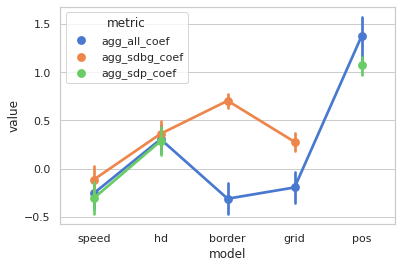

In [14]:
sns.pointplot(x='model', y='value', hue='metric', data=agg_coefs)

In [16]:
df.metric.unique(), df.model.unique()

(array(['agg_all_coef', 'agg_sdbg_coef', 'agg_sdp_coef', 'ar2', 'coef',
        'err', 'map_r', 'n_err', 'r2'], dtype=object),
 array(['speed', 'hd', 'ha', 'border', 'grid', 'pos', 'agg_all', 'agg_sdp',
        'agg_sdbg'], dtype=object))

In [33]:
df[(df.unit_id==10) & (df.model=='agg_all')]

unit_id metric  split    model     value
3192       10    ar2   test  agg_all  0.493303
3193       10    ar2  train  agg_all  0.547090
3194       10   coef   test  agg_all       NaN
3195       10   coef  train  agg_all       NaN
3196       10    err   test  agg_all  9.318709
3197       10    err  train  agg_all  8.984710
3198       10  map_r   test  agg_all  0.928026
3199       10  map_r  train  agg_all  0.970031
3200       10  n_err   test  agg_all  0.727613
3201       10  n_err  train  agg_all  0.698868
3202       10     r2   test  agg_all  0.495849
3203       10     r2  train  agg_all  0.547651

In [34]:
session_info.cluster_ids[str(10)]

['cell', '10', '7']

In [29]:
models = ['speed', 'hd', 'border', 'grid', 'pos', 'agg_all', 'agg_sdp','agg_sdbg']
metrics = ['r2', 'map_r', 'n_err', 'coef', 'agg_all_coef', 'agg_sdbg_coef', 'agg_sdp_coef']

mask = df['metric'].isin(metrics) & df['model'].isin(models)

df2 = pd.DataFrame(index=range(mask.sum()), columns=['unit_id', 'model', 'metric', 'split', 'value'])
df2.loc[:,['unit_id', 'model', 'metric', 'split', 'value']] = pd.DataFrame(df[mask])
# df2.head(100)

In [30]:
df2

unit_id   model         metric  split        value
0          0   speed   agg_all_coef   test     -0.87681
1          0   speed   agg_all_coef  train     -0.87681
2          0   speed  agg_sdbg_coef   test    -0.632133
3          0   speed  agg_sdbg_coef  train    -0.632133
4          0   speed   agg_sdp_coef   test     -0.96063
5          0   speed   agg_sdp_coef  train     -0.96063
6        NaN     NaN            NaN    NaN          NaN
7        NaN     NaN            NaN    NaN          NaN
8          0   speed           coef   test    -0.894824
9          0   speed           coef  train    -0.894824
10       NaN     NaN            NaN    NaN          NaN
11       NaN     NaN            NaN    NaN          NaN
12         0   speed          map_r   test      0.37886
13         0   speed          map_r  train      0.32809
14         0   speed          n_err   test      2.44863
15         0   speed          n_err  train      2.43823
16         0   speed             r2   test   -0.0113995
17         0   speed             r2  train   0.00471068
18         1   speed   agg_all_coef   test    -0.904377
19         1   speed   agg_all_coef  train    -0.904377
20         1   speed  agg_sdbg_coef   test    -0.661221
21         1   speed  agg_sdbg_coef  train    -0.661221
22         1   speed   agg_sdp_coef   test    -0.912892
23         1   speed   agg_sdp_coef  train    -0.912892
24       NaN     NaN            NaN    NaN          NaN
25       NaN     NaN            NaN    NaN          NaN
26         1   speed           coef   test    -0.662767
27         1   speed           coef  train    -0.662767
28       NaN     NaN            NaN    NaN          NaN
29       NaN     NaN            NaN    NaN          NaN
30         1   speed          map_r   test      0.52289
31         1   speed          map_r  train     0.446467
32         1   speed          n_err   test      1.58031
33         1   speed          n_err  train      1.56869
34         1   speed             r2   test  -0.00891455
35         1   speed             r2  train   0.00887078
36         2   speed   agg_all_coef   test    -0.834529
37         2   speed   agg_all_coef  train    -0.834529
38         2   speed  agg_sdbg_coef   test    -0.723306
39         2   speed  agg_sdbg_coef  train    -0.723306
40         2   speed   agg_sdp_coef   test     -0.83718
41         2   speed   agg_sdp_coef  train     -0.83718
42       NaN     NaN            NaN    NaN          NaN
43       NaN     NaN            NaN    NaN          NaN
44         2   speed           coef   test    0.0215682
45         2   speed           coef  train    0.0215682
46       NaN     NaN            NaN    NaN          NaN
47       NaN     NaN            NaN    NaN          NaN
48         2   speed          map_r   test     0.814806
49         2   speed          map_r  train     0.688139
50         2   speed          n_err   test     0.694343
51         2   speed          n_err  train     0.686704
52         2   speed             r2   test   -0.0106369
53         2   speed             r2  train   0.00989938
54         3   speed   agg_all_coef   test    -0.358537
55         3   speed   agg_all_coef  train    -0.358537
56         3   speed  agg_sdbg_coef   test     -0.24486
57         3   speed  agg_sdbg_coef  train     -0.24486
58         3   speed   agg_sdp_coef   test    -0.418314
59         3   speed   agg_sdp_coef  train    -0.418314
60       NaN     NaN            NaN    NaN          NaN
61       NaN     NaN            NaN    NaN          NaN
62         3   speed           coef   test      1.28222
63         3   speed           coef  train      1.28222
64       NaN     NaN            NaN    NaN          NaN
65       NaN     NaN            NaN    NaN          NaN
66         3   speed          map_r   test     0.541724
67         3   speed          map_r  train     0.445064
68         3   speed          n_err   test       1.7062
69         3   speed          n_err  train      1.69566
70         3   speed         

In [89]:
of_funcs = reload(of_funcs)
sem = of_funcs.get_session_encoding_models(session_info)

speed model completed. 4.68secs
hd model completed. 4.37secs
ha model completed. 4.59secs
border model completed. 2.59secs
grid model completed. 12.51secs
pos model completed. 17.10secs
aggregate all model completed. 4.67secs
aggregate sdp model completed. 4.25secs
aggregate sdbg model completed. 3.64secs


In [91]:
df = sem.scores
df.head()
df.to_csv('test_file.csv')

In [9]:
behav = session_info.get_track_data()
x, y, speed = behav['x'], behav['y'], behav['sp']
ha, hd = behav['ha'], behav['hd']
fr = session_info.get_fr()
spks = s.ession_info.get_binned_spikes()

sos_coefs = signal.tf2sos(session_info.task_params['filter_coef_'], 1)
fr2 = signal.sosfiltfilt(sos_coefs, fr, axis=1)
    
params = session_info.task_params

In [30]:
spatial_funcs = reload(spatial_funcs)
of_funcs = reload(of_funcs)
sem = of_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,neural_data=fr2[0:5], **params)


In [19]:
%%time
sem.get_speed_model()

CPU times: user 8.23 s, sys: 8.98 s, total: 17.2 s
Wall time: 1.11 s


In [17]:
%%time 
sem.get_grid_model()

CPU times: user 14.4 s, sys: 7.64 s, total: 22 s
Wall time: 32.1 s


In [31]:
%%time
sem.get_models()

speed model completed. 1.11secs
hd model completed. 0.97secs
ha model completed. 1.01secs
border model completed. 0.73secs
grid model completed. 10.80secs
pos model completed. 3.52secs
aggregate all model completed. 1.22secs
aggregate sdp model completed. 1.07secs
aggregate sdbg model completed. 0.98secs
CPU times: user 1min 40s, sys: 1min 47s, total: 3min 28s
Wall time: 21.4 s


In [25]:
sem.speed_model.scores[sem.speed_model.scores.metric=='coeff']

Empty DataFrame
Columns: [fold, unit_id, metric, split, value]
Index: []

In [33]:
df = sem.get_scores()
df.shape

(660, 5)

In [37]:
sem.n_units*len(sem.all_model_names)*

45

In [82]:
model_scores = sem.scores

In [84]:
agg_coefs = model_scores[ (model_scores.metric.isin([m+'_coef' for m in sem.agg_model_names])) & (model_scores.split=='train')]

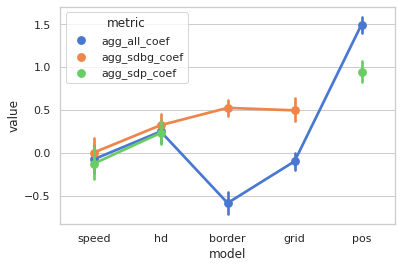

In [85]:
sns.pointplot(x='model', y='value', hue='metric', data=agg_coefs)

In [86]:
agg_scores = model_scores[ (model_scores.model.isin(sem.agg_model_names)) & (model_scores.split=='train')]
agg_scores.head()

unit_id metric  split    model     value
2017       0    ar2  train  agg_all  0.021413
2019       0   coef  train  agg_all       NaN
2021       0    err  train  agg_all  4.387388
2023       0  map_r  train  agg_all  0.670379
2025       0  n_err  train  agg_all  1.310124

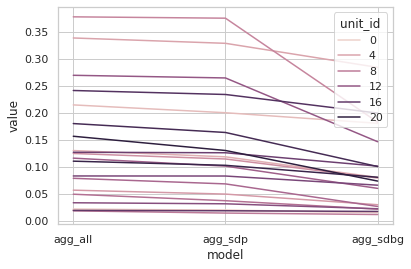

In [87]:
sns.lineplot(data=agg_scores[agg_scores.metric=='r2'], x='model', y='value', hue='unit_id')

## 5/20/21: check aggregate model API

In [2]:
from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)
session = 'Li_OF_060118'
subject = session.split('_')[0]
#subject_info = si.SubjectInfo(subject, overwrite=True)
session_info = si.SubjectSessionInfo(subject, session)

In [4]:
session_info.run_analyses()

Getting Encoding Models
Analysis encoding_models failed.


In [3]:
of_funcs = reload(of_funcs)
sem = of_funcs.get_session_encoding_models(session_info)

speed model completed. 3.86secs
hd model completed. 3.39secs
ha model completed. 3.38secs
border model completed. 1.94secs
grid model completed. 15.80secs
pos model completed. 11.98secs
agg model completed. 3.50secs


In [10]:
sem.scores

unit_id    metric  split  model     value
0          0  agg_coef   test  speed  0.107132
1          0  agg_coef  train  speed  0.107132
2          0       ar2   test  speed -0.004601
3          0       ar2  train  speed  0.007856
4          0      coef   test  speed  0.854047
...      ...       ...    ...    ...       ...
2011      20     map_r  train    agg  0.902819
2012      20     n_err   test    agg  0.529897
2013      20     n_err  train    agg  0.488695
2014      20        r2   test    agg -0.017210
2015      20        r2  train    agg  0.156949

[2016 rows x 5 columns]

In [10]:
behav = session_info.get_track_data()
x, y, speed = behav['x'], behav['y'], behav['sp']
ha, hd = behav['ha'], behav['hd']
fr = session_info.get_fr()
spks = session_info.get_binned_spikes()

sos_coefs = signal.tf2sos(session_info.task_params['filter_coef_'], 1)
fr2 = signal.sosfiltfilt(sos_coefs, fr, axis=1)
    
params = session_info.task_params

In [28]:
spatial_funcs = reload(spatial_funcs)
sem = spatial_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,neural_data=fr2[0:5], **params)
scores = sem.get_models()

speed model completed. 1.18secs
hd model completed. 1.04secs
ha model completed. 1.01secs
border model completed. 0.68secs
grid model completed. 20.40secs
pos model completed. 3.39secs
agg model completed. 1.11secs


In [29]:
a=sem.get_scores()

In [14]:
pd.DataFrame(None).empty

True

In [16]:

np.arange(5)[np.array(['speed', 'hd', 'border', 'grid', 'pos'])=='agg']

array([], dtype=int64)

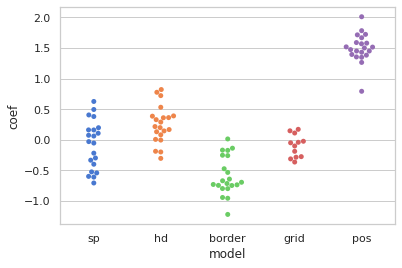

In [10]:
sns.swarmplot(x='model', y='coef', data=b)

In [4]:
of_funcs = reload(of_funcs)
sem = of_funcs.get_session_encoding_models(session_info)

speed model completed. 3.82secs
hd model completed. 3.36secs
ha model completed. 3.53secs
border model completed. 2.00secs
grid model completed. 16.38secs
pos model completed. 13.97secs
agg model completed. 3.74secs


ValueError: setting an array element with a sequence.

In [6]:
behav = session_info.get_track_data()
x, y, speed = behav['x'], behav['y'], behav['sp']
ha, hd = behav['ha'], behav['hd']
fr = session_info.get_fr()
spks = session_info.get_binned_spikes()

sos_coefs = signal.tf2sos(session_info.task_params['filter_coef_'], 1)
fr2 = signal.sosfiltfilt(sos_coefs, fr, axis=1)
    
params = session_info.task_params

In [85]:
spatial_funcs = reload(spatial_funcs)
sem = spatial_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,neural_data=fr2, **params)
scores = sem.get_models()

speed model completed. 3.74secs
hd model completed. 3.50secs
ha model completed. 3.51secs
border model completed. 2.01secs
grid model completed. 25.00secs
pos model completed. 13.42secs
agg model completed. 3.91secs


In [86]:
s = sem.get_scores()

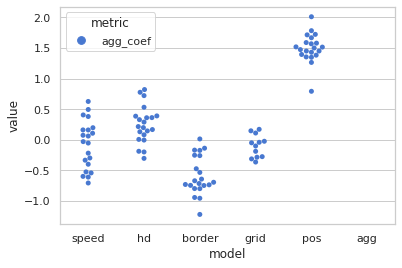

In [88]:
sns.swarmplot(x='model', y='value', hue='metric', data=s[(s.metric=='agg_coef') & (s.split=='train')])

In [64]:
ss = sem.border_model.avg_folds()
ss[ss.metric=='coef']

unit_id metric  split     value
4          0   coef   test  0.620562
5          0   coef  train  0.620562
18         1   coef   test  0.863619
19         1   coef  train  0.863619
32         2   coef   test  1.000000
33         2   coef  train  1.000000
46         3   coef   test  0.168666
47         3   coef  train  0.168666
60         4   coef   test  1.000000
61         4   coef  train  1.000000
74         5   coef   test  1.000000
75         5   coef  train  1.000000
88         6   coef   test -0.758797
89         6   coef  train -0.758797
102        7   coef   test  0.366593
103        7   coef  train  0.366593
116        8   coef   test  0.759743
117        8   coef  train  0.759743
130        9   coef   test  0.448782
131        9   coef  train  0.448782
144       10   coef   test  0.947848
145       10   coef  train  0.947848
158       11   coef   test  1.000000
159       11   coef  train  1.000000
172       12   coef   test  0.981347
173       12   coef  train  0.981347
186       13   coef   test  0.411601
187       13   coef  train  0.411601
200       14   coef   test  1.000000
201       14   coef  train  1.000000
214       15   coef   test  1.000000
215       15   coef  train  1.000000
228       16   coef   test  0.942823
229       16   coef  train  0.942823
242       17   coef   test  0.758323
243       17   coef  train  0.758323
256       18   coef   test  0.664484
257       18   coef  train  0.664484
270       19   coef   test -0.606881
271       19   coef  train -0.606881
284       20   coef   test  0.242153
285       20   coef  train  0.242153

In [69]:
cc = sem.get_coefs('border')
betas=cc[2,0]
b = np.max(betas[0:4])
ce = betas[4]

(1.0900248350090265, -0.026434292566866135, 1.1164591275758926)

In [76]:
(b-ce)/(np.abs(np.mean(betas[:4])) + np.abs(ce))

2.4247609824387615

In [81]:
np.mean(abs(betas))

0.49540522514021357

In [30]:
s = sem.speed_model.scores
s.metric.unique()

array(['r2', 'ar2', 'err', 'n_err', 'map_r', 'coef', 'agg_coef'],
      dtype=object)

## 5/7/21: combine model predictions into single model to predict fr again

In [3]:
from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)
session = 'Li_OF_060118'
subject = session.split('_')[0]
session_info = si.SubjectSessionInfo(subject, session)

In [4]:
of_funcs = reload(of_funcs)
spatial_funcs = reload(spatial_funcs)
sem = of_funcs.get_session_encoding_models(session_info)

speed model completed. 3.79secs
hd model completed. 3.54secs
ha model completed. 3.37secs
border model completed. 1.98secs
grid model completed. 15.76secs
pos model completed. 12.62secs
agg model completed. 3.64secs


In [6]:
scores = sem.get_scores()

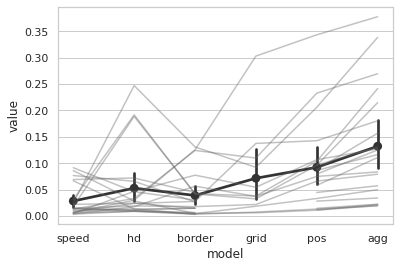

In [95]:
d = scores[(scores.metric=='r2') & (scores.split=='train') & (scores.model!='ha')].reset_index(drop=True)
ax = sns.pointplot(data=d, x='model', y='value', color='0.2')
for unit in range(sem.n_units):
    ax.plot(np.arange(6), d[d.unit_id==unit].value.values, alpha=0.4, color='0.4')


In [124]:
sem.agg_model.

In [97]:
c = sem.get_coefs('agg')
cc = np.zeros( (sem.n_xval, sem.n_units, 5)) 
for fold in range(sem.n_xval):
    cc[fold] = np.array(list(c[fold]),dtype=np.float)
    
    for unit in range(sem.n_units):
        if sem.grid_model.models[fold,unit] is None:
            cc[fold,unit][3] = np.nan
    

In [111]:
d = pd.DataFrame(np.nanmean(cc,axis=0), columns=['sp', 'hd', 'border', 'grid', 'pos']).melt(var_name='model')
d['unit_id'] = np.tile(np.arange(sem.n_units), 5 )
d = d.rename(columns={"value": "coef"})
d

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


model      coef  unit_id
0        sp  0.107132        0
1        sp  0.160925        1
2        sp -0.217441        2
3        sp  0.074155        3
4        sp -0.522909        4
5        sp  0.061651        5
6        sp  0.380312        6
7        sp -0.539853        7
8        sp -0.029246        8
9        sp -0.296308        9
10       sp -0.052701       10
11       sp  0.161752       11
12       sp -0.332181       12
13       sp  0.197559       13
14       sp -0.607772       14
15       sp -0.704195       15
16       sp  0.405637       16
17       sp -0.596307       17
18       sp -0.398164       18
19       sp  0.625800       19
20       sp  0.494736       20
21       hd  0.216313        0
22       hd  0.289367        1
23       hd  0.775626        2
24       hd  0.145185        3
25       hd  0.721068        4
26       hd  0.199077        5
27       hd -0.198115        6
28       hd  0.360077        7
29       hd  0.328936        8
30       hd  0.385621        9
31       hd  0.167334       10
32       hd  0.081771       11
33       hd -0.004205       12
34       hd  0.006979       13
35       hd  0.362245       14
36       hd  0.531339       15
37       hd  0.131409       16
38       hd  0.820104       17
39       hd  0.390056       18
40       hd -0.302626       19
41       hd -0.186870       20
42   border -0.640591        0
43   border -0.795056        1
44   border -0.668129        2
45   border -0.712754        3
46   border -0.251382        4
47   border -0.745195        5
48   border -0.734091        6
49   border -0.172054        7
50   border -0.940463        8
51   border -1.216887        9
52   border -0.728308       10
53   border -0.796507       11
54   border -0.136622       12
55   border -0.531780       13
56   border  0.014238       14
57   border -0.167851       15
58   border -0.257680       16
59   border -0.471872       17
60   border -0.743016       18
61   border -0.692439       19
62   border -0.953108       20
63     grid       NaN        0
64     grid       NaN        1
65     grid -0.274371        2
66     grid       NaN        3
67     grid -0.362514        4
68     grid       NaN        5
69     grid       NaN        6
70     grid -0.048750        7
71     grid  0.111027        8
72     grid  0.171308        9
73     grid -0.283708       10
74     grid       NaN       11
75     grid -0.187511       12
76     grid       NaN       13
77     grid -0.023532       14
78     grid -0.100374       15
79     grid -0.040529       16
80     grid -0.311111       17
81     grid  0.147000       18
82     grid       NaN       19
83     grid       NaN       20
84      pos  1.345934        0
85      pos  1.380991        1
86      pos  1.471516        2
87      pos  1.512669        3
88      pos  1.498211        4
89      pos  1.516072        5
90      pos  1.566281        6
91      pos  1.448815        7
92      pos  1.586601        8
93      pos  2.007686        9
94      pos  1.712117       10
95      pos  1.577062       11
96      pos  1.780377       12
97      pos  1.352333       13
98      pos  1.262596       14
99      pos  1.428567       15
100     pos  0.791663       16
101     pos  1.449035       17
102     pos  1.720201       18
103     pos  1.392230       19
104     pos  1.665289       20

In [108]:
np.tile(np.arange(sem.n_units), 5 )

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19, 20,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [107]:
d.columns

Index(['model', 'value'], dtype='object')

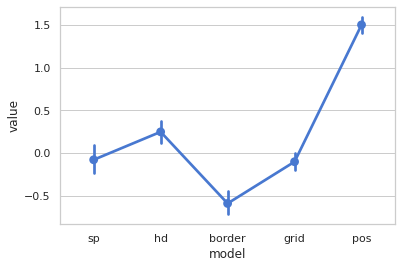

In [94]:
ax=sns.pointplot(data=d, x='model', y='value')

In [93]:
d.iloc[:]

model     value
0        sp  0.107132
1        sp  0.160925
2        sp -0.217441
3        sp  0.074155
4        sp -0.522909
5        sp  0.061651
6        sp  0.380312
7        sp -0.539853
8        sp -0.029246
9        sp -0.296308
10       sp -0.052701
11       sp  0.161752
12       sp -0.332181
13       sp  0.197559
14       sp -0.607772
15       sp -0.704195
16       sp  0.405637
17       sp -0.596307
18       sp -0.398164
19       sp  0.625800
20       sp  0.494736
21       hd  0.216313
22       hd  0.289367
23       hd  0.775626
24       hd  0.145185
25       hd  0.721068
26       hd  0.199077
27       hd -0.198115
28       hd  0.360077
29       hd  0.328936
30       hd  0.385621
31       hd  0.167334
32       hd  0.081771
33       hd -0.004205
34       hd  0.006979
35       hd  0.362245
36       hd  0.531339
37       hd  0.131409
38       hd  0.820104
39       hd  0.390056
40       hd -0.302626
41       hd -0.186870
42   border -0.640591
43   border -0.795056
44   border -0.668129
45   border -0.712754
46   border -0.251382
47   border -0.745195
48   border -0.734091
49   border -0.172054
50   border -0.940463
51   border -1.216887
52   border -0.728308
53   border -0.796507
54   border -0.136622
55   border -0.531780
56   border  0.014238
57   border -0.167851
58   border -0.257680
59   border -0.471872
60   border -0.743016
61   border -0.692439
62   border -0.953108
63     grid       NaN
64     grid       NaN
65     grid -0.274371
66     grid       NaN
67     grid -0.362514
68     grid       NaN
69     grid       NaN
70     grid -0.048750
71     grid  0.111027
72     grid  0.171308
73     grid -0.283708
74     grid       NaN
75     grid -0.187511
76     grid       NaN
77     grid -0.023532
78     grid -0.100374
79     grid -0.040529
80     grid -0.311111
81     grid  0.147000
82     grid       NaN
83     grid       NaN
84      pos  1.345934
85      pos  1.380991
86      pos  1.471516
87      pos  1.512669
88      pos  1.498211
89      pos  1.516072
90      pos  1.566281
91      pos  1.448815
92      pos  1.586601
93      pos  2.007686
94      pos  1.712117
95      pos  1.577062
96      pos  1.780377
97      pos  1.352333
98      pos  1.262596
99      pos  1.428567
100     pos  0.791663
101     pos  1.449035
102     pos  1.720201
103     pos  1.392230
104     pos  1.665289

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


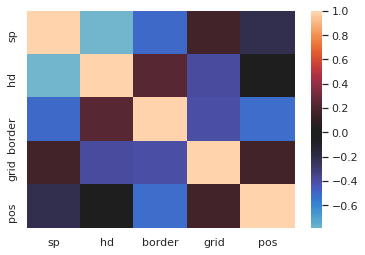

In [81]:
d = pd.DataFrame(np.nanmean(cc,axis=0), columns=['sp', 'hd', 'border', 'grid', 'pos'])
sns.heatmap(d.corr(), center=0)

In [76]:
900+250+175+6000+2400

9725

In [5]:
of_funcs = reload(of_funcs)
spatial_funcs = reload(spatial_funcs)
sem.get_agg_model()

In [10]:
['a']+['b']

['a', 'b']

In [8]:
sem.agg_model.avg_folds()

unit_id metric  split      value
0          0    ar2   test  -0.014644
1          0    ar2  train   0.021413
2          0    err   test   4.447388
3          0    err  train   4.387388
4          0  map_r   test   0.652053
5          0  map_r  train   0.670379
6          0  n_err   test   1.327396
7          0  n_err  train   1.310124
8          0     r2   test  -0.011568
9          0     r2  train   0.022154
10         1    ar2   test  -0.006245
11         1    ar2  train   0.020991
12         1    err   test   3.234797
13         1    err  train   3.198975
14         1  map_r   test   0.585567
15         1  map_r  train   0.593493
16         1  n_err   test   1.620285
17         1  n_err  train   1.599865
18         1     r2   test  -0.003194
19         1     r2  train   0.021733
20         2    ar2   test   0.142766
21         2    ar2  train   0.214354
22         2    err   test   6.245406
23         2    err  train   6.004728
24         2  map_r   test   0.681192
25         2  map_r  train   0.788519
26         2  n_err   test   1.663710
27         2  n_err  train   1.598344
28         2     r2   test   0.145365
29         2     r2  train   0.214950
30         3    ar2   test   0.033564
31         3    ar2  train   0.129843
32         3    err   test  19.525509
33         3    err  train  18.615166
34         3  map_r   test   0.930350
35         3  map_r  train   0.939592
36         3  n_err   test   0.405990
37         3  n_err  train   0.385819
38         3     r2   test   0.036495
39         3     r2  train   0.130502
40         4    ar2   test   0.256926
41         4    ar2  train   0.338245
42         4    err   test   6.089859
43         4    err  train   5.837081
44         4  map_r   test   0.787299
45         4  map_r  train   0.890349
46         4  n_err   test   1.456255
47         4  n_err  train   1.384750
48         4     r2   test   0.259178
49         4     r2  train   0.338746
50         5    ar2   test   0.006011
51         5    ar2  train   0.056519
52         5    err   test   5.336902
53         5    err  train   5.220843
54         5  map_r   test   0.721178
55         5  map_r  train   0.770811
56         5  n_err   test   1.068699
57         5  n_err  train   1.045330
58         5     r2   test   0.009025
59         5     r2  train   0.057234
60         6    ar2   test   0.011838
61         6    ar2  train   0.124438
62         6    err   test  17.611449
63         6    err  train  16.634152
64         6  map_r   test   0.951158
65         6  map_r  train   0.957221
66         6  n_err   test   0.338492
67         6  n_err  train   0.319232
68         6     r2   test   0.014834
69         6     r2  train   0.125101
70         7    ar2   test   0.324072
71         7    ar2  train   0.377372
72         7    err   test   5.917162
73         7    err  train   5.781995
74         7  map_r   test   0.842621
75         7  map_r  train   0.930208
76         7  n_err   test   1.920954
77         7  n_err  train   1.877655
78         7     r2   test   0.326121
79         7     r2  train   0.377844
80         8    ar2   test  -0.000650
81         8    ar2  train   0.018217
82         8    err   test   2.107214
83         8    err  train   2.116716
84         8  map_r   test   0.373370
85         8  map_r  train   0.442218
86         8  n_err   test   2.942901
87         8  n_err  train   2.963236
88         8     r2   test   0.002384
89         8     r2  train   0.018961
90         9    ar2   test  -0.043983
91         9    ar2  train   0.049012
92         9    err   test   3.836375
93         9    err  train   3.674579
94         9  map_r   test   0.249009
95         9  map_r  train   0.587420
96         9  n_err   test   2.999365
97         9  n_err  train   2.864128
98         9     r2   test  -0.040818
99         9     r2  train   0.049732
100       10    ar2   test  -0.068104
101       10    ar2  train   0.078464
102       10    err   test   7.699401
103       10    err  train   7.269724
104       10  m

In [6]:
behav = session_info.get_track_data()
x, y, speed = behav['x'], behav['y'], behav['sp']
ha, hd = behav['ha'], behav['hd']
fr = session_info.get_fr()
spks = session_info.get_binned_spikes()

sos_coefs = signal.tf2sos(session_info.task_params['filter_coef_'], 1)
fr2 = signal.sosfiltfilt(sos_coefs, fr, axis=1)
    
params = session_info.task_params



In [74]:
spatial_funcs = reload(spatial_funcs)
sem = spatial_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,neural_data=fr2, **params)
scores = sem.get_all_models()

speed model completed. 3.76secs
hd model completed. 3.51secs
ha model completed. 3.77secs
border model completed. 2.10secs
grid model completed. 25.98secs
pos model completed. 16.80secs


In [75]:
sem.get_agg_model()

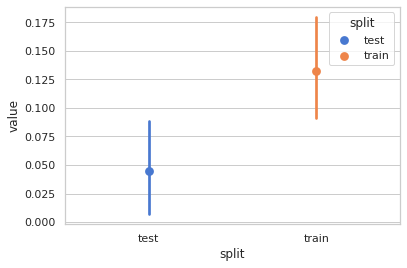

In [94]:
d = sem.agg_model.avg_folds()
sns.pointplot(data=d[d.metric=='r2'], x='split', y='value', hue='split')

In [96]:
d[d.unit_id==7]

unit_id metric  split     value
70        7    ar2   test  0.324072
71        7    ar2  train  0.377372
72        7    err   test  5.917162
73        7    err  train  5.781995
74        7  map_r   test  0.842621
75        7  map_r  train  0.930208
76        7  n_err   test  1.920954
77        7  n_err  train  1.877655
78        7     r2   test  0.326121
79        7     r2  train  0.377844

In [101]:
fold=3
unit=7
train_response, test_response = sem.agg_model.get_response_fold(fold)
train_features, test_features = sem.agg_model.get_features_fold(fold, unit)
train_response.shape, test_response.shape, train_features.shape, test_features.shape

((21, 27655), (21, 7000), (27655, 5), (7000, 5))

array([1.00867327, 1.00867327, 1.00867327, ..., 1.00867327, 1.00867327,
       1.00867327])

In [97]:
c = sem.get_coefs('agg')
cc = np.zeros( (sem.n_xval, sem.n_units, 5)) 
for fold in range(sem.n_xval):
    cc[fold] = np.array(list(c[fold]),dtype=np.float)

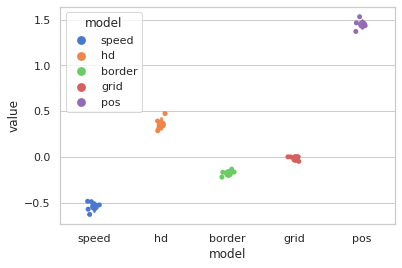

In [111]:

unit=7
for fold in range(sem.n_xval):
    cc[fold] = np.array(list(c[fold]),dtype=np.float)
d = pd.DataFrame(cc[:,unit,:], columns=['speed', 'hd', 'border', 'grid', 'pos']).melt(var_name='model')

sns.stripplot(data=d, x='model', y='value')
             
sns.pointplot(data=d, x='model', y='value', hue='model')

In [100]:
sem.scores[(sem.scores.unit_id==7) & (sem.scores.metric=='r2')]

unit_id metric  split     value   model
94          7     r2   test -0.011807   speed
95          7     r2  train  0.006696   speed
346         7     r2   test  0.004693      hd
347         7     r2  train  0.029598      hd
598         7     r2   test -0.022789      ha
599         7     r2  train  0.022278      ha
850         7     r2   test  0.070817  border
851         7     r2  train  0.125524  border
1102        7     r2   test  0.331292    grid
1103        7     r2  train  0.303261    grid
1354        7     r2   test  0.306909     pos
1355        7     r2  train  0.343551     pos

In [107]:
sem.grid_model.scores
#sem=sessisem.on_info.get_encoding_models()

fold unit_id metric  split      value
0       0       0     r2  train        NaN
1       0       0     r2   test        NaN
2       0       0    ar2  train        NaN
3       0       0    ar2   test        NaN
4       0       0    err  train        NaN
5       0       0    err   test        NaN
6       0       0  n_err  train        NaN
7       0       0  n_err   test        NaN
8       0       0  map_r  train        NaN
9       0       0  map_r   test        NaN
10      0       1     r2  train        NaN
11      0       1     r2   test        NaN
12      0       1    ar2  train        NaN
13      0       1    ar2   test        NaN
14      0       1    err  train        NaN
15      0       1    err   test        NaN
16      0       1  n_err  train        NaN
17      0       1  n_err   test        NaN
18      0       1  map_r  train        NaN
19      0       1  map_r   test        NaN
20      0       2     r2  train   0.030177
21      0       2     r2   test   0.018538
22      0       2    ar2  train   0.029440
23      0       2    ar2   test   0.015584
24      0       2    err  train   6.785688
25      0       2    err   test   6.259035
26      0       2  n_err  train   1.795762
27      0       2  n_err   test   1.704837
28      0       2  map_r  train   0.663851
29      0       2  map_r   test   0.511267
30      0       3     r2  train        NaN
31      0       3     r2   test        NaN
32      0       3    ar2  train        NaN
33      0       3    ar2   test        NaN
34      0       3    err  train        NaN
35      0       3    err   test        NaN
36      0       3  n_err  train        NaN
37      0       3  n_err   test        NaN
38      0       3  map_r  train        NaN
39      0       3  map_r   test        NaN
40      0       4     r2  train   0.101169
41      0       4     r2   test   0.005158
42      0       4    ar2  train   0.100486
43      0       4    ar2   test   0.002164
44      0       4    err  train   7.044451
45      0       4    err   test   6.092506
46      0       4  n_err  train   1.629597
47      0       4  n_err   test   1.603141
48      0       4  map_r  train   0.504879
49      0       4  map_r   test   0.491543
50      0       5     r2  train        NaN
51      0       5     r2   test        NaN
52      0       5    ar2  train        NaN
53      0       5    ar2   test        NaN
54      0       5    err  train        NaN
55      0       5    err   test        NaN
56      0       5  n_err  train        NaN
57      0       5  n_err   test        NaN
58      0       5  map_r  train        NaN
59      0       5  map_r   test        NaN
60      0       6     r2  train        NaN
61      0       6     r2   test        NaN
62      0       6    ar2  train        NaN
63      0       6    ar2   test        NaN
64      0       6    err  train        NaN
65      0       6    err   test        NaN
66      0       6  n_err  train        NaN
67      0       6  n_err   test        NaN
68      0       6  map_r  train        NaN
69      0       6  map_r   test        NaN
70      0       7     r2  train        NaN
71      0       7     r2   test        NaN
72      0       7    ar2  train        NaN
73      0       7    ar2   test        NaN
74      0       7    err  train        NaN
75      0       7    err   test        NaN
76      0       7  n_err  train        NaN
77      0       7  n_err   test        NaN
78      0       7  map_r  train        NaN
79      0       7  map_r   test        NaN
80      0       8     r2  train   0.010534
81      0       8     r2   test  -0.004991
82      0       8    ar2  train   0.009782
83      0       8    ar2   test  -0.008015
84      0       8    err  train   2.191747
85      0       8    err   test   1.866602
86      0       8  n_err  train   2.988078
87      0       8  n_err   test   2.926278
88      0       8  map_r  train   0.416706
89      0       8  map_r   test   0.299327
90      0       9     r2  train   0.022332
91      0       9     r2   test  -0.024474
92    

In [165]:
behav = session_info.get_track_data()
x, y, speed = behav['x'], behav['y'], behav['sp']
ha, hd = behav['ha'], behav['hd']
fr = session_info.get_fr()
spks = session_info.get_binned_spikes()

params = session_info.task_params

spatial_funcs = reload(spatial_funcs)

In [70]:
resp['sp'][0].shape

array([ True,  True,  True, ..., False, False, False])

In [189]:
units = [2]
fold = 1

#models = ['sp', 'hd', 'ha', 'border', 'grid', 'pos']
models = ['sp', 'hd',  'border', 'grid', 'pos']

n_models = len(models)

n_units = sem.n_units
samples = np.arange(sem.n_samples)
sp_valid_ids_bool = sem.valid_sp_samps

resp = {}
resp['true'] = sem.pos_model.get_response_fold(fold)
resp['sp'] = sem.speed_model.predict_model_fold(fold)
resp['hd']= sem.hd_model.predict_model_fold(fold)
resp['ha']= sem.ha_model.predict_model_fold(fold)
resp['pos'] = sem.pos_model.predict_model_fold(fold)
resp['grid'] = sem.grid_model.predict_model_fold(fold)
resp['border'] = sem.border_model.predict_model_fold(fold)

fold_train_ids_bool= sem.crossval_samp_ids!=fold
fold_train_samples = samples[fold_train_ids_bool]
fold_train_samples_sp = samples[fold_train_ids_bool & sp_valid_ids_bool]
within_fold_train_sp_ids_bool = np.in1d(fold_train_samples, fold_train_samples_sp)

fold_test_ids_bool= sem.crossval_samp_ids==fold
fold_test_samples = samples[fold_test_ids_bool]
fold_test_samples_sp = samples[fold_test_ids_bool & sp_valid_ids_bool]
within_fold_test_sp_ids_bool = np.in1d(fold_test_samples, fold_test_samples_sp)

Y_train = resp['true'][0]
Y_test = resp['true'][1]

n_fold_train_samps = Y_train.shape[1]
n_fold_test_samps = Y_test.shape[1]
for unit in units: #range(n_neurons):
    X_train = np.zeros((n_fold_train_samps, n_models))
    X_test = np.zeros((n_fold_test_samps, n_models))
    for mm, model in enumerate(models):
        if model in ['sp', 'hd','ha']:
            X_train[within_fold_train_sp_ids_bool,mm] = resp[model][0][unit]
            X_test[within_fold_test_sp_ids_bool,mm] = resp[model][1][unit]
        else:
            X_train[:, mm] = resp[model][0][unit]
            X_test[:, mm] = resp[model][1][unit]
    X_train[np.isnan(X_train)]=0
    X_test[np.isnan(X_test)]=0
    
    agg_model = lm.LinearRegression(normalize=False, fit_intercept=False).fit(X_train, Y_train[unit])
    
    Y_train_hat = agg_model.predict(X_train)
    Y_test_hat = agg_model.predict(X_test)
    coef_ = agg_model.coef_

In [197]:
rs.get_regression_metrics(Y_train[unit], Y_train_hat, 5)

{'r2': array([0.20745796]),
 'ar2': array([0.20731464]),
 'err': array([5.85556097]),
 'n_err': array([1.59722243])}

In [198]:
rs.get_regression_metrics(Y_test[unit], Y_test_hat, 5)

{'r2': array([0.15194667]),
 'ar2': array([0.1513404]),
 'err': array([6.91699184]),
 'n_err': array([1.68037983])}

<BarContainer object of 5 artists>

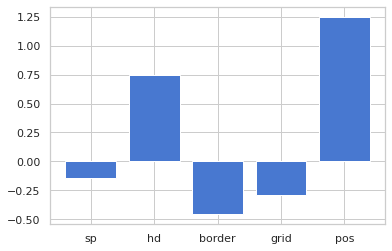

In [190]:
plt.bar(models, agg_model.coef_)

In [121]:
axis=0
mu = np.nanmean(X_train, axis=axis)
s = np.nanstd(X_train, axis=axis)

In [125]:
mu, s, np.std(Y_train)

(array([2.78885803, 2.73960836, 2.7639445 , 0.        , 3.19729112]),
 array([1.04050479e+00, 8.48387987e-01, 1.64535052e-12, 0.00000000e+00,
        4.94271291e-13]),
 22.74746526241964)

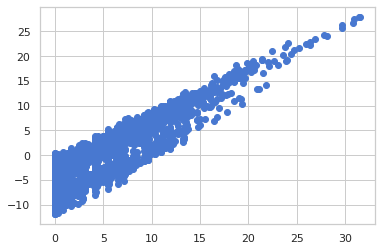

In [64]:
from sklearn import linear_model as lm


## 4/28/2021: check why so many grid models fail (still not done)

In [23]:
from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)
session = 'Li_OF_080218'
subject = session.split('_')[0]
session_info = si.SubjectSessionInfo(subject, session)

In [24]:
behav = session_info.get_track_data()
x, y, speed = behav['x'], behav['y'], behav['sp']
ha, hd = behav['ha'], behav['hd']
fr = session_info.get_fr()
spks = session_info.get_binned_spikes()
params = session_info.task_params


In [25]:
%%time
spatial_funcs = reload(spatial_funcs)
sem = spatial_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,neural_data=fr, **params)
scores = sem.get_all_models()

speed model completed. 4.19secs
hd model completed. 3.92secs
ha model completed. 4.17secs
border model completed. 2.27secs
grid model completed. 21.74secs
pos model completed. 16.62secs
CPU times: user 3min 57s, sys: 4min 6s, total: 8min 4s
Wall time: 52.9 s


In [27]:
scores[scores.model=='grid']

unit_id metric  split     value model
1152        0    ar2   test       NaN  grid
1153        0    ar2  train       NaN  grid
1154        0   coef   test       NaN  grid
1155        0   coef  train       NaN  grid
1156        0    err   test       NaN  grid
...       ...    ...    ...       ...   ...
1435       23  map_r  train  0.662145  grid
1436       23  n_err   test  2.415473  grid
1437       23  n_err  train  2.378041  grid
1438       23     r2   test  0.000495  grid
1439       23     r2  train  0.034945  grid

[288 rows x 5 columns]

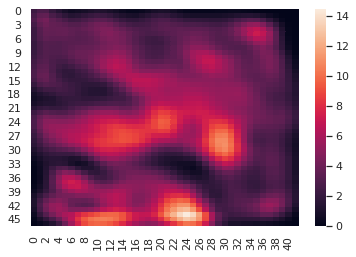

In [45]:
frmaps = session_info.get_fr_maps()
sns.heatmap(frmaps[4])

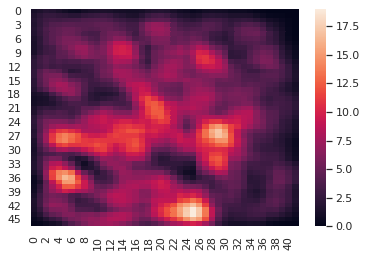

In [44]:
sns.heatmap(sem.spatial_map_function(fr[4], x, y))

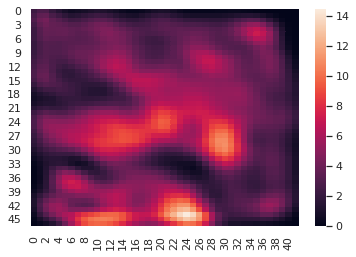

In [54]:
sns.heatmap(frmaps[4])

In [49]:
session_info.get_scores()

speed_score  speed_sig  hd_score    hd_ang  hd_sig  ha_score    ha_ang  \
0      0.159038       True  0.057361  1.922533   False  0.336267  3.777054   
1      0.066127       True  0.176872  2.194642    True  0.406633  4.184479   
2     -0.021447       True  0.210963  0.993545    True  0.454660  3.626315   
3      0.026658       True  0.306049  6.219854    True  0.461891  3.068843   
4      0.081155       True  0.290504  0.698455    True  0.548163  3.585065   
5     -0.028293       True  0.485740  6.095297    True  0.597696  2.880910   
6      0.207961       True  0.050210  4.071169   False  0.267170  3.894890   
7      0.366502       True  0.034409  4.165648    True  0.268617  3.623879   
8     -0.006203      False  0.035677  2.699298    True  0.321600  3.842292   
9      0.223872       True  0.039064  1.812383    True  0.330245  3.949759   
10     0.068344       True  0.038667  1.125003   False  0.337957  3.646284   
11     0.042397       True  0.119624  1.049420    True  0.385946  3.545703   
12     0.000934       True  0.265554  3.967004    True  0.096801  3.551457   
13     0.097330       True  0.210404  3.838717    True  0.172241  4.045839   
14    -0.014387       True  0.171668  1.805980    True  0.483059  3.961060   
15    -0.058911       True  0.410938  1.874525    True  0.642219  4.134753   
16     0.004003       True  0.214714  1.646458    True  0.519773  4.011667   
17     0.019072      False  0.046091  2.806737    True  0.333907  3.800185   
18     0.051098       True  0.069743  1.465868    True  0.353802  3.794123   
19    -0.012577       True  0.101082  2.845479    True  0.358105  4.267878   
20     0.041915       True  0.073205  5.802258    True  0.282406  3.634014   
21     0.161109       True  0.032488  3.382848    True  0.262402  3.982937   
22     0.020008       True  0.055603  1.373199   False  0.390474  3.825514   
23     0.100955       True  0.252322  6.097655    True  0.380257  3.076184   

    ha_sig  border_score  border_sig  grid_score  grid_sig  grid_scale  \
0     True      0.402965       False         NaN     False         NaN   
1     True      0.187760       False   -0.123302     False    9.072244   
2     True      0.406112       False         NaN     False         NaN   
3     True      0.320585       False         NaN     False         NaN   
4     True      0.085066        True   -0.034141     False   16.226145   
5     True      0.325073       False         NaN     False         NaN   
6     True      0.295483       False         NaN     False         NaN   
7     True      0.429283       False         NaN     False         NaN   
8     True      0.362465       False         NaN     False         NaN   
9     True     -0.602039        True         NaN     False         NaN   
10    True      0.348956       False         NaN     False         NaN   
11   False      0.166346       False    0.000946     False   34.929911   
12    True      0.360166       False   -0.053473     False   25.291729   
13    True      0.387873       False         NaN     False         NaN   
14    True      0.381310       False         NaN     False         NaN   
15    True      0.409275       False         NaN     False         NaN   
16    True     -0.174318       False   -0.086037     False   19.232756   
17    True      0.334011        True         NaN     False         NaN   
18   False      0.303160        True         NaN     False         NaN   
19   False      0.356372       False         NaN     False         NaN   
20    True      0.136283        True         NaN     False         NaN   
21    True      0.288891       False         NaN     False         NaN   
22    True      0.210989        True         NaN     False         NaN   
23    True     -0.055050       False   -0.113545     False   30.284877   

    grid_phase  stability_corr  stability_sig  
0          NaN        0.147973          False  
1     0.174672        0.479051           True  
2          NaN        0.274716          False  
3         

In [58]:
47/42*0.28

0.31333333333333335

## 4/25/2021: bug in position model

In [15]:
from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)
subject = 'Li'
session = 'Li_OF_070618'
session_info = si.SubjectSessionInfo(subject, session)

In [16]:
sem = session_info.get_encoding_model('pos')

In [19]:
tbl = sem.pos_model.avg_folds()

In [22]:
tbl[ (tbl.metric=='r2') & (tbl.split=='test')]

unit_id metric split     value
10         0     r2  test  0.010733
22         1     r2  test -0.005459
34         2     r2  test  0.012321
46         3     r2  test  0.122404
58         4     r2  test  0.031019
70         5     r2  test  0.040779
82         6     r2  test  0.017285
94         7     r2  test  0.001089
106        8     r2  test -0.001116
118        9     r2  test -0.119993
130       10     r2  test  0.020713
142       11     r2  test  0.197221
154       12     r2  test  0.081676
166       13     r2  test  0.048736
178       14     r2  test  0.126583
190       15     r2  test  0.078689
202       16     r2  test  0.010962
214       17     r2  test -0.000474

## 4/22/21: generalization of new spatial methods test

In [5]:
from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)
subject = 'Li'
session = 'Li_OF_070618'
session_info = si.SubjectSessionInfo(subject, session)

In [6]:
session_info.get_scores(overwrite=1)

Open Field Score Metrics do not exits or overwrite=True, creating them.
Speed Score Completed: 11.71s
Head Dir Score Completed: 4.96s
Head Ang Score Completed: 4.97s
Border Score Completed: 9.67s
Grid Score Completed: 4.43s
Spatial Stability Score Completed: 2.76s


speed_score  speed_sig   hd_score     hd_ang hd_sig   ha_score   ha_ang  \
0      0.118436       True   0.209651   0.839403   True   0.443088  3.68474   
1      0.097960       True    0.37438    3.54815   True  0.0777727  6.24086   
2      0.053116       True  0.0694525    4.58763   True   0.203962  3.37861   
3      0.055227       True  0.0859657    1.05172   True    0.39709  3.66385   
4      0.110205       True   0.183587    5.39284   True   0.296882  2.74333   
5      0.088773       True   0.393086    3.30932   True   0.186161  4.80567   
6      0.018331       True   0.240234    3.39963   True   0.041687  4.64206   
7      0.063166       True  0.0619746    4.02064   True   0.186474  3.14475   
8      0.069243       True  0.0520222    5.23697   True   0.237189  3.28348   
9      0.118515       True  0.0339798    2.34428   True   0.382869  3.60295   
10    -0.008741       True  0.0673734    4.98499   True   0.314941  3.37868   
11    -0.013160       True   0.281986    3.64943   True   0.143853  0.11781   
12     0.004946       True  0.0317417    5.66681   True   0.282474  3.44086   
13     0.019069       True  0.0565639    4.09021   True   0.163202  3.47323   
14     0.061433       True  0.0400278    4.54743   True   0.164375  3.37513   
15     0.133739       True   0.229389  0.0640338   True   0.404213  3.18391   
16     0.010075      False  0.0575521    3.20189   True   0.237524   3.7739   
17     0.087055       True  0.0570236     6.1075   True   0.267166  3.33391   

   ha_sig  border_score  border_sig  grid_score  grid_sig  grid_scale  \
0    True      0.374709       False    0.130686     False   26.762735   
1    True      0.434972       False   -0.033243     False   21.517274   
2    True      0.408713       False         NaN     False         NaN   
3    True      0.325856       False         NaN     False         NaN   
4    True      0.286080       False    0.214635      True   15.742264   
5    True     -0.179026        True    0.657669      True   20.981764   
6    True      0.438389       False   -0.136478     False   23.899493   
7    True      0.347395       False   -0.250395     False   17.053538   
8    True      0.414940       False         NaN     False         NaN   
9    True      0.353644       False         NaN     False         NaN   
10   True      0.294346       False   -0.136537     False   32.867224   
11   True      0.309685       False         NaN     False         NaN   
12   True      0.540995        True         NaN     False         NaN   
13   True      0.347132       False   -0.108479      True   26.926343   
14   True      0.285903        True         NaN     False         NaN   
15   True      0.229938        True         NaN     False         NaN   
16   True      0.397531       False         NaN     False         NaN   
17   True      0.408372       False   -0.171351     False   31.087702   

    grid_phase  stability_corr  stability_sig  
0     0.717322        0.518217          False  
1     0.965252        0.411376          False  
2          NaN        0.629420          False  
3          NaN        0.755436           True  
4     0.183111        0.515353          False  
5     0.430693        0.397524          False  
6     0.702257        0.796396           True  
7     0.024385        0.425627          False  
8          NaN        0.588723          False  
9          NaN        0.559153          False  
10    0.312492        0.604110          False  
11         NaN        0.903120           True  
12         NaN        0.760290           True  
13    1.030377        0.821430           True  
14         NaN        0.824598           True  
15         NaN        0.777120           True  
16         NaN        0.551008          False  
17    0.101689        0.573825          False

In [5]:
tbl = session_info.get_encoding_models_scores()

In [11]:
tbl[(tbl.model=='grid')& (tbl.unit_id==5)]

NameError: name 'tbl' is not defined

In [7]:
sem = session_info.get_encoding_model('grid')

In [12]:
unit=5
a=np.array([spatial_funcs.compute_grid_score(sem.grid_model.get_spatial_map_fold(fold)[0][unit])[0] for fold in range(5)])

In [14]:
a.mean()

0.2877717687002463

In [6]:
tbl = sem.grid_model.scores
tbl[(tbl.unit_id==13)&(tbl.metric=='coef')]

fold unit_id metric  split     value
1626    0      13   coef  train  0.172854
1627    0      13   coef   test  0.172854
1690    1      13   coef  train  0.493450
1691    1      13   coef   test  0.493450
1754    2      13   coef  train  0.327003
1755    2      13   coef   test  0.327003
1818    3      13   coef  train -0.107507
1819    3      13   coef   test -0.107507
1882    4      13   coef  train  0.377971
1883    4      13   coef   test  0.377971

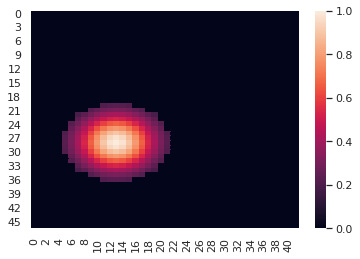

In [10]:
sns.heatmap(sem.grid_model.grid_fields[1,13].squeeze())

In [11]:
fold=1
unit=13
resp = sem.grid_model.get_response_fold(fold)[0][unit]
x, y = sem.grid_model.x_pos[sem.crossval_samp_ids!=fold], sem.grid_model.y_pos[sem.crossval_samp_ids!=fold]


In [12]:
f = spatial_funcs.get_grid_fields(resp,x,y,x_bin_edges=sem.params['x_bin_edges_'], y_bin_edges=sem.params['y_bin_edges_'])

In [14]:
rm = spatial_funcs.firing_rate_2_rate_map(resp,x,y,x_bin_edges=sem.params['x_bin_edges_'], y_bin_edges=sem.params['y_bin_edges_'])
nrm = spatial_funcs.sigmoid(rm/rm.max(), center=0.5, slope=10) 

In [20]:
fields_map, n_fields = spatial_funcs.get_map_fields(nrm, thr=0.1, min_field_size=10)
thr_rm = (fields_map>=0)*nrm

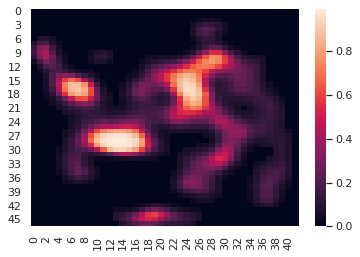

In [23]:
sns.heatmap(thr_rm)

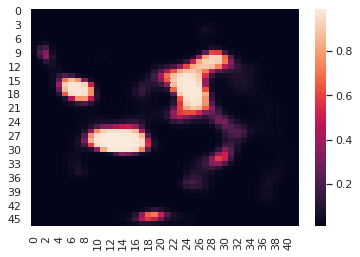

In [24]:
sns.heatmap(spatial_funcs.sigmoid(thr_rm,center=0.5, slope=10))

In [163]:
spatial_funcs=reload(spatial_funcs)
spatial_funcs.compute_grid_score(thr_rm, apply_sigmoid=False, find_fields=False, )

(0.022435952506296042,
 14.55741697815021,
 0.15037142800713443,
 array([[  5.5,   9.5],
        [ -6.5, -10.5],
        [-10.5,  10.5],
        [  9.5, -11.5],
        [ 16.5,  -2.5],
        [-17.5,   1.5]]))

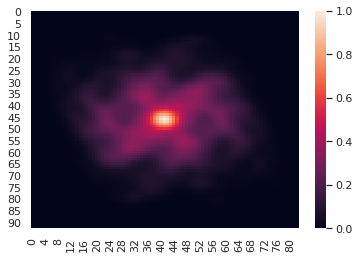

In [70]:
ac=rs.compute_autocorr_2d(thr_rm)
ac=ac/np.max(ac)
sns.heatmap(ac)

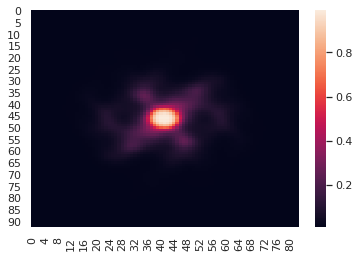

In [71]:
acn = spatial_funcs.sigmoid(ac,0.5,10)
sns.heatmap(acn)

In [50]:
a_fields_map, a_n_fields = spatial_funcs.get_map_fields(acn, thr=0.1, min_field_size=10)


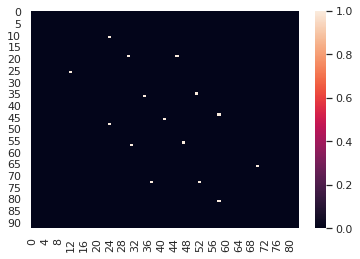

In [133]:
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
def detect_img_peaks(image, background_thr=0.01):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(2,2)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image<background_thr)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max * ~eroded_background

    return detected_peaks
ac_p = detect_img_peaks(ac)
sns.heatmap(ac_p)

In [104]:
labeled_ac_p, n_ac_p = ndimage.label(ac_p)
labeled_ac_p -= 1
field_locs = ndimage.measurements.center_of_mass(ac_p, labeled_ac_p, np.arange(n_ac_p))
field_locs = np.array(field_locs)
field_locs

array([[11., 24.],
       [19., 30.],
       [19., 45.],
       [26., 12.],
       [35., 51.],
       [36., 35.],
       [44., 58.],
       [46., 41.],
       [48., 24.],
       [56., 47.],
       [57., 31.],
       [66., 70.],
       [73., 37.],
       [73., 52.],
       [81., 58.]])

In [166]:
fl2 = spatial_funcs.Points2D(field_locs[:,1], field_locs[:,0])
ac_map_h,ac_map_w = ac.shape
center = spatial_funcs.Points2D(ac_map_w/2,ac_map_h/2)
fdists = fl2-center
fdists_s = np.argsort(fdists.r)
fdists2 = fdists[fdists_s[1:7]]

In [170]:
from skimage import draw
from skimage.transform import rotate


In [196]:
radix_range = np.array([0.5,2]) * np.mean(fdists2.r)

# mask the region
mask_radix_out = np.zeros_like(ac)
mask_radix_in = np.zeros_like(ac)

r, c = draw.disk((center.xy[0, 1], center.xy[0, 0]), radix_range[1], shape=(ac_map_h, ac_map_w))
mask_radix_out[r, c] = 1

r, c = draw.disk((center.xy[0, 1], center.xy[0, 0]), radix_range[0], shape=(ac_map_h, ac_map_w))
mask_radix_in[r, c] = 1

mask_ac = mask_radix_out - mask_radix_in

# rotate fields and get grid score
unrotated_masked_ac = acn[mask_ac == 1]
rotations = np.arange(30, 151, 30)  # rotations 30, 60, 90, 120, 150
corrs = np.zeros(len(rotations))
for i, angle in enumerate(rotations):
    
    #rotated_masked_ac = rotate(acn, angle)
    rotated_masked_ac = rotate(ac, angle)[mask_ac == 1]
    corrs[i] = rs.pearson(unrotated_masked_ac, rotated_masked_ac)
    #corrs[i] = rs.pearson(rotated_masked_ac.flatten(), ac.flatten())
gs = np.mean(corrs[1::2]) - np.mean(corrs[::2])

In [197]:
corrs, gs

(array([0.6845783 , 0.7081055 , 0.74296443, 0.70239213, 0.66788273]),
 0.006773662722963092)

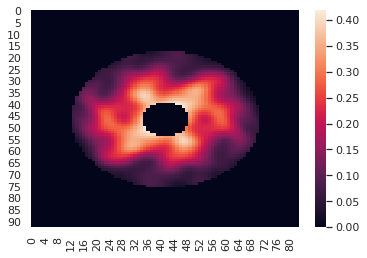

In [178]:
sns.heatmap(ac*(mask_ac==1))

[0.80898317 0.81401448 0.81738759 0.81482868 0.81159801]


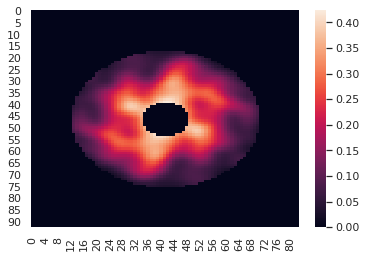

In [195]:
angle=30, 
sns.heatmap(rotate(ac, angle)*(mask_ac==1))
print(corrs)

In [162]:
angs= np.array(fdists2.ang)
angs[angs>np.pi] = np.mod(angs[angs>np.pi], np.pi)-np.pi
angs, fdists2.ang, np.min(np.abs(angs))

(array([ 1.04600056, -2.12510382,  2.35619449, -0.88034987, -0.15037143,
         3.05608736]),
 array([1.04600056, 4.15808148, 2.35619449, 5.40283544, 6.13281388,
        3.05608736]),
 0.15037142800713443)

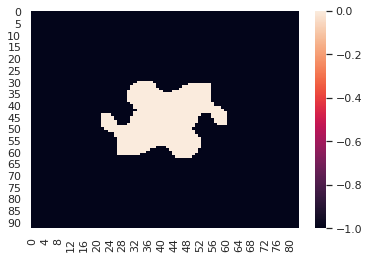

In [51]:
sns.heatmap(a_fields_map)

In [8]:
o = session_info.get_encoding_model('pos')

(array([[12.65277144, 12.65277144, 12.65277144, ...,  7.56335667,
          7.56335667,  7.56335667],
        [ 8.46101082,  8.46101082,  8.46101082, ...,  9.40113988,
          9.40113988,  9.40113988],
        [50.81066749, 50.81066749, 50.81066749, ..., 48.64832448,
         48.64832448, 48.64832448],
        ...,
        [ 8.91212147,  8.91212147,  8.91212147, ...,  8.36387381,
          8.36387381,  8.36387381],
        [12.61275136, 12.61275136, 12.61275136, ...,  8.94980887,
          8.94980887,  8.94980887],
        [ 1.65848508,  1.65848508,  1.65848508, ...,  1.83486253,
          1.83486253,  1.83486253]]),
 array([[17.10362419, 15.285302  , 15.285302  , ..., 10.6679818 ,
         10.6679818 , 10.11035345],
        [ 7.38352471,  7.50356277,  7.50356277, ...,  6.6688312 ,
          6.6688312 ,  6.06264465],
        [41.90457115, 43.45834994, 43.45834994, ..., 46.52193461,
         46.52193461, 46.31203758],
        ...,
        [10.96375939, 10.69493617, 10.69493617, ..., 1

In [4]:
a=np.empty((2,2), dtype=object)
a

array([[None, None],
       [None, None]], dtype=object)

In [7]:
a[0,1]=1
a[0,0] is None

True

## 4/13/21: spatial function mods to generalize aspects of encoding models


In [32]:
from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)
subject = 'Li'
session = 'Li_OF_070618'
session_info = si.SubjectSessionInfo(subject, session)

In [33]:
behav = session_info.get_track_data()
x, y, speed = behav['x'], behav['y'], behav['sp']
ha, hd = behav['ha'], behav['hd']
fr = session_info.get_fr()
spks = session_info.get_binned_spikes()

params = session_info.task_params

In [39]:
spatial_funcs = reload(spatial_funcs)
f = spatial_funcs.get_spatial_map_function('spikes', **params)
f2 =spatial_funcs.get_spatial_map_function('fr', **params)

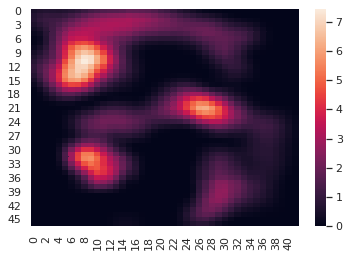

In [37]:
sns.heatmap(f(spks[5], behav['x'], behav['y']))

In [51]:
spatial_funcs = reload(spatial_funcs)
spatial_funcs.compute_grid_score(f2(fr[5], behav['x'], behav['y']))

(0.6576692583999644,
 20.981763963975066,
 0.430692511386508,
 array([[ 18.5,   8.5],
        [  1.5,  20.5],
        [ 16.5, -12.5],
        [-17.5,  11.5],
        [ -2.5, -21.5],
        [-19.5,  -9.5]]))

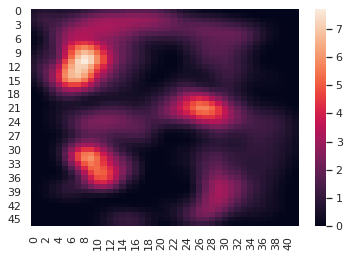

In [48]:
2(fr[5], behav['x'], behav['y'])

In [ ]:
session_info.get_encoding_models_sc

In [348]:
%%time
spatial_funcs = reload(spatial_funcs)
sem = spatial_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,fr[4:6],time_step=0.02, data_type='fr', norm_resp=None)

CPU times: user 33.7 ms, sys: 1.12 ms, total: 34.8 ms
Wall time: 33.2 ms


In [351]:
sem.get_all_models()

speed model completed. 0.79secs
hd model completed. 0.71secs
ha model completed. 0.69secs
border model completed. 0.52secs
grid model completed. 0.80secs
pos model completed. 2.85secs


unit_id metric  split      value   model
0          0    ar2   test   0.008858   speed
1          0    ar2  train   0.018073   speed
2          0   coef   test   0.896235   speed
3          0   coef  train   0.896235   speed
4          0    err   test  10.077607   speed
5          0    err  train  10.077714   speed
6          0  map_r   test   0.668936   speed
7          0  map_r  train   0.539218   speed
8          0  n_err   test   1.950972   speed
9          0  n_err  train   1.946799   speed
10         0     r2   test   0.012950   speed
11         0     r2  train   0.019085   speed
12         1    ar2   test  -0.005913   speed
13         1    ar2  train   0.007983   speed
14         1   coef   test   0.604291   speed
15         1   coef  train   0.604291   speed
16         1    err   test   7.772479   speed
17         1    err  train   7.767706   speed
18         1  map_r   test   0.463350   speed
19         1  map_r  train   0.361884   speed
20         1  n_err   test   2.906768   speed
21         1  n_err  train   2.901816   speed
22         1     r2   test  -0.001761   speed
23         1     r2  train   0.009005   speed
24         0    ar2   test   0.020199      hd
25         0    ar2  train   0.033073      hd
26         0   coef   test   0.695106      hd
27         0   coef  train   0.695106      hd
28         0    err   test  10.022178      hd
29         0    err  train  10.000900      hd
30         0  map_r   test   0.708116      hd
31         0  map_r  train   0.614208      hd
32         0  n_err   test   1.940279      hd
33         0  n_err  train   1.931964      hd
34         0     r2   test   0.023933      hd
35         0     r2  train   0.033993      hd
36         1    ar2   test   0.031036      hd
37         1    ar2  train   0.050434      hd
38         1   coef   test   0.792526      hd
39         1   coef  train   0.792526      hd
40         1    err   test   7.621019      hd
41         1    err  train   7.599594      hd
42         1  map_r   test   0.584408      hd
43         1  map_r  train   0.567108      hd
44         1  n_err   test   2.854968      hd
45         1  n_err  train   2.839248      hd
46         1     r2   test   0.034727      hd
47         1     r2  train   0.051337      hd
48         0    ar2   test   0.037353      ha
49         0    ar2  train   0.053943      ha
50         0   coef   test   0.663737      ha
51         0   coef  train   0.663737      ha
52         0    err   test   9.934342      ha
53         0    err  train   9.892367      ha
54         0  map_r   test   0.745291      ha
55         0  map_r  train   0.721590      ha
56         0  n_err   test   1.923446      ha
57         0  n_err  train   1.911009      ha
58         0     r2   test   0.041021      ha
59         0     r2  train   0.054843      ha
60         1    ar2   test   0.008368      ha
61         1    ar2  train   0.040265      ha
62         1   coef   test   0.605165      ha
63         1   coef  train   0.605165      ha
64         1    err   test   7.714444      ha
65         1    err  train   7.640492      ha
66         1  map_r   test   0.509240      ha
67         1  map_r  train   0.537668      ha
68         1  n_err   test   2.887655      ha
69         1  n_err  train   2.854379      ha
70         1     r2   test   0.012147      ha
71         1     r2  train   0.041178      ha
72         0    ar2   test  -0.000830  border
73         0    ar2  train   0.005564  border
74         0   coef   test   2.274008  border
75         0   coef  train   2.274008  border
76         0    err   test  10.093334  border
77         0    err  train  10.097106  border
78         0  map_r   test   0.672604  border
79         0  map_r  train   0.649542  border
80         0  n_err   test   1.980783  border
81         0  n_err  train   1.976270  border
82         0     r2   test  -0.000355  border
83         0     r2  train   0.005682  border
84         1    ar2   test   0.006368  border
85         1    ar2  train   0.014799  border
86 

In [353]:
sem.scores[sem.scores.metric=='coef']

unit_id metric  split     value   model
2          0   coef   test  0.896235   speed
3          0   coef  train  0.896235   speed
14         1   coef   test  0.604291   speed
15         1   coef  train  0.604291   speed
26         0   coef   test  0.695106      hd
27         0   coef  train  0.695106      hd
38         1   coef   test  0.792526      hd
39         1   coef  train  0.792526      hd
50         0   coef   test  0.663737      ha
51         0   coef  train  0.663737      ha
62         1   coef   test  0.605165      ha
63         1   coef  train  0.605165      ha
74         0   coef   test  2.274008  border
75         0   coef  train  2.274008  border
86         1   coef   test  0.010721  border
87         1   coef  train  0.010721  border
98         0   coef   test  0.655186    grid
99         0   coef  train  0.655186    grid
110        1   coef   test  1.669778    grid
111        1   coef  train  1.669778    grid
122        0   coef   test  0.637046     pos
123        0   coef  train  0.637046     pos
134        1   coef   test  0.816417     pos
135        1   coef  train  0.816417     pos

In [350]:
s = sem.pos_model.scores
s[s.metric=='coef']

fold unit_id metric  split     value
100    0       0   coef  train  0.632808
101    0       0   coef   test  0.632808
102    1       0   coef  train  0.628870
103    1       0   coef   test  0.628870
104    2       0   coef  train  0.650537
105    2       0   coef   test  0.650537
106    3       0   coef  train  0.642718
107    3       0   coef   test  0.642718
108    4       0   coef  train  0.630295
109    4       0   coef   test  0.630295
110    0       1   coef  train  0.804612
111    0       1   coef   test  0.804612
112    1       1   coef  train  0.822555
113    1       1   coef   test  0.822555
114    2       1   coef  train  0.829318
115    2       1   coef   test  0.829318
116    3       1   coef  train  0.828350
117    3       1   coef   test  0.828350
118    4       1   coef  train  0.797248
119    4       1   coef   test  0.797248

In [341]:
c = sem.pos_model.feature_inverse(c[0,1]).reshape(47,42)

array([[-0.01848967, -0.0235638 , -0.02569372, ..., -0.01015659,
        -0.00754285, -0.00505656],
       [-0.02985057, -0.03812872, -0.04179165, ..., -0.00860772,
        -0.0056704 , -0.00337252],
       [-0.04105991, -0.0521181 , -0.05664783, ..., -0.00428003,
        -0.00132437,  0.00022222],
       ...,
       [-0.00656843, -0.0093307 , -0.0116532 , ...,  0.00281041,
         0.00838304,  0.00931859],
       [-0.00567399, -0.0075425 , -0.00865759, ...,  0.00228253,
         0.00745393,  0.00841297],
       [-0.00346793, -0.0042565 , -0.00430389, ...,  0.00063238,
         0.0048782 ,  0.00590547]])

In [155]:
sem.get_speed_model()

In [156]:
sem.get_hd_model()

In [159]:
sem.get_pos_model()

In [160]:
sem.get_grid_model()

In [316]:
sem.get_border_model()

In [242]:
sem.border_model.avg_folds()

unit_id metric  split      value
0         0    ar2   test  -0.000830
1         0    ar2  train   0.005564
2         0    err   test  10.093334
3         0    err  train  10.097106
4         0  map_r   test   0.672604
5         0  map_r  train   0.649542
6         0  n_err   test   1.980783
7         0  n_err  train   1.976270
8         0     r2   test  -0.000355
9         0     r2  train   0.005682
10        1    ar2   test   0.006368
11        1    ar2  train   0.014799
12        1    err   test   7.672844
13        1    err  train   7.654986
14        1  map_r   test   0.505894
15        1  map_r  train   0.440098
16        1  n_err   test   2.896357
17        1  n_err  train   2.888927
18        1     r2   test   0.006839
19        1     r2  train   0.014916

In [254]:
%%time
spatial_funcs = reload(spatial_funcs)
sem = spatial_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,fr[4:6],time_step=0.02, data_type='fr', norm_resp=None)
sem.get_all_models()

pos model completed. 2.83secs
speed model completed. 0.80secs
ha model completed. 0.71secs
hd model completed. 0.69secs
border model completed. 0.60secs
grid model completed. 0.83secs
CPU times: user 47.4 s, sys: 53.2 s, total: 1min 40s
Wall time: 6.5 s


unit_id metric  split   model      value
0         0    ar2   test     pos   0.019582
1         0    ar2  train     pos   0.047150
2         0    err   test     pos   9.934217
3         0    err  train     pos   9.869940
4         0  map_r   test     pos   0.718957
5         0  map_r  train     pos   0.786615
6         0  n_err   test     pos   1.949545
7         0  n_err  train     pos   1.931809
8         0     r2   test     pos   0.031019
9         0     r2  train     pos   0.049923
10        1    ar2   test     pos   0.029457
11        1    ar2  train     pos   0.062555
12        1    err   test     pos   7.540065
13        1    err  train     pos   7.456568
14        1  map_r   test     pos   0.571196
15        1  map_r  train     pos   0.806684
16        1  n_err   test     pos   2.846317
17        1  n_err  train     pos   2.814112
18        1     r2   test     pos   0.040779
19        1     r2  train     pos   0.065283
20        0    ar2   test   speed   0.008858
21        0    ar2  train   speed   0.018073
22        0    err   test   speed  10.077607
23        0    err  train   speed  10.077714
24        0  map_r   test   speed   0.668936
25        0  map_r  train   speed   0.539218
26        0  n_err   test   speed   1.950972
27        0  n_err  train   speed   1.946799
28        0     r2   test   speed   0.012950
29        0     r2  train   speed   0.019085
30        1    ar2   test   speed  -0.005913
31        1    ar2  train   speed   0.007983
32        1    err   test   speed   7.772479
33        1    err  train   speed   7.767706
34        1  map_r   test   speed   0.463350
35        1  map_r  train   speed   0.361884
36        1  n_err   test   speed   2.906768
37        1  n_err  train   speed   2.901816
38        1     r2   test   speed  -0.001761
39        1     r2  train   speed   0.009005
40        0    ar2   test      ha   0.037353
41        0    ar2  train      ha   0.053943
42        0    err   test      ha   9.934342
43        0    err  train      ha   9.892367
44        0  map_r   test      ha   0.745291
45        0  map_r  train      ha   0.721590
46        0  n_err   test      ha   1.923446
47        0  n_err  train      ha   1.911009
48        0     r2   test      ha   0.041021
49        0     r2  train      ha   0.054843
50        1    ar2   test      ha   0.008368
51        1    ar2  train      ha   0.040265
52        1    err   test      ha   7.714444
53        1    err  train      ha   7.640492
54        1  map_r   test      ha   0.509240
55        1  map_r  train      ha   0.537668
56        1  n_err   test      ha   2.887655
57        1  n_err  train      ha   2.854379
58        1     r2   test      ha   0.012147
59        1     r2  train      ha   0.041178
60        0    ar2   test      hd   0.020199
61        0    ar2  train      hd   0.033073
62        0    err   test      hd  10.022178
63        0    err  train      hd  10.000900
64        0  map_r   test      hd   0.708116
65        0  map_r  train      hd   0.614208
66        0  n_err   test      hd   1.940279
67        0  n_err  train      hd   1.931964
68        0     r2   test      hd   0.023933
69        0     r2  train      hd   0.033993
70        1    ar2   test      hd   0.031036
71        1    ar2  train      hd   0.050434
72        1    err   test      hd   7.621019
73        1    err  train      hd   7.599594
74        1  map_r   test      hd   0.584408
75        1  map_r  train      hd   0.567108
76        1  n_err   test      hd   2.854968
77        1  n_err  train      hd   2.839248
78        1     r2   test      hd   0.034727
79        1     r2  train      hd   0.051337
80        0    ar2   test  border  -0.000830
81        0    ar2  train  border   0.005564
82        0    err   test  border  10.093334
83        0    err  train  border  10.097106
84        0  map_r   test  border   0.672604
85        0  map_r  train  border   0.649542
86        0  n_err   test  border   1.980783
87        0  n_err  train  border   1.976270

In [249]:
sem.scores.reset_index(drop=True, inplace=True)

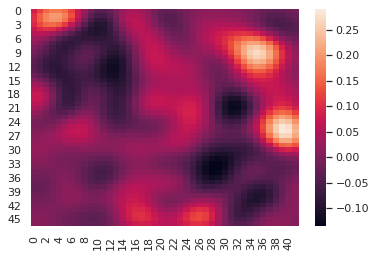

In [258]:
sns.heatmap(sem.pos_model.feature_inverse(sem.pos_model.models[0][0].coef_).reshape(47,42))


In [190]:
fold=3
test_bool_ids = sem.crossval_samp_ids==fold
sp_valid_samps = sem.valid_sp_samps


resp = {}
resp['true'] = sem.speed_model.get_response_fold(fold)[1]
resp['sp'] = sem.speed_model.predict_model_fold(fold)[1]
resp['hd']= sem.hd_model.predict_model_fold(fold)[1]
resp['pos'] = sem.pos_model.predict_model_fold(fold)[1]
resp['grid'] = sem.grid_model.predict_model_fold(fold)[1]
resp['border'] = sem.border_model.predict_model_fold(fold)[1]

sm = {}
sm['true'] = sem.speed_model.get_spatial_map_fold(fold)[0]
sm['sp'] = sem.speed_model.get_predicted_spatial_map_fold(fold)[0]
sm['hd']= sem.hd_model.get_predicted_spatial_map_fold(fold)[0]
sm['pos'] = sem.pos_model.get_predicted_spatial_map_fold(fold)[0]
sm['grid'] = sem.grid_model.get_predicted_spatial_map_fold(fold)[0]
sm['border'] = sem.border_model.get_predicted_spatial_map_fold(fold)[0]

In [280]:
coefs = sem.border_model.models[0][0].coef_
b = np.max(coefs[:4]), 
c = coefs[4]
np.max(coefs[:4]-c)

2.253550855877454

In [291]:
coefs = sem.grid_model.models[3][1].coef_
np.mean(coefs)/np.std(coefs)

2.0119729308602357

In [317]:
sem.border_model.scores

fold unit_id metric  split        value
0      0       0     r2  train   0.00609073
1      0       0     r2   test  0.000990589
2      0       0    ar2  train   0.00597192
3      0       0    ar2   test  0.000536246
4      0       0    err  train       9.9623
5      0       0    err   test      10.6218
6      0       0  n_err  train       1.9407
7      0       0  n_err   test      2.11508
8      0       0  map_r  train     0.695805
9      0       0  map_r   test     0.539716
10     0       1     r2  train    0.0140467
11     0       1     r2   test    0.0151212
12     0       1    ar2  train    0.0139288
13     0       1    ar2   test    0.0146733
14     0       1    err  train      7.67172
15     0       1    err   test      7.60611
16     0       1  n_err  train       2.8649
17     0       1  n_err   test      2.99128
18     0       1  map_r  train      0.45104
19     0       1  map_r   test      0.43442
20     1       0     r2  train   0.00380626
21     1       0     r2   test   0.00350746
22     1       0    ar2  train   0.00368718
23     1       0    ar2   test   0.00305426
24     1       0    err  train      9.94646
25     1       0    err   test      10.6884
26     1       0  n_err  train      2.00253
27     1       0  n_err   test      1.89013
28     1       0  map_r  train     0.582426
29     1       0  map_r   test     0.849542
30     1       1     r2  train    0.0112832
31     1       1     r2   test    0.0254012
32     1       1    ar2  train    0.0111651
33     1       1    ar2   test    0.0249579
34     1       1    err  train      7.82546
35     1       1    err   test       6.9959
36     1       1  n_err  train      2.93123
37     1       1  n_err   test      2.71818
38     1       1  map_r  train     0.454672
39     1       1  map_r   test     0.723336
40     2       0     r2  train   0.00564019
41     2       0     r2   test   0.00156999
42     2       0    ar2  train    0.0055218
43     2       0    ar2   test   0.00110904
44     2       0    err  train      10.1551
45     2       0    err   test      9.90167
46     2       0  n_err  train      1.98247
47     2       0  n_err   test      1.95587
48     2       0  map_r  train     0.657526
49     2       0  map_r   test     0.798945
50     2       1     r2  train    0.0168777
51     2       1     r2   test   -0.0117417
52     2       1    ar2  train    0.0167607
53     2       1    ar2   test   -0.0122088
54     2       1    err  train      7.87135
55     2       1    err   test      6.78734
56     2       1  n_err  train      2.83388
57     2       1  n_err   test      3.15096
58     2       1  map_r  train     0.445865
59     2       1  map_r   test     0.631655
60     3       0     r2  train   0.00669969
61     3       0     r2   test  -0.00613871
62     3       0    ar2  train   0.00658374
63     3       0    ar2   test  -0.00664208
64     3       0    err  train      10.1452
65     3       0    err   test      9.93216
66     3       0  n_err  train      1.96191
67     3       0  n_err   test      2.04825
68     3       0  map_r  train     0.644766
69     3       0  map_r   test     0.605323
70     3       1     r2  train     0.014245
71     3       1     r2   test   0.00863932
72     3       1    ar2  train    0.0141299
73     3       1    ar2   test   0.00814334
74     3       1    err  train      7.53683
75     3       1    err   test      8.17546
76     3       1  n_err  train      2.91923
77     3       1  n_err   test      2.78015
78     3       1  map_r  train     0.385075
79     3       1  map_r   test     0.473019
80     4       0     r2  train    0.0061708
81     4       0     r2   test  -0.00170461
82     4       0    ar2  train   0.00605478
83     4       0    ar2   test  -0.00220577
84     4       0    err  train      10.2765
85     4       0    err   test       9.3227
86     4       0  n_err  train      1.99374
87     4       0  n_err   test      1.89459
88     4       0  map_r  train     0.667186
89     4       0  map_r   test     0.569493


In [301]:
a = pd.DataFrame(np.zeros((4,2)), columns=['x', 'y'])
a = a.append(pd.DataFrame(np.ones((2,2)), columns=['x','y']), ignore_index=True)
a

x    y
0  0.0  0.0
1  0.0  0.0
2  0.0  0.0
3  0.0  0.0
4  1.0  1.0
5  1.0  1.0

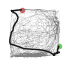

In [235]:
f,ax = plt.subplots(figsize=(1,1))
window = np.arange(500)
ax.plot(x,y, linewidth=0.1, color='grey')
ax.plot(x[window],y[window], 'k')
ax.scatter(x[window][0], y[window][0], s=20, color='g')
ax.scatter(x[window][-1], y[window][-1], s=20, color='r')
ax.axis("off")
f.savefig(p/"trace_w.pdf",dpi=300, bbox_inches='tight', pad_inches=0.2)

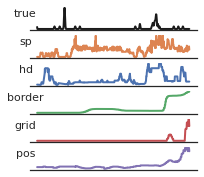

In [240]:
unit=1
analyses_colors = sns.color_palette(palette='deep', as_cmap=True)
type_color = {'true': 'k',
              'hd': analyses_colors[0],
              'sp': analyses_colors[1],
              'border': analyses_colors[2],
              'grid': analyses_colors[3],
              'pos': analyses_colors[4]}

x,y, t = behav['x'], behav['y'], behav['t']

models = ['true', 'sp','hd', 'border', 'grid', 'pos']
sns.set_style('white')
f,ax = plt.subplots(6,1,figsize=(3,3))
for ii,model in enumerate(models):
    if model in ['hd', 'sp']:
        tw = t[test_bool_ids&sp_valid_samps]
    else:
        tw = t[test_bool_ids]
    ax[ii].plot(tw[window], resp[model][unit,window], linewidth=2,color=type_color[model])
    ax[ii].set_yticks([])
    ax[ii].set_yticklabels('')
    ax[ii].set_xticklabels('')
    for pos in ['left', 'top', 'right']:
        ax[ii].spines[pos].set_visible(False)
    ax[ii].set_ylabel(model, fontsize=11, rotation=0)
    
p = Path("/home/alexgonzalez/google-drive/TreeMazeProject/Figures/OF_Fig/")
#f.savefig(p/"traces.pdf",dpi=300, bbox_inches='tight', pad_inches=0.2)

In [216]:
sm = {}
sm['true'] = sem.speed_model.get_spatial_map_fold(fold)[0]
sm['sp'] = sem.speed_model.get_predicted_spatial_map_fold(fold)[0]
sm['hd']= sem.hd_model.get_predicted_spatial_map_fold(fold)[0]
sm['pos'] = sem.pos_model.get_predicted_spatial_map_fold(fold)[0]
sm['grid'] = sem.grid_model.get_predicted_spatial_map_fold(fold)[0]
sm['border'] = sem.border_model.get_predicted_spatial_map_fold(fold)[0]

In [217]:
sm['sp'][1].shape

(47, 42)

In [229]:
models = ['true', 'sp','hd', 'border', 'grid', 'pos']
sns.set_style('white')
f,ax = plt.subplots(6,1,figsize=(4,2))
ax=ax.flatten()
for ii,model in enumerate(models):
    sns.heatmap(sm[model][unit],ax=ax[ii],cbar=False,square=True)
    ax[ii].axis('off')
    ax[ii].invert_yaxis()
f.savefig(p/"rm.pdf",dpi=300, bbox_inches='tight', pad_inches=0.2)

In [11]:
%%time
spatial_funcs = reload(spatial_funcs)
out = spatial_funcs.get_grid_encoding_model(behav['x'], behav['y'], fr[0:5], params['x_bin_edges_'], params['y_bin_edges_'], data_type='fr')

CPU times: user 10.4 s, sys: 11.3 s, total: 21.7 s
Wall time: 13.3 s


In [21]:
np.nanmean(out[1]['ar2'],axis=0)

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


array([0.01546285, 0.01412229,        nan,        nan, 0.01863056])

In [72]:
%%time
spatial_funcs = reload(spatial_funcs)
sem = spatial_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,fr[0:6],time_step=0.02, data_type='fr', norm_resp=None)
sem.get_grid_model()

CPU times: user 9.87 s, sys: 10.3 s, total: 20.1 s
Wall time: 13.8 s


In [148]:
%%time
spatial_funcs=reload(spatial_funcs)
sem2 = spatial_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,fr[0:6],time_step=0.02, data_type='fr', norm_resp='max')
#sem2.get_grid_model()
sem2.get_border_model()

CPU times: user 7.39 s, sys: 9.78 s, total: 17.2 s
Wall time: 1.15 s


In [137]:
tbl=sem.grid_model.avg_folds()
tbl[(tbl.metric=='r2') & (tbl.split=='test')]

unit_id metric split     value
8         0     r2  test  0.002005
18        1     r2  test -0.021535
28        2     r2  test       NaN
38        3     r2  test       NaN
48        4     r2  test  0.012676
58        5     r2  test  0.005021

In [136]:
tbl=sem2.grid_model.avg_folds()
tbl[(tbl.metric=='r2') & (tbl.split=='test')]

unit_id metric split     value
8         0     r2  test  0.002005
18        1     r2  test -0.021535
28        2     r2  test       NaN
38        3     r2  test       NaN
48        4     r2  test  0.012676
58        5     r2  test  0.005021

In [150]:
tbl=sem2.border_model.avg_folds()
tbl[(tbl.metric=='r2') & (tbl.split=='train')]

unit_id metric  split     value
9         0     r2  train  0.017101
19        1     r2  train  0.014598
29        2     r2  train  0.016548
39        3     r2  train  0.146475
49        4     r2  train  0.005682
59        5     r2  train  0.014916

(array([3.3037e+04, 2.9500e+03, 2.4320e+03, 1.8350e+03, 1.0260e+03,
        3.7600e+02, 1.0800e+02, 5.0000e+01, 2.0000e+01, 2.0000e+00]),
 array([  0.  ,  15.75,  31.5 ,  47.25,  63.  ,  78.75,  94.5 , 110.25,
        126.  , 141.75, 157.5 ]),
 <a list of 10 Patch objects>)

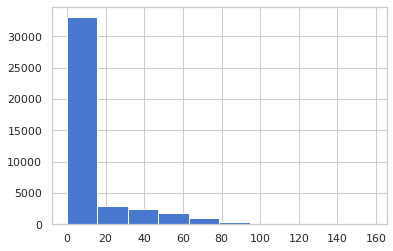

In [144]:
plt.hist(sem.grid_model.get_response_fold(0)[0][0])

(array([  880.,  1637., 35330.,   265.,  1105.,   877.,   524.,   533.,
          400.,   285.]),
 array([0.03308893, 0.04482375, 0.05655856, 0.06829338, 0.0800282 ,
        0.09176302, 0.10349784, 0.11523266, 0.12696747, 0.13870229,
        0.15043711]),
 <a list of 10 Patch objects>)

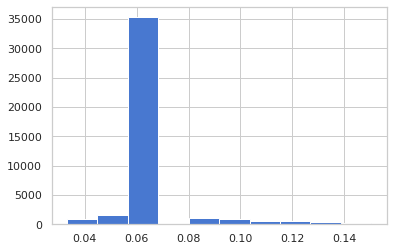

In [146]:
plt.hist(sem2.grid_model.predict_model_fold(0)[0][0])

In [151]:
sem.get_border_model()

In [153]:
sem.border_model.avg_folds()

unit_id metric  split      value
0         0    ar2   test  -0.001941
1         0    ar2  train   0.016985
2         0    err   test  20.205131
3         0    err  train  20.067082
4         0  map_r   test   0.543168
5         0  map_r  train   0.461122
6         0  n_err   test   1.954274
7         0  n_err  train   1.930367
8         0     r2   test  -0.001466
9         0     r2  train   0.017101
10        1    ar2   test  -0.008569
11        1    ar2  train   0.014481
12        1    err   test  13.399042
13        1    err  train  13.329984
14        1  map_r   test   0.635269
15        1  map_r  train   0.493471
16        1  n_err   test   1.832662
17        1  n_err  train   1.808714
18        1     r2   test  -0.008091
19        1     r2  train   0.014598
20        2    ar2   test   0.003576
21        2    ar2  train   0.016432
22        2    err   test  32.311434
23        2    err  train  32.173155
24        2  map_r   test   0.944039
25        2  map_r  train   0.878411
26        2  n_err   test   0.689665
27        2  n_err  train   0.686393
28        2     r2   test   0.004049
29        2     r2  train   0.016548
30        3    ar2   test   0.130969
31        3    ar2  train   0.146374
32        3    err   test  10.892242
33        3    err  train  10.839789
34        3  map_r   test   0.915291
35        3  map_r  train   0.900455
36        3  n_err   test   1.014455
37        3  n_err  train   1.007256
38        3     r2   test   0.131381
39        3     r2  train   0.146475
40        4    ar2   test  -0.000830
41        4    ar2  train   0.005564
42        4    err   test  10.093334
43        4    err  train  10.097106
44        4  map_r   test   0.672604
45        4  map_r  train   0.649542
46        4  n_err   test   1.980783
47        4  n_err  train   1.976270
48        4     r2   test  -0.000355
49        4     r2  train   0.005682
50        5    ar2   test   0.006368
51        5    ar2  train   0.014799
52        5    err   test   7.672844
53        5    err  train   7.654986
54        5  map_r   test   0.505894
55        5  map_r  train   0.440098
56        5  n_err   test   2.896357
57        5  n_err  train   2.888927
58        5     r2   test   0.006839
59        5     r2  train   0.014916

In [28]:
sem = spatial_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,spks,time_step=0.02, data_type='spikes')
sem.get_grid_model()

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:248: RuntimeWarning: invalid value encountered in log
  dev_per_samp = np.log(y**y) - np.log(y_hat**y) - y + y_hat
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:254: RuntimeWarning: Mean of empty slice
  return 2*np.nanmean(dev_per_samp, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:248: RuntimeWarning: overflow encountered in power
  dev_per_samp = np.log(y**y) - np.log(y_hat**y) - y + y_hat
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:248: RuntimeWarning: invalid value encountered in log
  dev_per_samp = np.log(y**y) - np.log(y_hat**y) - y + y_hat
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:254: RuntimeWarning: Mean of empty slice
  return 2*np.nanmean(dev_per_samp, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:248: RuntimeWarning: overflow encountered in power
  dev_per_samp = np.log

In [30]:
tbl=sem.grid_model.avg_folds()
tbl[(tbl.metric=='map_r') & (tbl.split=='train')]

unit_id metric  split     value
5          0  map_r  train  0.540721
15         1  map_r  train  0.436732
25         2  map_r  train       NaN
35         3  map_r  train       NaN
45         4  map_r  train  0.631870
55         5  map_r  train  0.744499
65         6  map_r  train  0.320581
75         7  map_r  train  0.286835
85         8  map_r  train       NaN
95         9  map_r  train       NaN
105       10  map_r  train  0.664632
115       11  map_r  train       NaN
125       12  map_r  train       NaN
135       13  map_r  train  0.608920
145       14  map_r  train       NaN
155       15  map_r  train       NaN
165       16  map_r  train       NaN
175       17  map_r  train  0.310807

In [36]:
%%time
spatial_funcs = reload(spatial_funcs)
out = spatial_funcs.get_border_encoding_model(behav['x'], behav['y'], fr[0:5], params['x_bin_edges_'], params['y_bin_edges_'], data_type='fr')

CPU times: user 5.91 s, sys: 8.16 s, total: 14.1 s
Wall time: 824 ms


In [212]:
%%time
spatial_funcs = reload(spatial_funcs)
sem = spatial_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,fr,time_step=0.02)

CPU times: user 26.1 ms, sys: 5.67 ms, total: 31.7 ms
Wall time: 30.3 ms


In [213]:
%%time
spatial_funcs = reload(spatial_funcs)
sem = spatial_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,fr,time_step=0.02)
sem.compute_speed_model()

CPU times: user 19.1 s, sys: 18.1 s, total: 37.2 s
Wall time: 3.2 s


In [214]:
tbl = sem.speed_model.scores
tbl = tbl.astype({'value': 'float'})
summary_table = tbl.groupby(['unit_id','metric', 'split'], as_index=False).mean()
summary_table.head()

unit_id metric  split      value
0        0    ar2   test  -0.002363
1        0    ar2  train   0.015685
2        0    err   test  18.641927
3        0    err  train  18.543026
4        0  map_r   test   0.948199

In [218]:
summary_table[(summary_table.unit_id==0) & (summary_table.metric=='r2')]

unit_id metric  split     value
8        0     r2   test  0.002769
9        0     r2  train  0.016940

In [171]:
train_features.shape, test_features.shape, train_response.shape

((29951, 39), (8282, 39), (15, 29951))

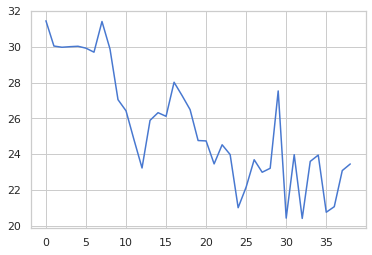

In [183]:
from sklearn import linear_model as lm
m1 = lm.LinearRegression(fit_intercept=False).fit(train_features, train_response[0])
plt.plot(m1.coef_)

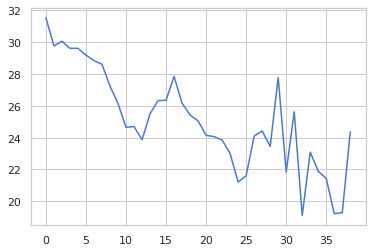

In [227]:
plt.plot(sem.speed_model.models[4,0].coef_)

In [198]:
model_units = sem.speed_model.train_model_fold(0)
model_units[0].coef_

array([6.39258718, 6.4654811 , 6.48467136, 6.8143401 , 5.98230834,
       6.39667737, 6.80975754, 7.78876782, 7.72350957, 6.90382872,
       6.27982292, 6.80701031, 6.95075371, 7.14993275, 7.17787921,
       6.90297394, 7.18161199, 6.20573563, 6.90104295, 7.61030826,
       7.46391309, 7.94869488, 7.48926824, 9.22569361, 7.16738197,
       5.88995724, 6.07215017, 7.07751347, 8.29359448, 7.16709781,
       6.85154863, 5.37606666, 7.16416195, 6.25364302, 5.10469439,
       5.85578026, 7.08116223, 6.00392043, 5.61723461])

In [201]:
sem.speed_model.models[1,4].coef_

array([ 6.06097106,  6.3298106 ,  6.34619092,  6.67580464,  5.95835075,
        6.24525448,  7.19757615,  7.7071709 ,  7.86240824,  7.3406269 ,
        6.90144338,  7.13158562,  7.64841299,  7.57646332,  7.42940422,
        7.68624108,  7.76927526,  6.32680857,  7.07796815,  7.27187915,
        6.71908442,  7.23515739,  7.43840611,  9.02045306,  7.95340695,
        7.84074956,  6.33606547,  9.2878498 , 11.26157196, 10.95058217,
        7.885005  ,  4.04971895,  6.8       ,  6.45791647,  5.24193548,
        5.81395349,  8.15152542,  8.38447094,  8.1969169 ])

In [266]:
%%time
spatial_funcs = reload(spatial_funcs)
sem2 = spatial_funcs.AllSpatialEncodingModelsScores(x,y,speed,ha,hd,fr)

CPU times: user 34 ms, sys: 0 ns, total: 34 ms
Wall time: 32.6 ms


In [267]:
%%time
out = sem2.get_position_model()

CPU times: user 2min 53s, sys: 3min 4s, total: 5min 58s
Wall time: 20.4 s


In [269]:
out['train_perf']['r2'].mean(axis=0)

array([0.06700067, 0.00612261, 0.02480534, 0.03778206, 0.04328305,
       0.11237734, 0.29100591, 0.00923329, 0.0189831 , 0.03412617,
       0.02004329, 0.00778373, 0.01307969, 0.00809342, 0.03261626])

In [127]:
%%time
out = sem2.get_speed_model()

CPU times: user 28.6 s, sys: 35.7 s, total: 1min 4s
Wall time: 3.48 s


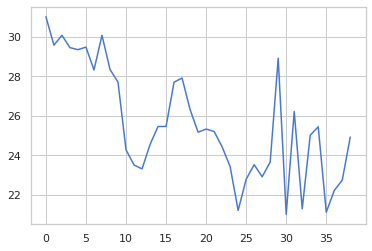

In [180]:
plt.plot(out['coeffs'][0,0])

In [222]:
out['train_perf']['r2'][:,0].mean()

0.01693440997654565

In [482]:
%%time
spatial_funcs = reload(spatial_funcs)
sem = spatial_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,spks,time_step=0.02, data_type='spikes')
#sem.compute_speed_model()

CPU times: user 6.42 ms, sys: 0 ns, total: 6.42 ms
Wall time: 4.63 ms


In [483]:
%%time
sem.get_grid_model()

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:254: RuntimeWarning: Mean of empty slice
  return 2*np.nanmean(dev_per_samp, axis=1)


ValueError: operands could not be broadcast together with shapes (15,) (15,40000) 

In [376]:
sem.grid_model.score_model_fold(0)

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:248: RuntimeWarning: overflow encountered in power
  dev_per_samp = np.log(y**y) - np.log(y_hat**y) - y + y_hat
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:248: RuntimeWarning: invalid value encountered in power
  dev_per_samp = np.log(y**y) - np.log(y_hat**y) - y + y_hat
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:248: RuntimeWarning: invalid value encountered in log
  dev_per_samp = np.log(y**y) - np.log(y_hat**y) - y + y_hat
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:248: RuntimeWarning: invalid value encountered in add
  dev_per_samp = np.log(y**y) - np.log(y_hat**y) - y + y_hat
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: operands could not be broadcast together with shapes (15,) (15,40000) 

In [447]:
unit=1
fold=0
train_ids = sem.grid_model.crossval_samp_ids != fold
response, resp_test = sem.grid_model.get_response_fold(fold) 
features = sem.grid_model.get_features_fold(fold, unit)
response_hat, resp_test_hat = sem.grid_model.predict_model_fold(fold)

In [480]:
rs = reload(rs)
rs.get_poisson_d2(response, response_hat)

array([           nan, 1.37488779e-03,            nan,            nan,
                  nan, 5.17709203e-03,            nan, 1.31838101e-03,
       6.60110039e-05, 2.40102133e-03,            nan, 3.68039201e-03,
       4.64114373e-03, 6.24117075e-05, 1.82474805e-03])

In [475]:
.

(15, 2)

In [462]:
np.diag(response.mean(axis=1))@np.ones_like(response)

array([[0.583175, 0.583175, 0.583175, ..., 0.583175, 0.583175, 0.583175],
       [0.04675 , 0.04675 , 0.04675 , ..., 0.04675 , 0.04675 , 0.04675 ],
       [0.416225, 0.416225, 0.416225, ..., 0.416225, 0.416225, 0.416225],
       ...,
       [0.045475, 0.045475, 0.045475, ..., 0.045475, 0.045475, 0.045475],
       [0.14045 , 0.14045 , 0.14045 , ..., 0.14045 , 0.14045 , 0.14045 ],
       [0.129725, 0.129725, 0.129725, ..., 0.129725, 0.129725, 0.129725]],
      dtype=float32)

In [427]:
a = np.log(response[0]**response[0]) - np.log(response_hat[0]**response[0].astype(int)) - response[0] + response_hat[0]

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [431]:
a[np.isinf(a)]=0
a

array([0., 0., 0., ..., 1., 0., 0.])

In [436]:
m = sem.grid_model.get_spatial_map_fold(0)

In [444]:
sem.grid_model.models

array([[None, PoissonRegressor(alpha=0), None, None, None,
        PoissonRegressor(alpha=0), None, PoissonRegressor(alpha=0),
        PoissonRegressor(alpha=0), PoissonRegressor(alpha=0), None,
        PoissonRegressor(alpha=0), PoissonRegressor(alpha=0),
        PoissonRegressor(alpha=0), PoissonRegressor(alpha=0)],
       [PoissonRegressor(alpha=0), PoissonRegressor(alpha=0),
        PoissonRegressor(alpha=0), PoissonRegressor(alpha=0), None,
        PoissonRegressor(alpha=0), PoissonRegressor(alpha=0),
        PoissonRegressor(alpha=0), PoissonRegressor(alpha=0),
        PoissonRegressor(alpha=0), None, None, PoissonRegressor(alpha=0),
        PoissonRegressor(alpha=0), PoissonRegressor(alpha=0)],
       [None, PoissonRegressor(alpha=0), None, None, None,
        PoissonRegressor(alpha=0), None, PoissonRegressor(alpha=0),
        PoissonRegressor(alpha=0), PoissonRegressor(alpha=0),
        PoissonRegressor(alpha=0), PoissonRegressor(alpha=0),
        PoissonRegressor(alpha=0), Poi

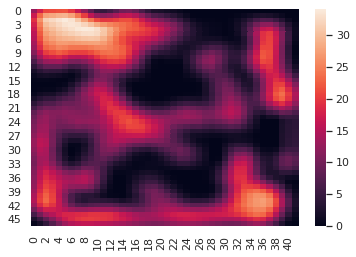

In [442]:
sns.heatmap(m[0][0])

In [419]:
response[0].astype(int)/response_hat[0]

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([inf, nan, inf, ...,  0., inf, nan])

In [362]:
out = sem.grid_model.get_predicted_spatial_map_fold(0)

In [388]:
out = sem.grid_model.predict_model_fold(0)
r = sem.grid_model.get_response_fold(0)

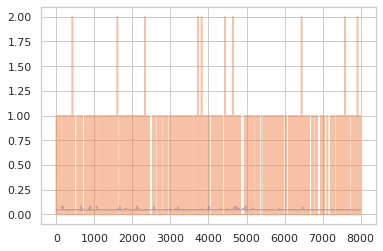

In [389]:
plt.plot( np.array([out[0][1],r[0][1]]).T[::5], alpha=0.5) 

In [323]:
f = sem.grid_model.get_features_fold(0,1)

In [365]:
unit=1
fold=0
train_ids = sem.grid_model.crossval_samp_ids != fold
response = sem.grid_model.get_response_fold(0)[0] 
fields = spatial_funcs.get_grid_fields(response[unit], x[train_ids], y[train_ids], x_bin_edges=sem.params['x_bin_edges_'], y_bin_edges=sem.params['y_bin_edges_'])
features = sem.grid_model.get_features_fold(fold, unit)

In [340]:
response_hat = sem.grid_model.predict_model_fold(0)

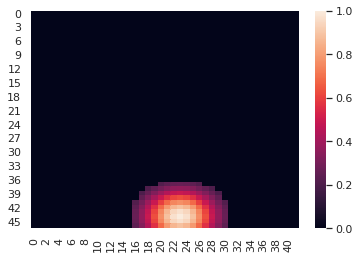

In [369]:
sns.heatmap(fields[2])

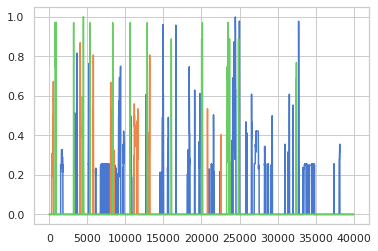

In [370]:
plt.plot(features[0])

In [276]:
%%time
sem.get_pos_model()

CPU times: user 3min 5s, sys: 3min 14s, total: 6min 19s
Wall time: 20.9 s


In [281]:
out = sem.pos_model.get_predicted_spatial_map_fold(0)
out

(array([array([[11.12262045, 15.33867151, 18.43892712, ...,  0.        ,
          0.        ,  0.        ],
        [14.99207185, 20.66594596, 24.86609497, ...,  1.58788556,
          0.64229133,  0.        ],
        [17.57836151, 24.21611895, 29.15868436, ...,  4.98906735,
          2.52485166,  0.64229133],
        ...,
        [ 8.3751311 , 13.56351872, 18.57462047, ..., 10.58135345,
          4.92981382,  1.57836651],
        [ 4.55005336,  8.67724789, 13.21976041, ...,  6.81338646,
          2.49552742,  0.6382852 ],
        [ 1.45366795,  4.27176186,  7.82587348, ...,  3.47064386,
          0.63387631,  0.        ]]),
        array([[0.89362485, 1.20203612, 1.4013885 , ..., 0.        , 0.        ,
         0.        ],
        [1.20103487, 1.61454985, 1.88245677, ..., 0.1455876 , 0.05890771,
         0.        ],
        [1.40680328, 1.89030477, 2.20431479, ..., 0.45229128, 0.22834479,
         0.05754457],
        ...,
        [0.88286147, 1.41802294, 1.92229141, ..., 0.952159

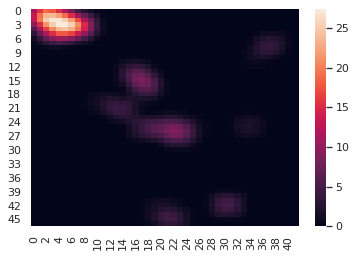

In [286]:
sns.heatmap(out[1][0])

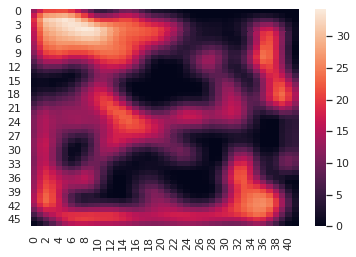

In [285]:
out =  sem.pos_model.get_spatial_map_fold(0)
sns.heatmap(out[0][0])

In [253]:
%%time
sem.compute_hd_model()

CPU times: user 16.6 s, sys: 16.3 s, total: 33 s
Wall time: 2.88 s


In [258]:
tbl = sem.hd_model.avg_folds()
tbl.head()

unit_id metric  split      value
0        0    ar2   test  -0.016696
1        0    ar2  train   0.004472
2        0    err   test  18.779662
3        0    err  train  18.649345
4        0  map_r   test   0.933981

In [264]:
tbl[(tbl.metric=='r2') & (tbl.split=='train')]

unit_id metric  split     value
9          0     r2  train  0.005644
19         1     r2  train  0.006556
29         2     r2  train  0.006719
39         3     r2  train  0.007188
49         4     r2  train  0.006318
59         5     r2  train  0.008120
69         6     r2  train  0.012044
79         7     r2  train  0.006159
89         8     r2  train  0.007137
99         9     r2  train  0.023762
109       10     r2  train  0.011920
119       11     r2  train  0.014076
129       12     r2  train  0.007754
139       13     r2  train  0.005784
149       14     r2  train  0.018180

In [265]:
sem2.get_hd_model()
sem2.hd_model_out['train_perf']['r2'].mean(axis=0)

array([0.00529044, 0.00633209, 0.00668611, 0.00702812, 0.00638683,
       0.00803668, 0.01195022, 0.00601883, 0.00693945, 0.02383903,
       0.0119265 , 0.01403164, 0.00793016, 0.00558125, 0.01796936])

# 4/8/21: Testing implementation of single encoding model retrieval through subjectinfo class

In [4]:
from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)
subject = 'Cl'
session = 'Cl_OF_013119'
session_info = si.SubjectSessionInfo(subject, session)

In [70]:
%%time 
sp_model = session_info.get_encoding_model('speed')

TypeError: get_speed_encoding_model() missing 2 required positional arguments: 'neural_data' and 'speed_bin_edges'

In [13]:
%%time
b = session_info.get_encoding_model('border')

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 17.1 s, sys: 21.3 s, total: 38.4 s
Wall time: 2.14 s


In [23]:
%%time
p = session_info.get_encoding_model('position')

CPU times: user 2min 56s, sys: 2min 57s, total: 5min 54s
Wall time: 21 s


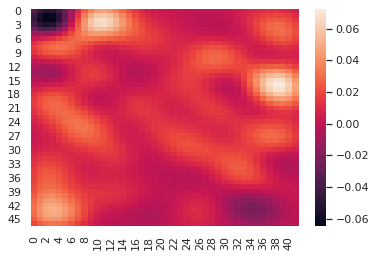

In [37]:
sns.heatmap(p['position']['coeffs'].mean(axis=0)[10].reshape(47,42))

In [22]:
b['border']['coeffs'].mean(axis=0)[0]

array([18.18779251,  6.04282217,  4.32297169,  2.8564932 , 10.63141194,
        3.14377   ])

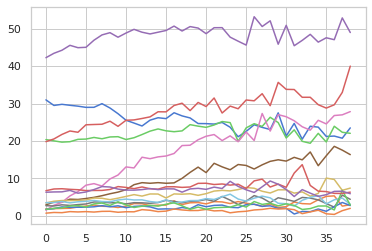

In [12]:
plt.plot(sp_model['speed']['coeffs'].mean(axis=0).T)

# older

In [36]:
n_units = 10
x = pd.DataFrame(np.random.randn(n_units,5), index=range(n_units), columns=['score', 'sig', 'r2', 'rmse', 'nrmse'])
x['analysis_type']='grid'
x['tt'] = 3
x['tt_cl'] = np.arange(n_units)

x = pd.DataFrame(np.random.randn(n_units,5), index=range(n_units), columns=['score', 'sig', 'r2', 'rmse', 'nrmse'])
x['analysis_type']='grid'
x['tt'] = 3
x['tt_cl'] = np.arange(n_units)

score       sig        r2      rmse     nrmse analysis_type  tt  tt_cl
0  0.149734 -0.768418 -1.756523 -0.968491  0.598414          grid   3      0
1  1.343004  0.024309 -1.583743 -0.582264  0.253161          grid   3      1
2 -1.040925  0.303380 -0.253038 -0.021466  0.905312          grid   3      2
3 -1.217853  1.065387 -1.898996 -0.073723  1.636080          grid   3      3
4  0.910442 -1.109812  0.671196 -0.842164 -0.216456          grid   3      4
5  1.266657  0.017316 -1.278471  0.433655 -1.662749          grid   3      5
6  0.072913 -1.501025 -0.814944 -0.191755 -0.156814          grid   3      6
7  0.032850 -0.567417  0.181063 -0.743990  0.816168          grid   3      7
8  0.129101  0.854858  0.365312 -2.900889 -0.429579          grid   3      8
9 -0.908614 -0.466764 -2.432825  1.050276 -1.159547          grid   3      9

In [42]:
np.tile(np.arange(n_units),4)
np.repeat(np.array(['sp','hd','border','grid']),n_units)

array(['sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'hd',
       'hd', 'hd', 'hd', 'hd', 'hd', 'hd', 'hd', 'hd', 'hd', 'border',
       'border', 'border', 'border', 'border', 'border', 'border',
       'border', 'border', 'border', 'grid', 'grid', 'grid', 'grid',
       'grid', 'grid', 'grid', 'grid', 'grid', 'grid'], dtype='<U6')

In [3]:
subject_id = 'Li'
session = 'Li_OF_060718'
#subject_info = SubjectInfo(subject_id, overwrite=True)
subject_info = SubjectInfo(subject_id)
session_info = SubjectSessionInfo(subject_id,session)
task_params = SimpleNamespace(**session_info.task_params)
n_units = session_info.n_units
print(session_info)
session_info.print_task_params()

number of units in session 37

Session Information for subject Li, session Li_OF_060718
Number of curated units: 37
Methods listed below can be executed with get_{method}(), eg. get_spikes():
  -> track_data. Executed = True
  -> time. Executed = True
  -> spikes. Executed = True
  -> binned_spikes. Executed = True
  -> fr. Executed = True
  -> spike_maps. Executed = True
  -> fr_maps. Executed = True
  -> scores. Executed = False
  -> lnp_scores. Executed = False

To run all analyses use run_analyses().


Task/track and analysis parameters. 

  -> time_step: 0.02
  -> x_pix_lims: [100, 650]
  -> y_pix_lims: [100, 500]
  -> x_pix_bias: -380
  -> y_pix_bias: -280
  -> vt_rate: 0.016666666666666666
  -> xy_pix_rot_rad: 1.6507963267948966
  -> x_pix_mm: 3.7790697674418605
  -> y_pix_mm: 3.265765765765766
  -> x_mm_bias: 20
  -> y_mm_bias: 650
  -> x_mm_lims: [-630, 630]
  -> y_mm_lims: [-60, 1350]
  -> x_cm_lims: [-63, 63]
  -> y_cm_lims: [-6, 135]
  -> mm_bin: 30
  -> cm_bin: 3
  -> max_

In [13]:
subject_info.sort_tables['valid']

1    2    3    4    5    6    7    8    9    10   11  \
Li_T3g_052818       NaN   15  NaN  NaN   18   17  NaN  NaN  NaN  NaN  NaN   
Li_OF_052818        NaN   18  NaN   18   17   22   16   18  NaN  NaN  NaN   
Li_T3g_052918       NaN   16   10  NaN  NaN  NaN   17   16   14   16  NaN   
Li_OF_052918        NaN   18   14  NaN  NaN   24   16   19   18   16  NaN   
Li_OF_053018         12   16   13  NaN  NaN   16   20   18   17   14  NaN   
Li_T3g_053018       NaN    9   10  NaN  NaN   13   16   18   15   15  NaN   
Li_OF_053118        NaN  NaN   10  NaN  NaN   23   22   19   18   18  NaN   
Li_T3g_053118       NaN   16   10  NaN   15   17   17   17   16   16  NaN   
Li_T3g_060118       NaN  NaN   11  NaN    9   17   16   17   15   17  NaN   
Li_OF_060118        NaN   16   11  NaN    7   23   25   19  NaN   16  NaN   
Li_T3g_060418       NaN   12   10  NaN  NaN  NaN   16   15   12   17  NaN   
Li_OF_060418         16   15   16   17   20   25   24   16  NaN   16  NaN   
Li_T3i_060518       NaN  NaN   15  NaN   12   12   22   16   19   15  NaN   
Li_OF_060518         19  NaN   13   11  NaN   17   21   19   17   16  NaN   
Li_T3i_060618       NaN  NaN   16  NaN   14   21   19   16   15   16  NaN   
Li_OF_060718        NaN  NaN   17  NaN  NaN  NaN   19   21   18   17  NaN   
Li_T3i_060818        14   12   12  NaN  NaN   16   17   15   17   14  NaN   
Li_OF_060818         19   18   13   14   17   20   26   23   24   16  NaN   
Li_OF_061118        NaN  NaN   15  NaN  NaN   18   17   16   17   14  NaN   
Li_T3i_061118       NaN  NaN   10  NaN  NaN  NaN   20   15   17   14  NaN   
Li_OF_061218        NaN  NaN   12  NaN   15   26   23   18   21   16  NaN   
Li_T3i_061218       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Li_T3i_061218_0001  NaN  NaN   10  NaN   11   16   17   17   16   17  NaN   
Li_OF_061318        NaN  NaN   15  NaN   18   20   18   18   16   15  NaN   
Li_T3g_061318       NaN  NaN   15  NaN   16  NaN   17   16   16   16  NaN   
Li_T3g_061418        15   17   15   16   22   20   18   18   16   15  NaN   
Li_OF_061418        NaN  NaN   14  NaN  NaN   20   20   18   19   14  NaN   
Li_OF_061518        NaN  NaN   17  NaN  NaN   22   19   19   19   17  NaN   
Li_T3g_061518       NaN  NaN   14  NaN  NaN   17   15   17   16   16  NaN   
Li_OF_061818        NaN  NaN   14  NaN   24   17   18   18   19   15  NaN   
Li_T3g_061818       NaN  NaN   15  NaN  NaN   12   16   17   17   16  NaN   
Li_OF_062018         18  NaN   16  NaN   24   22   19   20   16   16  NaN   
Li_T3g_062018       NaN  NaN   12  NaN  NaN   15   18   16   16   16  NaN   
Li_T3g_062518       NaN   13   15  NaN   17   11   20   18   17   16  NaN   
Li_OF_062518        NaN  NaN   15  NaN   17   26   20   23   18   16  NaN   
Li_T3g_062618       NaN   12   17  NaN  NaN   17   20   21   16   16  NaN   
Li_OF_062618        NaN   16   15  NaN   22   19   23   17   17   16  NaN   
Li_T3g_062718       NaN  NaN   14  NaN   17   15   18   17   17   16  NaN   
Li_OF_062718         20  NaN   15   12  NaN   22   18   19   17   16  NaN   
Li_T3g_062818       NaN  NaN   15  NaN  NaN   12   17   18   16   16  NaN   
Li_OF_062818        NaN  NaN   16  NaN   22   18   18   21   17   16  NaN   
Li_OF_062918        NaN  NaN   15  NaN  NaN   23   28   18   18   17  NaN   
Li_T3g_062918       NaN   10   15  NaN  NaN   19   17   16   16   16  NaN   
Li_OF_070218         22  NaN   17  NaN   27   27   24   18   20   16  NaN   
Li_T3g_070218       NaN   12   15  NaN  NaN   15   19   18   16   16  NaN   
Li_T3g_070518       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Li_T3g_070518_0001  NaN  NaN   15  NaN  NaN   13   17   21   16   16  NaN   
Li_T3g_070618        15   13   13  NaN  NaN   14   17   19   20   16  NaN   
Li_OF_070618         15  NaN   15   12  NaN   20   17   16   18   16  NaN   
Li_T3g_070918       NaN  NaN   13  NaN  NaN   11   16   17   18   16  NaN   
Li_OF_071018         19  NaN   13  NaN  NaN   26   23   19   18   16  NaN   
Li_T3g_071018    

In [18]:
# load data
spks,_,_ = session_info.get_spikes()
bs = session_info.get_binned_spikes()
fr = session_info.get_fr()
t_rs = session_info.get_time()
of_dat = session_info.get_track_data() 
of_dat = SimpleNamespace(**of_dat)
spike_maps = session_info.get_spike_maps()
fr_maps = session_info.get_fr_maps()

Spikes Files not Found or overwrite=1, creating them.
Binned Spikes Files not Found or overwrite=1, creating them.
Spikes Files not Found or overwrite=1, creating them.
Firing Rate Files Not Found or overwrite=1, creating them.
Open Field Track Data not Found or Overwrite= True, creating them.
Open Field Spike Maps not Found or Overwrite= True, creating them.
Open Field Firing Rate Maps not Found or Overwrite= True, creating them.


In [31]:
maps = np.zeros((10))
maps.reshape(1,-1).shape
#maps[np.newaxis, ].shape

(1, 10)

In [19]:
spatial_funcs = reload(spatial_funcs)
spatial_funcs.get_border_encoding_model(of_dat.x, of_dat.y, fr, fr_maps, task_params.x_bin_edges_, task_params.y_bin_edges_)

(    solstad_score  solstad_sig       aR2       rmse     nrmse
 0        0.364803          1.0  0.003837   5.030571  2.199636
 1        0.419546          1.0  0.017009  11.583824  0.936995
 2        0.424479          1.0  0.024745  10.782260  1.034362
 3        0.409651          1.0  0.038320   6.595632  1.067205
 4        0.405837          1.0  0.016980  24.574617  0.749446
 5        0.468619          0.0  0.022536   6.960973  1.823718
 6        0.494666          0.0  0.013591   6.821572  1.945194
 7        0.386649          1.0  0.001496   4.930943  2.207164
 8        0.444261          0.0  0.003278   8.023617  1.726517
 9        0.419920          1.0  0.004717   8.479417  1.257281
 10       0.270802          0.0  0.044933   6.247112  2.267360
 11       0.560800          0.0  0.011660   7.341082  2.351344
 12      -0.103409          1.0  0.068132   6.988496  1.478502
 13       0.557231          0.0  0.041279   6.243388  1.846777
 14       0.185246          1.0  0.069306   7.331054  1

In [46]:
def plot_fr_map(unit):
    f, ax = plt.subplots()
    ax = sns.heatmap(fr_maps[unit], ax=ax)
    ax.invert_yaxis()
    

interact(plot_fr_map, unit=widgets.IntSlider(min=0, max=n_units-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='unit', max=36), Output()), _dom_classes=('widget-interac…

<function __main__.plot_fr_map(unit)>

In [25]:
scores = pd.DataFrame(index=range(n_units),
                          columns=['vec_len', 'mean_ang','rayleigh',  'p_val', 'sig', 'var_ang', 'std_ang'])

alpha=0.02
for unit in range(n_units):
    vec_len, mean_ang, var_ang, std_ang, = rs.resultant_vector_length(alpha=hd[valid_samps], w=fr[unit][valid_samps])
    p_val, rayleigh = rs.rayleigh(alpha=hd[valid_samps], w=fr[unit][valid_samps])
    out_dir = {'vec_len': vec_len, 'mean_ang': np.mod(mean_ang, 2*np.pi), 'rayleigh': rayleigh, 'p_val': p_val, 'sig': p_val<alpha, 'var_ang': var_ang,
                   'std_ang': std_ang}

    scores.loc[unit] = np.array([val for key,val in out_dir.items()])

scores

vec_len  mean_ang rayleigh         p_val sig   var_ang  std_ang
0   0.0439832   1.97064  1527.99             0   1  0.956017  2.49958
1    0.141234  0.754557  3825.16             0   1  0.858766  1.97855
2    0.321559   1.52139  14165.7             0   1  0.678441  1.50637
3     0.11229    2.1556  1570.49             0   1   0.88771  2.09126
4    0.330249  0.136907  14961.5             0   1  0.669751  1.48856
5    0.336173   2.95688  13715.4             0   1  0.663827  1.47657
6    0.299722   6.01634  36648.9             0   1  0.700278  1.55235
7    0.238859   2.15285  5378.47             0   1  0.761141  1.69227
8   0.0867761   2.85956  178.329   2.55983e-78   1  0.913224  2.21107
9    0.094004   3.43103  828.668             0   1  0.905996  2.17459
10  0.0995149   2.28002  1023.18             0   1  0.900485  2.14823
11  0.0171877   1.71508  14.5158   4.95963e-07   1  0.982812  2.85081
12   0.138755   2.10301  2566.77             0   1  0.861245  1.98749
13  0.0568965  0.810737  2599.13             0   1  0.943103  2.39438
14  0.0390641  0.793103  167.075   2.58637e-73   1  0.960936  2.54659
15   0.158168  0.682544  2000.93             0   1  0.841832  1.92047
16  0.0716502   2.57563  114.073     2.489e-50   1   0.92835  2.29607
17  0.0719174   5.00634  675.306  2.18465e-294   1  0.928083  2.29444
18  0.0330945    4.8631  305.253  2.47856e-133   1  0.966906   2.6109
19  0.0398337    4.7784  331.065  1.45731e-144   1  0.960166  2.53891
20  0.0231006   1.04517  307.949  1.74553e-134   1  0.976899  2.74514
21  0.0436125     5.599  394.159  5.46762e-172   1  0.956388  2.50296
22  0.0348229   4.62863  346.101  4.41453e-151   1  0.965177  2.59132
23  0.0672281   2.41353  790.881             0   1  0.932772  2.32365
24  0.0609399   3.97861  97.1346   5.97804e-43   1   0.93906  2.36553
25  0.0654533   1.95525  593.607  8.39401e-259   1  0.934547  2.33513
26   0.024596   2.40721  92.4795   6.77221e-41   1  0.975404  2.72219
27  0.0607314   3.08858  3200.03             0   1  0.939269  2.36698
28  0.0630027   2.02282  1801.91             0   1  0.936997  2.35142
29   0.143536    1.3387  2389.82             0   1  0.856464  1.97037
30   0.258578   1.12796  2342.18             0   1  0.741422  1.64472
31   0.083409   1.23927  2660.26             0   1  0.916591   2.2289

Open Field Spike Maps not Found or Overwrite= True, creating them.
Open Field Firing Rate Maps not Found or Overwrite= True, creating them.


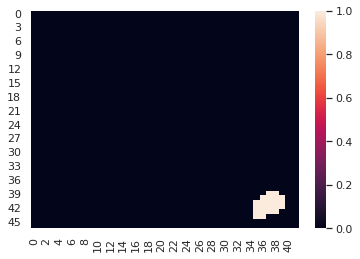

In [26]:
sns.heatmap(of_dat.pos_map_secs>1)

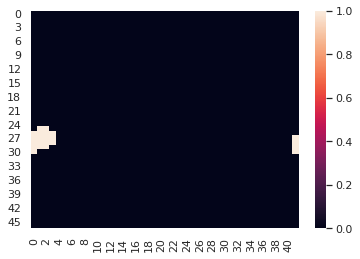

In [57]:
thr_map = of_dat.pos_map_secs>1

field_idx = np.argwhere(thr_map)
                  
height,width = thr_map.shape


moved_fields = field_idx + np.array([np.random.randint(dim) for dim in thr_map.shape])
moved_fields[:,0]  = np.mod(moved_fields[:,0], height)
moved_fields[:,1]  = np.mod(moved_fields[:,1], width)
moved_map = np.zeros_like(thr_map)
moved_map[moved_fields[:,0],moved_fields[:,1]]=1

sns.heatmap(moved_map)

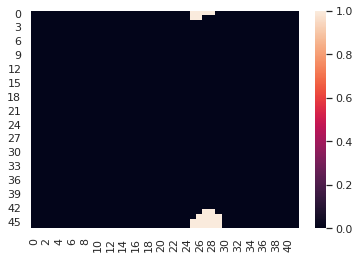

In [56]:

sns.heatmap(moved_map)

In [61]:
field_maps, n_fields = spatial_funcs.get_map_fields(of_dat.pos_map_secs, 0.5, 20)


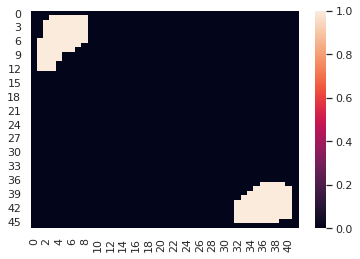

In [66]:
sns.heatmap(field_maps>=0)

1.0

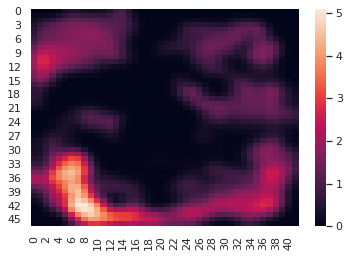

In [26]:
unit=11
fr_map = fr_maps[unit]
fr_thr = 0.3
max_fr = fr_map.max()
sns.heatmap(fr_map)

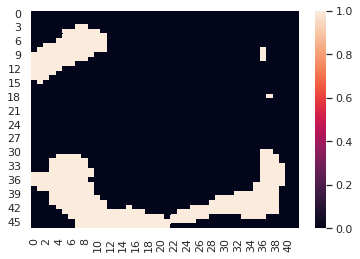

In [28]:
thr_map = fr_map>=fr_thr*max_fr
sns.heatmap(thr_map)

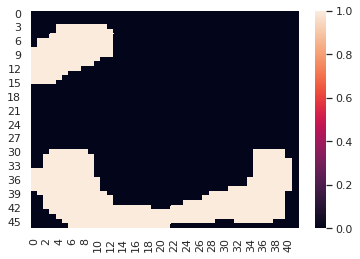

In [52]:
thr_map = fr_map>=fr_thr*max_fr
border_mask = np.ones_like(fr_map, dtype=bool)
border_mask[[0,-1],:] = False
border_mask[:,[0,-1]] = False

# eliminates small
thr_map2=ndimage.binary_opening(thr_map,structure=np.ones((3,3)))
thr_map2=ndimage.binary_closing(thr_map2,structure=np.ones((3,3)), mask=border_mask)
thr_map3=ndimage.binary_dilation(thr_map2,structure=np.ones((3,3)))

sns.heatmap(thr_map3)

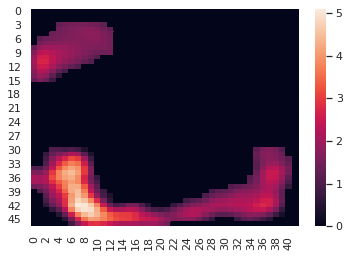

In [93]:
# get field ids
fields_map, n_fields = ndimage.label(thr_map3, structure=np.ones((3,3)))

#check for small fields
field_sizes_cm2 = np.zeros(n_fields)
bin_cm2 =track_params.cm_bin**2
for f in range(n_fields):
    field_sizes_cm2[f] = (np.sum(fields_map==f)*bin_cm2)
    
min_field_size_cm2 = 200
if np.any(field_sizes_cm2<min_field_size_cm2):
    small_fields = np.where(field_sizes_cm2<min_field_size_cm2)[0]
    for f in small_fields:
        thr_map3[fields_map==f] = 0
    fields_map, n_fields = ndimage.label(thr_map3, structure=np.ones((3,3)))

fields_map-=1 # zero-center
sns.heatmap(fr_map*(fields_map>=0))

In [94]:
fields_map

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ...,  1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int32)

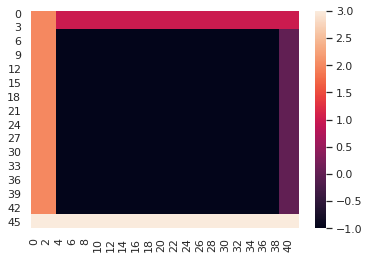

In [95]:
border_width = track_params.border_dist_bin  
map_height, map_width = fr_map.shape # in bins
border_wide_mask = np.ones_like(fr_map, dtype=int)*-1
border_wide_mask[:, map_width:(map_width-border_width):-1] = 0 # right / East
border_wide_mask[0:border_width,:] = 1 # top / North
border_wide_mask[:, 0:border_width] = 2 # left / West
border_wide_mask[map_height:(map_height-border_width):-1,:] = 3 # bottom / Sout

sns.heatmap(border_wide_mask)

In [74]:
def get_distance_mat(h,w):

    a = np.arange(h)
    b = np.arange(w)
    
    r_h = np.minimum(a,a[::-1])
    r_w = np.minimum(b,b[::-1])
    pyr = np.minimum.outer(r_h,r_w)
    return pyr/np.max(pyr)

def get_wall_labels(map_height, map_width, wall_width):
    
    mask = np.ones((4,map_height, map_width), dtype=int)*-1

    mask[0][:, map_width:(map_width-wall_width):-1] = 0 # right / East
    mask[1][0:wall_width,:] = 1 # top / North
    mask[2][:, 0:wall_width] = 2 # left / West
    mask[3][map_height:(map_height-wall_width):-1,:] = 3 # bottom / South

    return mask

def get_map_fields(fr_maps, fr_thr=0.3, min_field_size=20, filt_structure=None):
    """
    gets labeled firing rate maps. works on either single maps or an array of maps.
    returns an array of the same dimensions as fr_maps with 
    :param fr_maps: np.ndarray, (dimensions can be 2 or 3), if 3 dimensions, first dimensions must 
                    correspond to the # of units, other 2 dims are height and width of the map
    :param fr_thr: float, proportion of the max firing rate to threshold the data
    :param min_field_size: int, # of bins that correspond to the total area of the field. fields found 
                    under this threshold are discarded
    :param filt_strcutre: 3x3 array of connectivity. see ndimage for details
    :return field_labels (same dimensions as input), -1 values are background, each field has an int label
    
    -> code based of the description on Solstad et al, Science 2008
    """
    if filt_structure is None:
        filt_structure = np.ones((3,3))
    
    # add a singleton dimension in case of only one map to find fields.
    if fr_maps.ndim == 2:
        fr_maps = fr_maps[np.newaxis,:,:]
    elif fr_maps.ndim ==1:
        print('fr_maps is a one dimensional variable.')
        return None
    
    n_units, map_height, map_width = fr_maps.shape
    
    # create border mask to avoid elimating samples during the image processing step
    border_mask = np.ones((map_height,map_width), dtype=bool)
    border_mask[[0,-1],:] = False
    border_mask[:,[0,-1]] = False
    
    # determine thresholds
    max_fr = fr_maps.max(axis=1).max(axis=1)
    
    # get fields
    field_maps = np.zeros_like(fr_maps)
    n_fields = np.zeros(n_units, dtype=int)
    for unit in range(n_units):
        # threshold the maps
        thr_map = fr_maps[unit] >= max_fr[unit]*fr_thr
        
        # eliminates small/noisy fields, fills in gaps
        thr_map = ndimage.binary_closing(thr_map, structure=filt_structure, mask=border_mask)
        thr_map = ndimage.binary_dilation(thr_map, structure=filt_structure)
    
        # get fields ids
        field_map, n_fields_unit = ndimage.label(thr_map, structure=filt_structure)
        
        # get the area of the fields in bins
        field_sizes = np.zeros(n_fields_unit)
        for f in range(n_fields_unit):
            field_sizes[f] = np.sum(field_map==f)
            
        # check for small fields and re-do field identification if necessary
        if np.any(field_sizes<min_field_size):
            small_fields = np.where(field_sizes<min_field_size)[0]
            for f in small_fields:
                thr_map[field_map==f] = 0
            field_map, n_fields_unit = ndimage.label(thr_map, structure=filt_structure)
        
        # store
        field_maps[unit] = field_map
        n_fields[unit] = n_fields_unit
    
    field_maps -= 1 # make background -1, labels start at zero
    
    # if only one unit, squeeze to match input dimensions
    if n_units==1:
        field_maps = field_maps.squeeze()
        
    return field_maps, n_fields

def get_border_scores(fr_maps, params, field_maps=None):
    """
    
    -> code based of the description on Solstad et al, Science 2008
    """
    n_walls = 4
    # add a singleton dimension in case of only one map to find fields.
    if fr_maps.ndim == 2:
        fr_maps = fr_maps[np.newaxis,]
    n_units, map_height, map_width = fr_maps.shape 
    
    # refactor parameters
    p = SimpleNamespace(**params)
    
    # get fields
    if field_maps is None:
        field_maps, n_fields = get_map_fields(fr_maps, fr_thr=p.fr_thr, min_field_size=p.min_field_size_bins)
    
    if field_maps.ndim ==2:
        field_maps = field_maps[np.newaxis,]

    # get border distance matrix
    distance_mat = get_distance_mat(map_height,map_width) # linear distance to closest wall [bins]
    
    # get wall labels
    wall_labels_mask = get_wall_labels(map_height, map_width, p.wall_width_bin)
    
    # pre-allocate scores
    border_score = np.zeros(n_units)*np.nan
    max_coverage = np.zeros(n_units)*np.nan
    weighted_fr = np.zeros(n_units)*np.nan
    
    # loop and get scores
    for unit in range(n_units):
        fr_map = fr_maps[unit]
        field_map = field_maps[unit]
        n_fields_unit = n_fields[unit]
        if n_fields_unit > 0:
            # get coverage
            wall_coverage = np.zeros((n_fields_unit,n_walls))
            for field in range(n_fields_unit):
                for wall in range(n_walls):
                    wall_coverage[field,wall] = np.sum((field_map==field)*(wall_labels_mask[wall]==wall))/np.sum(wall_labels_mask[wall]==wall)
            print(wall_coverage)
            c_m = np.max(wall_coverage)
            
            # get normalized distanced weighted firing rate
            field_fr_map = fr_map*(field_map>=0)
            d_m = np.sum(field_fr_map*distance_mat)/np.sum(field_fr_map)
            
            # get border score
            b = (c_m-d_m)/(c_m+d_m)

            border_score[unit] = b
            max_coverage[unit] = c_m
            weighted_fr[unit] = d_m
    
    return border_score, max_coverage, weighted_fr


In [286]:
border_score_params = {'fr_thr': 0.25, 'min_field_cm2': 180, 'min_field_size_bins': 20,'cm_bin': 3, 'cm2_bin': 9, 'wall_width_bin': 2}
get_border_scores(fr_maps, border_score_params)

(array([ 0.50883982,  0.19084953,  0.37685255,  0.49039307,  0.13997581,
         0.52537673,  0.40178044,  0.46679849, -0.04828306,  0.386764  ,
         0.57838982,  0.43741678,  0.45321565,  0.46217321,  0.44512479,
         0.27680883,  0.04298929, -0.03600532,  0.47188181, -0.21231374,
         0.52652025,  0.14006751,  0.45417894, -0.2665978 ,  0.16266578,
         0.50230922,  0.47775977,  0.43765009,  0.46871681,  0.41732915,
         0.23963424,  0.4199814 ]),
 array([1.        , 0.5952381 , 0.86956522, 0.95652174, 0.33333333,
        0.76086957, 0.80952381, 0.98913043, 0.23913043, 0.58695652,
        0.76190476, 0.54761905, 0.73913043, 0.98913043, 0.86956522,
        0.63636364, 0.22826087, 0.13636364, 0.88043478, 0.27272727,
        0.97826087, 0.54545455, 0.84782609, 0.23809524, 0.26190476,
        1.        , 0.98913043, 0.9673913 , 0.98913043, 0.85714286,
        0.43181818, 0.91304348]),
 array([0.32552175, 0.4044484 , 0.3935551 , 0.32706144, 0.25147439,
        0.236745

### test border score method

In [80]:
def test_border_score(height=50,width=30):

    print('Border Score for an east single wall')
    dummy_mat = np.zeros((height, width))
    dummy_mat[:,-1]=1 # 
    print(get_border_scores(dummy_mat, border_score_params)[0])

    print('Border Score for a north single wall')
    dummy_mat = np.zeros((height, width))
    dummy_mat[0,:]=1 # 
    print(get_border_scores(dummy_mat, border_score_params)[0])

    print('Border Score for a west single wall')
    dummy_mat = np.zeros((height, width))
    dummy_mat[:,0]=1 # 
    print(get_border_scores(dummy_mat, border_score_params)[0])

    print('Border Score for a south single wall')
    dummy_mat = np.zeros((height, width))
    dummy_mat[-1,:]=1 # 
    print(get_border_scores(dummy_mat, border_score_params)[0])

    print('Border Score for center region')
    dummy_mat = np.zeros((height, width))
    dummy_mat[(height//2-2):(height//2+2),(width//2-2):(width//2+2)]=1
    print(get_border_scores(dummy_mat, border_score_params)[0])

    print('Border Score for thick wall')
    dummy_mat = np.zeros((height, width))
    dummy_mat[0:5,:]=1
    print(get_border_scores(dummy_mat, border_score_params)[0])

    print('Border Score for full coverage')
    dummy_mat = np.ones((height, width))
    print(get_border_scores(dummy_mat, border_score_params)[0])

    print('Border Score for full coverage')
    dummy_mat = np.zeros((height, width))
    print(get_border_scores(dummy_mat, border_score_params)[0])

test_border_score()

Border Score for an east single wall
[[1.         0.06666667 0.         0.06666667]]
[1.]
Border Score for a north single wall
[[0.04 1.   0.04 0.  ]]
[1.]
Border Score for a west single wall
[[0.         0.06666667 1.         0.06666667]]
[1.]
Border Score for a south single wall
[[0.04 0.   0.04 1.  ]]
[1.]
Border Score for center region
[[0. 0. 0. 0.]]
[-1.]
Border Score for thick wall
[[0.12 1.   0.12 0.  ]]
[0.77966102]
Border Score for full coverage
[[1. 1. 1. 1.]]
[0.4354067]
Border Score for full coverage
[[1. 1. 1. 1.]]
[nan]


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in double_scalars


In [84]:
border_score_params = {'fr_thr': 0.25, 'min_field_cm2': 180, 'min_field_size_bins': 20,'cm_bin': 3, 'cm2_bin': 9, 'wall_width_bin': 2}

height = 47
width = 42
# dummy_mat = np.zeros((height, width))
# dummy_mat[(height//2-2):(height//2+2),(width//2-2):(width//2+2)]=1
dummy_mat = np.ones((height, width))

get_border_scores(dummy_mat, border_score_params)
#sns.heatmap(get_map_fields(dummy_mat)[0])

[[1. 1. 1. 1.]]


(array([0.48812665]), array([1.]), array([0.34397163]))

In [83]:
fr_maps.shape

(32, 47, 42)

In [79]:
d=get_distance_mat(height,width)
np.sum((d*dummy_mat))/np.sum(dummy_mat)

0.325

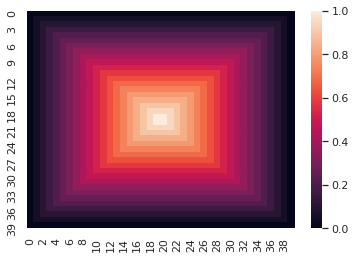

In [77]:
dummy_mat = np.ones((height, width))
#sns.heatmap(dummy_mat)
sns.heatmap(d)

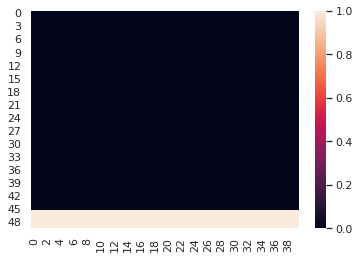

In [21]:
sns.heatmap(get_wall_labels(height,width,5)[3]==3)
#sns.heatmap(get_map_fields(dummy_mat)[0])

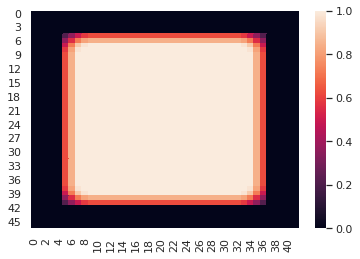

In [37]:
mask = np.zeros_like(of_dat.pos_map_secs)
nb =5
mask[0:nb,:]=1
mask[:,0:nb]=1
mask[:,(nh-nb):nh]=1
mask[(nv-nb):nv:,:]=1
#ax=sns.heatmap(mask)

#sns.heatmap(fr_maps[unit]*mask)
sm_mask=spatial_funcs.get_smoothed_map(mask, track_params.spatial_window_size, track_params.spatial_sigma)
sm_mask[0:nb,:]=1
sm_mask[:,0:nb]=1
sm_mask[:,(nh-nb):nh]=1
sm_mask[(nv-nb):nv:,:]=1
sns.heatmap(1-sm_mask)


In [41]:
p = track_params
x_mask = np.logical_or(of_dat.x<=(p.x_cm_lims[0]+p.boder_dist_cm), of_dat.x>=(p.x_cm_lims[1]+p.boder_dist_cm) )
y_mask = np.logical_or(of_dat.x<=(p.y_cm_lims[0]+p.boder_dist_cm), of_dat.x>=(p.y_cm_lims[1]+p.boder_dist_cm) )
border_samps = np.logical_or(x_mask, y_mask)
border_samps.sum()

17508

In [42]:
center_samps = ~border_samps

array([False, False, False, ...,  True,  True,  True])

## Get speed scores

In [9]:
spatial_funcs = reload(spatial_funcs)

scores, sp_bin_centers, model_coef, model_coef_s  = spatial_funcs.get_speed_score_discrete(of_dat.sp, fr, track_params.speed_bin, track_params.min_speed_thr, track_params.max_speed_thr, track_params.sig_alpha, track_params.n_perm)

In [11]:
spatial_funcs = reload(spatial_funcs)
scores_t, model_coef_t, model_coef_s_t = spatial_funcs.get_speed_score_traditional(of_dat.sp, fr, track_params.min_speed_thr, track_params.max_speed_thr, track_params.sig_alpha, track_params.n_perm)

### get angle score

In [21]:
spatial_funcs = reload(spatial_funcs)
unit = 0 
stats, w_counts, bin_centers, _ = spatial_funcs.get_angle_stats(of_dat.hd, track_params.rad_bin, weights=fr[unit])

In [52]:
spatial_funcs = reload(spatial_funcs)
scores, model_coef, model_coef_s, ang_bin_centers = spatial_funcs.get_angle_scores(of_dat.hd, fr, track_params.rad_bin,
                                                                                  of_dat.sp, track_params.min_speed_thr, 
                                                                                  track_params.max_speed_thr, 
                                                                                  track_params.sig_alpha)

<BarContainer object of 36 artists>

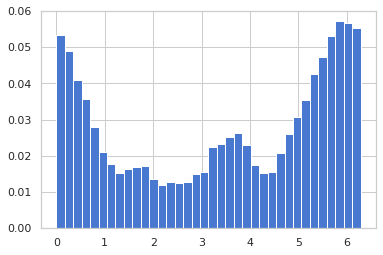

In [48]:
plt.bar(ang_bin_centers, model_coef[6]/model_coef[6].sum(),width=track_params.rad_bin)

In [49]:
scores

vec_len   mean_ang    sig       aR2       rmse     nrmse
0   0.00296378    1.12674  False  0.020154  20.897231  0.842603
1     0.140538   0.575758   True  0.072632   9.992236  1.633500
2     0.281263    1.48456   True  0.051095   8.194177  1.877444
3    0.0682577    2.24707  False  0.009150   6.741989  1.718977
4     0.317859  0.0430137   True  0.076293   9.852327  2.176025
5     0.290844    2.96596   True  0.094270   6.672701  1.754197
6     0.318225    5.88717   True  0.230632  13.015111  0.978232
7     0.214049     2.2393   True  0.021924   5.738934  1.938810
8    0.0677305    3.41532  False  0.001544   2.888719  3.814629
9     0.102426    3.78631  False  0.006520   5.977538  2.010186
10   0.0705889    2.57793  False  0.006296   6.148087  1.859900
11   0.0152636    5.46678  False  0.001366   4.202803  2.697640
12    0.106342    2.37748  False  0.013837  10.337503  2.440359
13   0.0504575    6.17571  False  0.022115  17.786818  0.696021
14   0.0402516    6.00075  False  0.001328   6.346881  1.816400
15    0.149863   0.454303  False  0.016083   5.383947  2.107327
16   0.0425596    3.30407  False  0.002655   2.800583  3.900567
17      0.1099    5.30998  False  0.007188  15.263797  3.451110
18   0.0738235    4.94429  False  0.006100  12.790782  1.435222
19   0.0902299    4.88305  False  0.010212  10.857247  1.597993
20   0.0319417     5.7148  False  0.006268  23.338711  1.286566
21   0.0923622     5.2692  False  0.009231  10.454059  1.549113
22   0.0745934     4.8478  False  0.007043  15.001885  1.646426
23     0.01581    2.54421  False  0.004110  28.639552  5.072535
24   0.0977892    4.43181  False  0.002007   3.067887  3.684087
25   0.0134913    2.68555  False  0.001706   7.002264  1.606684
26   0.0287996    4.26376  False  0.003202   7.487591  1.542195
27   0.0593644    3.94666  False  0.021706  23.828502  0.864078
28   0.0199395    2.56781  False  0.007947  14.457716  1.000174
29   0.0976367      1.198  False  0.008520   6.821399  1.837939
30    0.199575    1.07959  False  0.014471   3.602116  3.193269
31   0.0453631   0.690185  False  0.008531  11.769777  0.964389

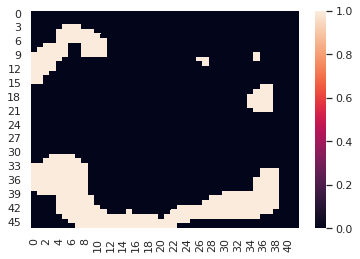

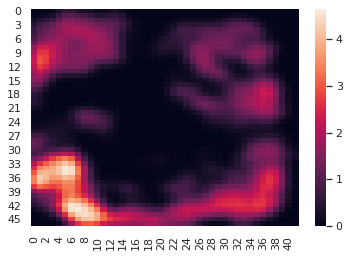

array([-62.59580816,  60.23078349])

In [43]:
np.abs(np.sum(model_coef[6]*np.exp(1j * ang_bin_centers)))

156.7563052317286

In [34]:
fr_hat.shape, fr_valid.shape, n_samps, of_track_dat.sp.shape

((32, 31132), (32, 31132), 31132, (36095,))

In [38]:
rs.get_ar2(fr_valid, fr_hat, 1)

array([ 7.65952777e-03,  1.03453993e-02,  1.15360603e-03,  6.13391178e-03,
        2.59127099e-02,  1.53074521e-03, -2.29824284e-05,  1.13009348e-02,
        1.33714874e-04,  1.06660299e-03,  4.38207083e-04,  9.60497481e-03,
       -2.52884724e-05,  1.72601686e-02,  1.34747440e-02,  7.15572143e-03,
        5.62702178e-04,  4.84713020e-02,  2.55875987e-03,  7.76481367e-04,
        4.13346637e-02,  9.20212794e-04,  1.69700778e-03,  6.05112380e-05,
        2.20818096e-03,  8.09196592e-03,  1.38115483e-02,  1.03372514e-01,
        2.85923619e-02,  9.74768705e-03,  5.75049976e-04,  2.04185912e-02])

(array([832., 776., 840., 737., 667., 655., 570., 599., 553., 526.]),
 array([2.00077527, 2.60058086, 3.20038646, 3.80019205, 4.39999765,
        4.99980324, 5.59960884, 6.19941443, 6.79922003, 7.39902562,
        7.99883122]),
 <a list of 10 Patch objects>)

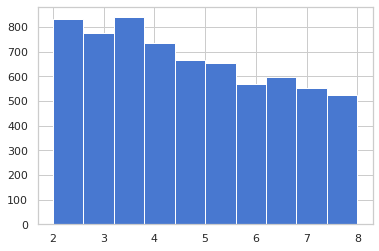

In [32]:
plt.hist(speed_valid)

In [538]:
sp = of_track_dat.sp
min_speed = 2
max_speed = 80
sp_bin_step = 2
sp_valid_idx = np.logical_and(sp>=min_speed, sp<max_speed)
sp_valid = sp[sp_valid_idx]

sp_bin_edges = np.arange(min_speed,max_speed+sp_bin_step, sp_bin_step)
sp_bin_centers = sp_bin_edges[:-1]+sp_bin_step/2
n_sp_bins = len(sp_bin_centers)

sp_ids = np.digitize(sp_valid, bins=sp_bins)
sp_ids = sp_ids-1 # because we had already thresholded speed, need to shift array
assert np.all(sp_ids>=0)

n_samps = len(sp_valid)
design_matrix = np.zeros((n_samps, n_sp_bins))
for i in range(n_sp_bins):
    design_matrix[:,i] = sp_ids==i

### method mean by bin

In [567]:
fr_valid = fr[:, sp_valid_idx]
fr_sp_m = np.zeros( (4, n_units, n_sp_bins) )
fr_sp_s = np.zeros( (n_units, n_sp_bins) )

sp_score = np.zeros((4, n_units))
sp_occ,_ = np.histogram(sp_valid, sp_bin_edges)

for i in range(len(sp_bins)-1):
    fr_sp_m[0, :, i] = np.mean(fr_valid[:, sp_ids == i], axis=1)
    fr_sp_s[:,i] = stats.sem(fr_valid[:, sp_ids == i], axis=1)

### method by weighted histogram

In [599]:
for unit in range(n_units):
    m,_ = np.histogram(sp_valid, sp_bin_edges, weights=fr_valid[unit])
    fr_sp_m[1, unit, :] = m/sp_occ

### method by linear regression

In [600]:
res = lm.LinearRegression(fit_intercept=False).fit(design_matrix, fr_valid.T)
fr_sp_m[2,:,:] = res.coef_

### method by ols statsmodels

In [658]:
import statsmodels.api as sm

for unit in range(n_units):
    model = sm.OLS(fr_valid[unit],design_matrix)
    results = model.fit()
    fr_sp_m[3,unit,:] = results.params

## compare results

In [659]:
for jj in range(4):
    for unit in range(n_units):
        sp_score[jj, unit] = spearman(fr_sp_m[jj,unit],sp_bin_centers)

In [661]:
np.corrcoef(sp_score)

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

### simple line /intercept method

In [692]:
sp2_valid = np.column_stack((np.ones(len(sp_valid)), sp_valid))
model = lm.LinearRegression(fit_intercept=False).fit(sp2_valid, fr_valid.T)

In [693]:
model.coef_[0]

array([27.32810099, -0.09581259])

In [690]:
unit=0
model = sm.OLS(fr_valid[unit],sm.add_constant(sp_valid))
results = model.fit()
results.params

array([27.32810099, -0.09581259])

In [701]:
get_ar2(fr_valid[unit],results.predict(sm.add_constant(sp_valid)),1)

array([0.00765953])

In [695]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.008      
Dependent Variable: y                AIC:                278040.9680
Date:               2020-08-13 13:07 BIC:                278057.6600
No. Observations:   31132            Log-Likelihood:     -1.3902e+05
Df Model:           1                F-statistic:        241.3      
Df Residuals:       31130            Prob (F-statistic): 3.29e-54   
R-squared:          0.008            Scale:              442.79     
----------------------------------------------------------------------
             Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------
const       27.3281     0.2017   135.4697   0.0000   26.9327   27.7235
x1          -0.0958     0.0062   -15.5335   0.0000   -0.1079   -0.0837
--------------------------------------------------------------------
Omnibus:             5104.575       Durbin-Watson:          0.153   
Prob(Omnibus):       0.000          Jarque-Bera (JB):       8690.394
Skew:                1.084          Prob(JB):               0.000   
Kurtosis:            4.415          Condition No.:          55      
====================================================================

"""

In [703]:
f_hat=results.predict(sm.add_constant(sp_valid))

In [709]:
s = np.std(f_hat-fr_valid[unit])*np.sqrt((n_samps-1)/(n_samps-2))
se_b0 = s*np.sqrt(1+sp_valid.mean()**2/np.var(sp_valid)) / np.sqrt(n_samps)

se_b1 = s/np.sqrt(n_samps)*1/np.std(sp_valid)
print(se_b0,se_b1)

0.20172534297912195 0.006168031880025084


In [710]:
s

21.042213098191905

In [679]:
def get_r2(y, y_hat):
    """
    Coefficient of determination for vectors.
    :param y: array n_samps of dependent variable
    :param y_hat: array of n_samps as a result of a prediction
    :return: R2. float.
    """
    if y.ndim == 1:
        y = y.reshape(1, -1)
        y_hat = y_hat.reshape(1, -1)
    y_bar = y.mean(axis=1)
    y_bar = y_bar.reshape(-1,1)
        
    return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)

In [677]:
fr_hat = fr_sp_m[1,:,:] @ design_matrix.T


In [685]:

get_mse(fr_valid, fr_hat)
#num = ((fr_valid-fr_hat)**2).sum(axis=1)
#fr_valid-np.mean(fr_valid,axis=1)

array([430.04661894, 106.48214844,  70.63466967,  45.38164746,
        99.27332897,  48.91622408, 217.18773603,  32.98793247,
         8.34715987,  35.91514804,  38.01891918,  17.42747782,
       108.08778394, 316.81089367,  39.64731344,  29.14811116,
         7.8485531 , 217.36345615, 163.61182252, 118.58668196,
       524.09490845, 109.86935218, 225.75664524, 822.46404393,
         9.39360911,  48.53458107,  55.42824913, 520.00922387,
       204.17132111,  46.45558095,  13.15407327, 136.65211589])

In [687]:
unit=1
y=fr_valid[unit]
y_hat=fr_hat[unit]

get_r2(y,y_hat)

array([0.01212684])

In [688]:
np.mean(((y-y_hat)**2))

106.48214844494588

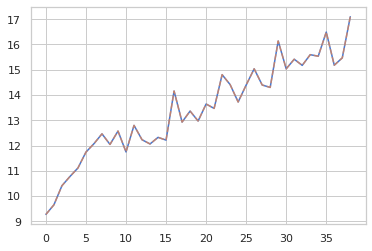

In [544]:
plt.plot(sp_fr)
plt.plot(fr_sp_m[31], '--', alpha=0.7)

In [483]:
fr_sp_m.shape, sp_fr.shape

((32, 40), (39,))

Object `sm.ols` not found.


In [436]:
np.sqrt(np.mean((fr_sp_m @ design_matrix.T - fr)**2,axis=1))/fr.mean(axis=1), rmse_dis

(array([0.9131934 , 1.71471414, 1.96561959, 1.76907767, 2.20433848,
        1.866976  , 1.14391912, 2.00779257, 3.82886351, 2.03119805,
        1.90145548, 2.75518666, 2.5187764 , 0.76068164, 1.85570032,
        2.18133662, 4.00058633, 3.0215473 , 1.46432657, 1.63425985,
        1.30398176, 1.59002714, 1.65637914, 5.27958918, 3.80046155,
        1.64648657, 1.58279463, 0.87533576, 1.04080961, 1.87911529,
        3.28013758, 1.0093489 ]),
 array([0.9131934 , 1.71471414, 1.96561959, 1.76907767, 2.20433848,
        1.866976  , 1.14391912, 2.00779257, 3.82886351, 2.03119805,
        1.90145548, 2.75518666, 2.5187764 , 0.76068164, 1.85570032,
        2.18133662, 4.00058633, 3.0215473 , 1.46432657, 1.63425985,
        1.30398176, 1.59002714, 1.65637914, 5.27958918, 3.80046155,
        1.64648657, 1.58279463, 0.87533576, 1.04080961, 1.87911529,
        3.28013758, 1.0093489 ]))

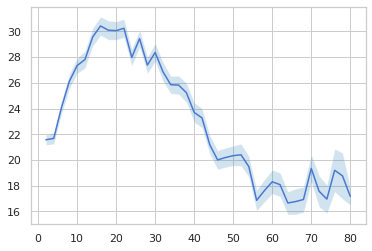

In [368]:
unit=0
f,ax = plt.subplots()        
_= ax.plot(sp_bins, fr_sp_m[unit])
_= ax.fill_between(sp_bins, fr_sp_m[unit]-fr_sp_s[unit], fr_sp_m[unit]+fr_sp_s[unit], facecolor='tab:blue', alpha=0.2)


In [449]:
x=np.zeros((1,100))
x[0]=np.arange(100)
x[0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [177]:
np.corrcoef(sp_bins,fr_sp[0])

array([[ 1.        , -0.63971476],
       [-0.63971476,  1.        ]])

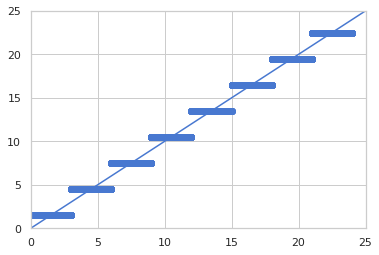

In [103]:
plt.scatter(sp,sp_discrete)
plt.xlim(0,25),
plt.ylim(0,25)
plt.plot([0,25],[0,25])

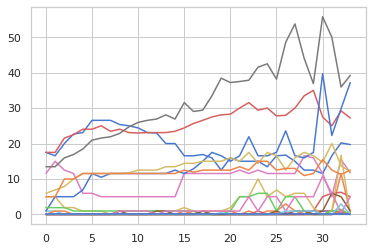

In [300]:
_=plt.plot(fr_sp.T)


In [373]:

# sp2 = np.column_stack((np.ones(len(sp)), sp))
# slopes = np.zeros(n_units)
# ar2 = np.zeros(n_units)
# rmse = np.zeros(n_units)
n_units = session_info.n_units
sp_score = np.zeros(n_units)
sig_sp_score = np.zeros(n_units)
sp_score_pval = np.zeros(n_units)
sp_valid = np.logical_or( sp>=2, sp<=80)
for unit in range(n_units):
#     res = lm.LinearRegression(fit_intercept=False).fit(sp2, fr[unit])
#     slopes[unit]=res.coef_[1]
#     fr_hat = res.predict(sp2)
#     ar2[unit] = get_ar2(fr[unit], fr_hat,1)
#     rmse[unit] = get_nrmse(fr[unit], fr_hat)
    sp_score[unit], sp_score_pval[unit] = stats.spearmanr(sp[sp_valid],fr[unit][sp_valid])

    #sp_score[unit] = spearman(sp,fr[unit])
    sig_sp_score[unit], _ = permutation_test(sp, fr[unit], spearman, n_perm=100)

In [356]:
sp_score

array([-0.03201776,  0.09390081, -0.00659944,  0.12782071, -0.18185802,
       -0.04007809, -0.0448529 ,  0.17547682, -0.00414927, -0.05586335,
       -0.03092611,  0.14464856,  0.06579958,  0.16038789,  0.16198276,
        0.14964059,  0.0495296 , -0.35547771, -0.00556005, -0.02247836,
        0.20861895, -0.01660388, -0.00348127,  0.05071845,  0.08195079,
        0.12265178,  0.15967838,  0.30913352,  0.18482764,  0.13654233,
        0.04613816,  0.17197801])

In [276]:
unit = np.argmin(np.abs(sp_score))
sp_score[unit]

a,b = permutation_test(sp,fr[unit], spearman)

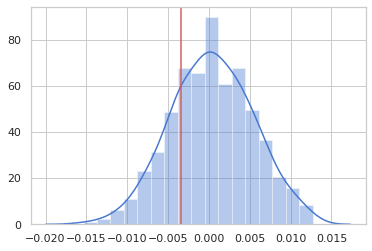

In [266]:
ax=sns.distplot(b)
ax.axvline(sp_score[unit], color='r')

In [284]:
alpha2=0.025
x=(b>=sp_score[unit]).mean()
x, alpha2, x<=alpha2 or x>=1-alpha2

(0.768, 0.025, False)

In [268]:
a,v=stats.spearmanr(sp,fr[unit])
a,v

(-0.003481269636356525, 0.5083721609151224)

In [684]:
def get_r2(y, y_hat):
    """
    Coefficient of determination for vectors.
    :param y: array n_samps of dependent variable;
        can also work with matrices organized as n_samps x n_predictions
    :param y_hat: array with result of a prediction, same shape as y
    :return: R2. float. or array if y,y_hat are matrices. in that case r2 is an array of length n_predictions
    """
    if y.ndim == 1:
        y = y.reshape(1, -1)
        y_hat = y_hat.reshape(1, -1)
    y_bar = y.mean(axis=1)
    y_bar = y_bar.reshape(-1, 1)

    return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)


def get_ar2(y, y_hat, p):
    """
    Adjusted coefficient of determination for number of parameters used in the prediction.
    :param y: array n_samps of dependent variable;
        can also work with matrices organized as n_samps x n_predictions
    :param y_hat: array with result of a prediction, same shape as y
    :param p: number of parameters used in the estimation, excluding bias
    :return: aR2: flaot, adjusted R2. or array if y,y_hat are matrices.
                in that case r2 is an array of length n_predictions
    """
    if y.ndim == 1:
        y = y.reshape(1, -1)
        y_hat = y_hat.reshape(1, -1)
    n = y.shape[1]
    return 1 - (1 - get_r2(y, y_hat)) * (n - 1) / (n - p - 1)


def get_mse(y, y_hat):
    """
    Mean Square Error Calculation
    :param y: array n_samps of dependent variable;
        can also work with matrices organized as n_samps x n_predictions
    :param y_hat: array with result of a prediction, same shape as y
    :return: mse: float. mean square error. or array of length n_predictions
    """
    if y.ndim == 1:
        y = y.reshape(1, -1)
        y_hat = y_hat.reshape(1, -1)
    return np.mean((y - y_hat) ** 2, axis=1)


def get_rmse(y, y_hat):
    """
    Root Mean Square Error Calculation
    :param y: array n_samps of dependent variable;
        can also work with matrices organized as n_samps x n_predictions
    :param y_hat: array with result of a prediction, same shape as y
    :return: rmse: float. root mean square error, or array of length n_predictions
    """
    return np.sqrt(get_mse(y, y_hat))


def get_nrmse(y, y_hat):
    """
    Normalized Root Mean Square Error Calculation.
    Divides the RMSE by the mean of variable y
    :param y: array n_samps of dependent variable
    :param y_hat: array of n_samps as a result of a prediction
    :return: nrmse: float. normalize root mean square error, or array of length n_predictions
    """
    if y.ndim == 1:
        y = y.reshape(1, -1)
        y_hat = y_hat.reshape(1, -1)
    return get_rmse(y, y_hat) / np.mean(y, axis=1)

def permutation_test(x,y,func,n_perm=500, alpha=0.02, seed=0):
    np.random.seed(seed)
    perm_out = np.zeros(n_perm)
    real_out = func(x,y)
    
    for p in range(n_perm):
        x_p = np.random.permutation(x)
        perm_out[p] = func(x_p,y)
    
    loc = (perm_out>=real_out).mean()
    
    outside_dist = loc<=alpha/2 or loc>=1-alpha/2
    return outside_dist, perm_out
    
def _spearman(x,y):
    return stats.spearmanr(x,y)[0]

def _kendall(x,y):
    return stats.kendalltau(x,y)[0]

def _pearson(x,y):
    return stats.pearsonr(x,y)[0]


In [235]:
alpha = 0.05
n =100
real_val = 99
y = (np.arange(100) >= real_val).mean()
print(y), print(alpha/2), print(1-alpha/2)
y <= alpha/2 or y>=1-alpha/2

0.01
0.025
0.975


True

In [394]:
#sp2 = np.column_stack((np.ones(len(sp)), design_matrix))
sp2 = design_matrix
n_units = session_info.n_units
ar2_dis = np.zeros(n_units)
rmse_dis = np.zeros(n_units)
sp_score_dis = np.zeros(n_units)
coefs = np.zeros((n_units,n_sp_bins))
for unit in range(n_units):
    res = lm.LinearRegression(fit_intercept=False).fit(sp2, fr[unit])
    fr_hat = res.predict(sp2)
    ar2_dis[unit] = get_ar2(fr[unit], fr_hat, n_sp_bins)
    rmse_dis[unit] = get_nrmse(fr[unit], fr_hat)
    #coefs[unit] = res.coef_[1:]
    coefs[unit] = res.coef_
    #sp_score_dis[unit] = np.corrcoef(sp_bins,res.coef_[1:])[0,1]
    sp_score_dis[unit] = np.corrcoef(sp_bins,res.coef_)[0,1]

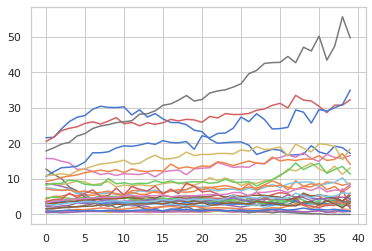

In [395]:
_=plt.plot(coefs.T)

In [460]:
x=pd.DataFrame(index=range(10), columns=['a','b','c'])
x['a']=np.arange(10)
x

a    b    c
0  0  NaN  NaN
1  1  NaN  NaN
2  2  NaN  NaN
3  3  NaN  NaN
4  4  NaN  NaN
5  5  NaN  NaN
6  6  NaN  NaN
7  7  NaN  NaN
8  8  NaN  NaN
9  9  NaN  NaN

In [426]:
(design_matrix @ fr_sp_m.T).mean()
for unit in 


6.523976325115839

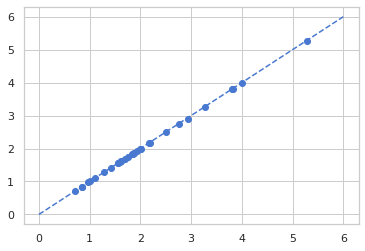

In [151]:
plt.scatter(rmse, rmse_dis)
max_val = 6
plt.plot([0,max_val],[0,max_val],'--')

array([[ 1.        , -0.31163873],
       [-0.31163873,  1.        ]])

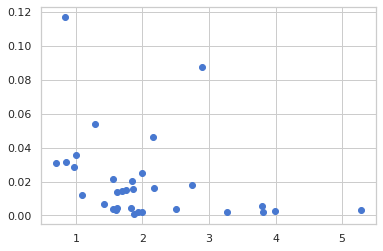

In [155]:
plt.scatter(rmse_dis,ar2_dis)
np.corrcoef(rmse_dis,ar2_dis)

array([[ 1.        , -0.31464363],
       [-0.31464363,  1.        ]])

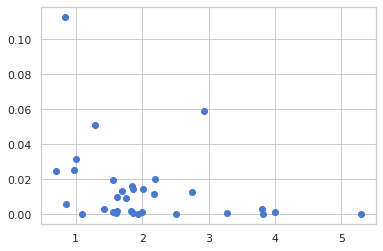

In [156]:
plt.scatter(rmse,ar2)
np.corrcoef(rmse,ar2)

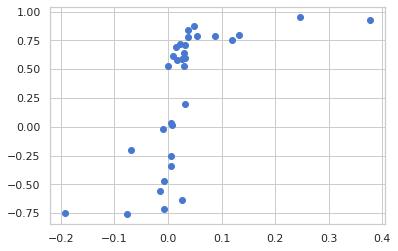

In [170]:
plt.scatter(sp_score,sp_score_dis)

In [66]:
c = np.zeros(session_info.n_units)
for unit in range(session_info.n_units):
    c[unit] = np.corrcoef(fr_maps[unit].flatten(), fr_maps2[unit].flatten())[0,1]

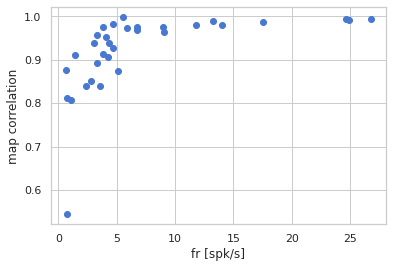

In [82]:
f,ax=plt.subplots()
ax.scatter(fr.mean(axis=1),c)
ax.set_xlabel('fr [spk/s]')
ax.set_ylabel('map correlation')
f.savefig('corr_fr.jpeg')

In [6]:
session_info.__class__.__dict__.keys()

dict_keys(['__module__', '__init__', 'get_time', 'get_raw_track_data', 'get_sorted_tt_dir', 'get_tt_info', 'get_tt_data', 'get_spikes', 'get_binned_spikes', 'get_fr', 'get_spike_maps', 'get_fr_maps', 'get_track_data', '__doc__'])

In [11]:
session_info.get_spikes

<bound method SubjectSessionInfo.get_spikes of <TreeMazeAnalyses2.Analyses.subject_info.SubjectSessionInfo object at 0x7ff9106a4cc0>>

In [9]:
def foo(a):
    if a >0:
        def foo2(b):
            return b
    else:
        def foo2(b):
            return b**2
    return foo2

foo(-1)(2)

4

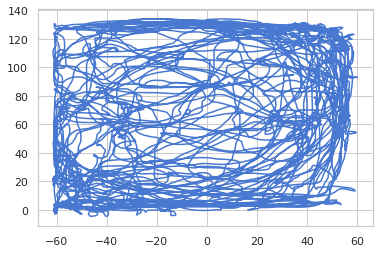

In [10]:
plt.plot(of_track_dat.x,of_track_dat.y)

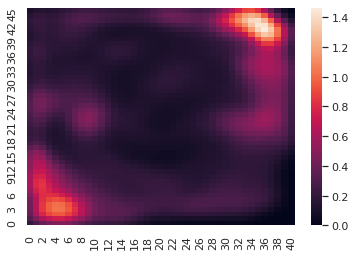

In [12]:
ax=sns.heatmap(of_track_dat.occ_secs)
ax.invert_yaxis()

In [15]:
of_track_dat.hd_stats, of_track_dat.ha_stats

({'r': 28.84468719698725,
  'ang': 2.0712524845854063,
  'R': 33.183017243222295,
  'p_val': 3.849530279921874e-15},
 {'r': 274.2490142671288,
  'ang': -2.662743628777634,
  'R': 2951.5875702544895,
  'p_val': 0.0})

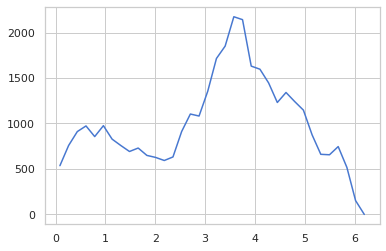

In [25]:
counts,bin_centers,_=spatial_funcs.get_angle_hist(of_track_dat.ha, np.deg2rad(10))
plt.plot(bin_centers,counts)

In [29]:
session_info.task_params

{'x_pix_lims': [100, 650],
 'y_pix_lims': [100, 500],
 'x_pix_bias': -380,
 'y_pix_bias': -280,
 'vt_rate': 0.016666666666666666,
 'xy_pix_rot_rad': 1.6507963267948966,
 'x_pix_mm': 3.7790697674418605,
 'y_pix_mm': 3.265765765765766,
 'x_mm_bias': 0,
 'y_mm_bias': 650,
 'x_mm_lims': [-620, 620],
 'y_mm_lims': [-50, 1350],
 'x_cm_lims': [-62, 62],
 'y_cm_lims': [-5, 135],
 'mm_bin': 30,
 'cm_bin': 3,
 'max_speed_thr': 80,
 'min_speed_thr': 0.5,
 'rad_bin': 0.17453292519943295,
 'time_thr': 0.05,
 'spatial_sigma': 1.5,
 'spatial_window_size': 5,
 'temporal_window_size': 7,
 'temporal_angle_window_size': 7,
 'temporal_window_type': 'hann',
 'filter_coef': array([0.        , 0.08333333, 0.25      , 0.33333333, 0.25      ,
        0.08333333, 0.        ]),
 'filter_coef_angle': array([0.        , 0.08333333, 0.25      , 0.33333333, 0.25      ,
        0.08333333, 0.        ])}

In [12]:
a = np.empty(10)
a[:] = np.NaN
#a>10
with np.errstate(invalid='ignore'):
    a>10


In [7]:
p = SimpleNamespace(**session_info.task_params)

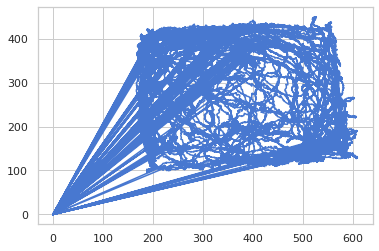

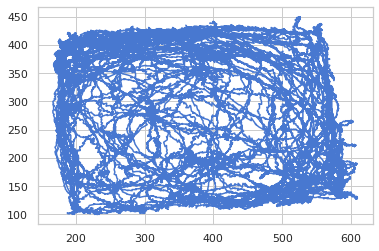

In [22]:
 # 1. mask pixels that are out of bounds
mask_x = np.logical_or(x < p.x_pix_lims[0], x > p.x_pix_lims[1])
mask_y = np.logical_or(y < p.y_pix_lims[0], y > p.y_pix_lims[1])
mask = np.logical_or(mask_x, mask_y)

x[mask] = np.nan
y[mask] = np.nan

plt.plot(x,y)

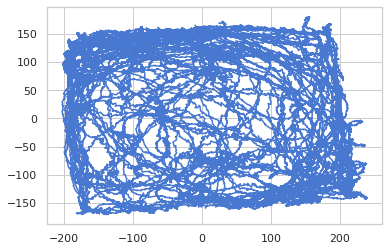

In [27]:
# 2. centering / pixel translation
x2 = x + p.x_pix_bias
y2 = y + p.y_pix_bias
plt.plot(x2,y2)

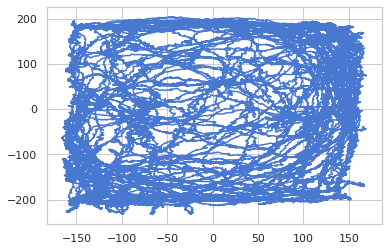

In [30]:
# 3. rotate to experimenter's pov
x3, y3 = spatial_funcs.rotate_xy(x2, y2, p.xy_pix_rot_rad)
plt.plot(x3,y3)

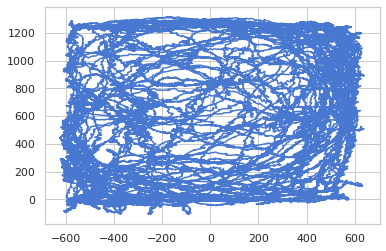

In [97]:
 # 4. convert to mm / re-scales; bias term re-frames the image
x4 = x3 * p.x_pix_mm + p.x_mm_bias
y4 = y3 * p.y_pix_mm + p.y_mm_bias
plt.plot(x4,y4)

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


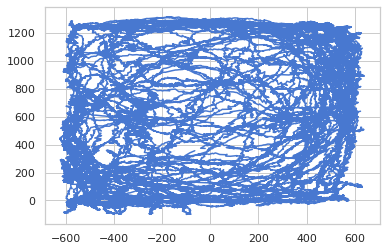

In [98]:
# 5. compute velocity to create speed threshold
dx = np.append(0, np.diff(x4))
dy = np.append(0, np.diff(y4))
dr = np.sqrt(dx ** 2 + dy ** 2)
mask_r = np.abs(dr) > p.speed_thr

# 6. mask creating out of bound zones in mm space
mask_y = np.logical_or(y4 < p.y_mm_lims[0], y4 > p.y_mm_lims[1])
mask_x = np.logical_or(x4 < p.x_mm_lims[0], x4 > p.x_mm_lims[1])
mask = np.logical_or(mask_x, mask_y)
mask = np.logical_or(mask, mask_r)

# 7. apply masks
x4[mask] = np.nan
y4[mask] = np.nan
ha2 = np.array(ha_vt)
ha2[mask] = np.nan
plt.plot(x4,y4)

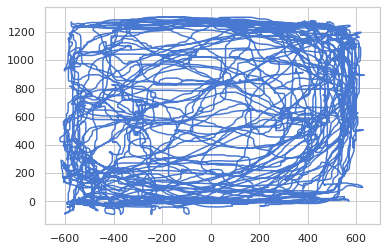

In [101]:
# 8. median filter the data to deal with nan
x5 = filter_funcs.median_window_filtfilt(x4, p.temporal_window_size)
y5 = filter_funcs.median_window_filtfilt(y4, p.temporal_window_size)
ha3 = filter_funcs.median_window_filtfilt(ha2, p.temporal_angle_window_size)

plt.plot(x5,y5)

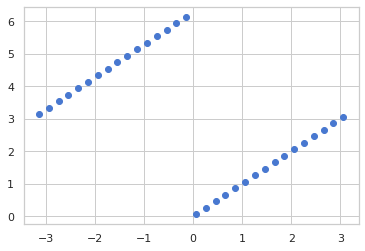

In [113]:
th = np.arange(-np.pi, np.pi,0.2)
th2 = np.mod(th,2*np.pi)
plt.scatter(th,th2)

In [121]:
def foo():
    def foo2(a):
        return a+2
    def foo3(a):
        return a+3
    
foo().foo2(1)

AttributeError: 'NoneType' object has no attribute 'foo2'

(array([2579.,  973.,  743.,  729.,  767.,  566.,  677.,  527.,  252.,
         920.,  358.,  349.,  343.,  560.,  741.,  965.,  996.,  650.,
        2268., 1919., 1645., 1895., 1624., 1296., 1312., 1186.,  545.,
        1878.,  848.,  896.,  797.,  947.,  993.,  944.,  906.,  501.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360]),
 <a list of 36 Patch objects>)

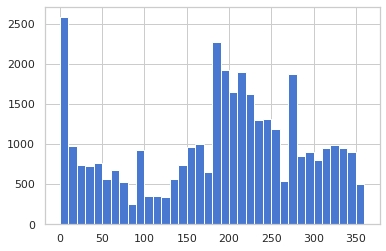

In [36]:
plt.hist(ha_rs, bins=bins)

In [39]:
ha_rs_bin,_=np.histogram(ha_rs,bins=bins)
ha_vt_bin,_=np.histogram(ha_vt,bins=bins)

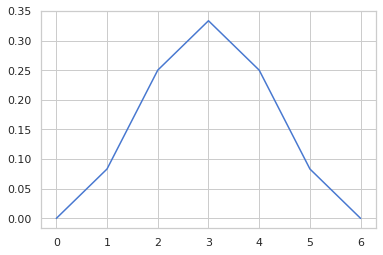

In [125]:
window = signal.get_window('hann',7,fftbins=False)
window /= window.sum()
plt.plot(window)

In [55]:
from Analyses.spatial_functions import get_angle_xy



In [126]:
window = signal.get_window('hann',7,fftbins=False)
window /= window.sum()



In [161]:
1450/444*200

653.1531531531532

(array([1179.,  862.,  727.,  594.,  593.,  687.,  694.,  697.,  712.,
         830.,  617.,  533.,  448.,  507.,  659.,  731.,  827.,  985.,
        1310., 1475., 1785., 1731., 1580., 1550., 1578., 1482., 1605.,
        1390., 1198.,  993.,  966.,  892.,  838.,  824.,  993., 1023.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360]),
 <a list of 36 Patch objects>)

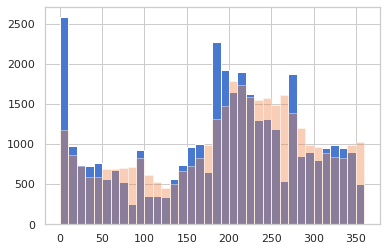

In [127]:
ha_f = get_angle_xy(ha_xf,ha_yf2)
ha_f = np.mod(np.rad2deg(ha_f),360)
plt.hist(ha_rs,bins)
plt.hist(ha_f,bins,alpha=0.4)

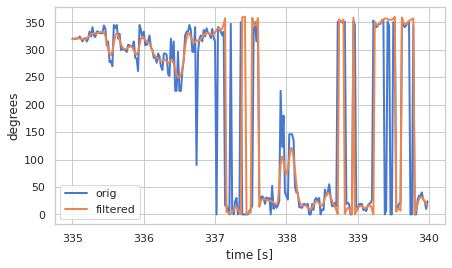

In [159]:
i = 67
sl = np.arange(250)+i*250
f,ax=plt.subplots(figsize=(7,4))
ax.plot(t_rs[sl]-t_rs[0], ha_rs[sl], linewidth=2, label='orig')
ax.plot(t_rs[sl]-t_rs[0], ha_f[sl],linewidth=2,label='filtered')
ax.legend(loc='best')
ax.set_xlabel('time [s]')
ax.set_ylabel('degrees')
f.savefig('circ_filter_examp.jpg')

In [152]:
!pwd

/home/alexgonzalez/Documents


In [4]:
tr, to = session_info.get_session_time_vectors(session)

In [11]:
spike_trains, spike_train_ids, wfi = session_info.get_spikes()

In [13]:
bin_spikes = session_info.get_binned_spikes()
fr = session_info.get_fr()

In [23]:
t,x,y,ha = session_info.get_track_dat()

array([23719.500525, 23719.516   , 23719.531476, ..., 24441.237229,
       24441.254386, 24441.270366])

In [13]:
def add2(a,b):
    a=a+2
    return a+b

In [16]:
import h5py
_track_data_file = session_info.paths['PreProcessed'] / 'vt.h5'

f = h5py.File(_track_data_file, 'r')
t_vt = np.array(f['t'])
x = np.array(f['x'])
y = np.array(f['y'])
ha = np.array(f['ha'])

In [20]:
f.keys()

<KeysViewHDF5 ['ha', 't', 'x', 'y']>

In [132]:
from TreeMazeAnalyses2.Analyses import spike_functions as SF
SF = reload(SF)

In [7]:
spike_trains, spike_train_ids, wfi = SF.get_session_spikes(subject_info,session, overwrite=True)

Spikes Files not Found or overwrite=1, creating them.


In [9]:
bin_spikes = SF.get_session_binned_spikes(subject_info,session,spike_trains)

In [10]:
np.array([len(x) for x in spike_trains]).sum() == bin_spikes.sum()

True

In [133]:
fr = SF.get_session_fr(subject_info, session, overwrite=True)


Firing Rate Files Not Found or overwrite=1, creating them.


In [99]:
i = 4
sl = i*50+np.arange(0,50,dtype=int)
(bin_spikes[0][sl]).sum(), fr4[sl].mean(), fr5[sl].mean()

(15.0, 15.338106903722808, 15.41)

In [122]:
time_step=0.02
filter_len = np.round(0.125 / time_step).astype(int)
filt_coeff = signal.windows.hann(filter_len)
fr4 = signal.filtfilt(filt_coeff/np.sum(filt_coeff),1,bin_spikes[0]/time_step)
fr5 = signal.filtfilt(np.ones(filter_len)/filter_len,1,bin_spikes[0]/time_step)

i = 10
sl = i*50+np.arange(0,50,dtype=int)
print(np.around(fr4[sl]), np.around(fr5[sl]), bin_spikes[0][sl]/time_step, sep='\n')
print()
print((bin_spikes[0][sl]).sum()/len(sl)/time_step, fr4[sl].mean(), fr5[sl].mean())

[67. 62. 60. 63. 70. 72. 61. 44. 35. 32. 29. 28. 35. 48. 55. 49. 40. 39.
 44. 42. 31. 26. 38. 50. 48. 40. 38. 36. 30. 27. 28. 28. 22. 18. 22. 28.
 32. 32. 28. 22. 18. 18. 26. 35. 35. 25. 16. 18. 27. 28.]
[68. 68. 67. 62. 62. 60. 54. 47. 42. 40. 37. 36. 37. 42. 44. 44. 43. 40.
 42. 40. 37. 36. 39. 43. 39. 37. 37. 37. 32. 28. 28. 26. 25. 24. 26. 26.
 26. 26. 25. 26. 25. 25. 25. 25. 28. 25. 24. 24. 25. 26.]
[ 50.  50. 100.   0. 100. 100.  50.  50.   0.  50.  50.   0.   0. 100.
  50.  50.  50.   0.  50. 100.   0.   0.   0. 150.   0.  50.   0. 100.
   0.   0.  50.  50.   0.   0.  50.   0.  50.  50.   0.  50.   0.   0.
  50.   0. 100.   0.   0.   0.  50.  50.]

37.0 36.9 37.11111111111111


array([[1.        , 0.63004319],
       [0.63004319, 1.        ]])

In [92]:
def aggregate_spikes_numpy(cell_spikes, cell_tt_cl, mua_spikes, mua_tt_cl):
    """
    Wrapper function for get_spikes_numpy
    Deals with Cell and Mua subcategories
    :param cell_spikes: numpy output of get_spikes_numpy
    :param cell_tt_cl: dict output of get_spikes_numpy
    :param mua_spikes: numpy output of get_spikes_numpy
    :param mua_tt_cl: dict output of get_spikes_numpy
    :returns: spikes. single object array containing both cell and mua spikes
    :returns: tt_cl. single dict containing the indices and identification info for each cluster
    """
    spikes = np.concatenate((cell_spikes, mua_spikes))
    n_cell_units = len(cell_spikes)
    n_mua_units = len(mua_spikes)
    n_units = n_cell_units + n_mua_units
    tt_cl = {}
    for unit in range(n_cell_units):
        tt_cl[unit] = ('Cell',) + cell_tt_cl[unit]
    for unit in range(n_mua_units):
        tt_cl[unit+n_cell_units] = ('Mua',) + mua_tt_cl[unit]

    return spikes, tt_cl


def get_spikes_numpy(spikes):
    n_units = spikes['n_units']
    spikes2 = np.empty(n_units, dtype=object)
    tt_cl = {}
    cnt = 0
    for tt in cell_spikes.keys():
        if tt=='n_units':
            continue
        for cl, spks in spikes[tt].items():
            spikes2[cnt] = np.array(spks).astype(np.int32)
            tt_cl[cnt] = tt,cl
            cnt+=1
            
    return spikes2, tt_cl

In [95]:
cell_spikes2,cell_tt_cl =get_spikes_numpy(cell_spikes)
mua_spikes2,mua_tt_cl =get_spikes_numpy(mua_spikes)

In [96]:
spikes, tt_cl = aggregate_spikes_numpy(cell_spikes2,cell_tt_cl,mua_spikes2,mua_tt_cl)

In [101]:
spikes.shape, tt_cl

((32,),
 {0: ('Cell', '3', '13'),
  1: ('Cell', '8', '0'),
  2: ('Cell', '8', '1'),
  3: ('Cell', '8', '3'),
  4: ('Cell', '8', '4'),
  5: ('Cell', '8', '5'),
  6: ('Cell', '8', '6'),
  7: ('Cell', '10', '1'),
  8: ('Cell', '10', '8'),
  9: ('Cell', '10', '9'),
  10: ('Cell', '10', '12'),
  11: ('Cell', '10', '14'),
  12: ('Cell', '14', '13'),
  13: ('Cell', '14', '15'),
  14: ('Mua', '3', '2'),
  15: ('Mua', '3', '6'),
  16: ('Mua', '3', '7'),
  17: ('Mua', '5', '9'),
  18: ('Mua', '7', '4'),
  19: ('Mua', '7', '5'),
  20: ('Mua', '7', '6'),
  21: ('Mua', '7', '7'),
  22: ('Mua', '7', '8'),
  23: ('Mua', '7', '10'),
  24: ('Mua', '10', '13'),
  25: ('Mua', '10', '16'),
  26: ('Mua', '10', '17'),
  27: ('Mua', '14', '0'),
  28: ('Mua', '14', '1'),
  29: ('Mua', '14', '9'),
  30: ('Mua', '14', '10'),
  31: ('Mua', '14', '11')})

In [53]:
clusters = subject_info.clusters[session]

In [54]:
clusters['cell_IDs'][]

{'3': [13],
 '5': [],
 '6': [],
 '7': [],
 '8': [0, 1, 3, 4, 5, 6],
 '9': [],
 '10': [1, 8, 9, 12, 14],
 '13': [],
 '14': [13, 15]}

In [64]:
[len(x[i]) for i in range(len(x))]

[17794,
 4274,
 3104,
 2753,
 3380,
 2794,
 9565,
 2020,
 548,
 2178,
 2382,
 1062,
 2951,
 18008]

In [6]:
#subject_info.clusters[session]
#subject_info.session_paths[session]
tt=8

clusters = subject_info.clusters[session]
sort_dir = subject_info.get_session_sorted_tt_dir(session,tt)
spk_times = np.load(sort_dir/'spike_times.npy').flatten()
cluster_spks = np.load(sort_dir/'spike_clusters.npy')
session_paths = subject_info.session_paths[session]
tt_dat = subject_info.get_session_tt_data(session,tt)



In [8]:
cl = 0
unit_ids = clusters['cell_IDs'][str(tt)]
cl_spks = spk_times[cluster_spks==unit_ids[cl]]


In [90]:
def get_waveform_info(spikes, waveforms, n_samps, samp_rate):

    waveforms = waveforms.astype(np.float32)
    n_spk = len(spikes)
    wfi = {'mean': np.nanmean(waveforms, axis=0),
           'std': np.nanstd(waveforms, axis=0),
           'sem': stats.sem(waveforms, axis=0),
           'nSp': n_spk,
           't_stat': stats.ttest_1samp(waveforms, 0, axis=0)[0],
           'm_fr': n_spk / n_samps * samp_rate}

    # isi in ms
    isi = np.diff(spikes)/samp_rate*1000
    wfi['isi_h'] = np.histogram(isi, bins=np.linspace(-1, 20, 25))
    wfi['cv'] = np.std(isi)/np.mean(isi)
    return wfi

def get_wf_samps(spikes):
    # inputs: spikes 1d np.array of integers indicating indices of spikes
    # output: np.ndarray n_spikes x 64 of integers
    a = np.zeros((len(spikes), 64), dtype=np.int)
    cnt = 0
    for s in spikes:
        a[cnt] = s+np.arange(64)-32
        cnt += 1
    return a


def get_waveforms(spikes, data):
    # inputs:
    #  -> spikes: 1d array of spike ids
    #  -> data: nd.array of size n_channels x n_samps
    # outputs:
    #  -> nd.array of shape  n_spikes x 64 x n_chans
    wf_samps = get_wf_samps(spikes) 
    return np.moveaxis(data[:, wf_samps], 0, -1)

def get_wf_outliers(waveforms, thr=0):
    # waveforms = nSpikes x 64 x 4 np.array
    n_spk, n_samps, n_ch = waveforms.shape
    n_feat = n_samps*n_ch
    
    X = np.reshape(waveforms,(n_spk,-1))

    Xm = np.nanmedian(X,0)
    Y = np.zeros(n_spk)
    for s in np.arange(n_spk)
        Y[s] = spatial.distance.braycurtis(Xm,X[s])
    bad_spikes = Y > thr
    # pca = PCA(n_components=2)
    # pca.fit(X)
    # lls = pca.score_samples(X)
    # badSpikes = np.abs(robust_zscore(lls))>thr
    return bad_spikes, Y

In [91]:
x=get_waveforms(cl_spks,tt_dat)

In [92]:
y = get_waveform_info(cl_spks,x,tt_dat.shape[1],32000)

In [128]:
x2 = x.reshape((x.shape[0],-1))
Xm = np.nanmedian(x2,0)

In [163]:
n_spk = x.shape[0]
x2 = x.reshape((n_spk,-1)).astype(np.float32)
Xm = np.nanmedian(x2,0)
x2 = x2-Xm
dists = np.zeros(n_spk)
for spk in range(n_spk):
    #dists[spk] = spatial.distance.sqeuclidean(Xm,x2[spk],np.abs(Xm)/np.sum(np.abs(Xm)))
    dists[spk] = spatial.distance.sqeuclidean(Xm,x2[spk])
    

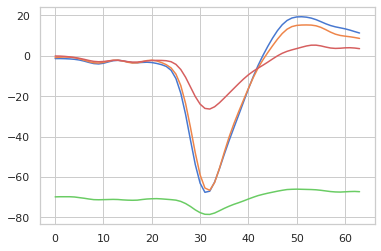

In [165]:
plt.plot(x[dists>dists.mean()].mean(axis=0))

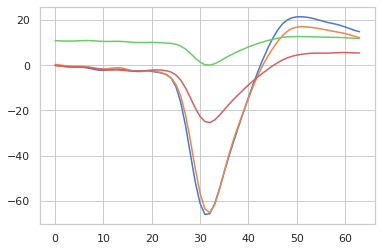

In [166]:
plt.plot(x[dists<dists.mean()].mean(axis=0))

(array([  18.,   48.,  179., 1281.,  612.,  565., 1306.,  226.,   46.,
          12.]),
 array([0.2365793 , 0.38878208, 0.54098487, 0.69318765, 0.84539044,
        0.99759322, 1.14979601, 1.30199879, 1.45420158, 1.60640436,
        1.75860715]),
 <a list of 10 Patch objects>)

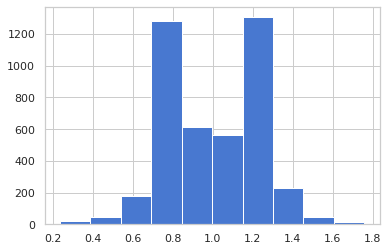

In [160]:
plt.hist(dists)